# Human Performance Monitoring Module (HPMM)

Authors: Ruoxin Xiong, Carnegie Mellon University; Jiawei Chen, Arizona State University; Pingbo Tang, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

This module predicts the loss of separation, an indicator of the air traffic controller's operational performance, with five machine learning based classifiers.

Loss of separation is a situation where aircraft fail to maintain minimum distances in controlled airspace.

More information about CatBoost can be found [here](https://arxiv.org/abs/1706.09516)

### Environment Requirements

The required packages are,

- [catboost](https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- pandas
- numpy
- scikit-learn

## Importing library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier

## Data Preparation

The sample data is collected from controller-in-the-loop simulation experiments during the air traffic control tasks.

In [2]:
df = pd.read_csv('./human_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ss                  4515 non-null   int64  
 1   condtn              4515 non-null   object 
 2   at_sec              4515 non-null   int64  
 3   traffic_density     4515 non-null   int64  
 4   los_freq            4515 non-null   int64  
 5   los_dur_over5min    4515 non-null   int64  
 6   cum_los_dur         4515 non-null   int64  
 7   query               4515 non-null   object 
 8   ready_latency       4466 non-null   float64
 9   ready_latency_adj   3518 non-null   float64
 10  query_latency       3518 non-null   float64
 11  response_index      3362 non-null   float64
 12  ready_timed_out     4466 non-null   float64
 13  query_timed_out     3518 non-null   float64
 14  stimuli             4466 non-null   object 
 15  response_text       3098 non-null   object 
 16  sa_cor

## Data Process
- Drop specified columns of redundant variables for los prediction. 
    - Here we drop 'Ss', 'condtn', 'los_freq', 'los_dur_over5min', 'query_timed_out', 'ready_timed_out', 'ready_latency_adj', 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query'.
- Data imputation with mean valus.
- Define predictor(X) and criterion(Y)
    - Transform 'los_freq' into binary classes (0 - no loss of separation; 1 - losses of separation)

In [3]:
df.drop(columns=['Ss', 'at_sec', 'condtn', 'ready_latency', 'query_latency', 'response_index', 'los_dur_over5min','query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query'], inplace=True)

df[df['los_freq'] > 1] = 1

df.fillna(df.mean(), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   traffic_density     4515 non-null   int64  
 1   los_freq            4515 non-null   int64  
 2   sa_correct          4515 non-null   float64
 3   wl_rating           4515 non-null   float64
 4   interbeat_interval  4515 non-null   float64
 5   rx                  4515 non-null   float64
 6   ry                  4515 non-null   float64
 7   rz                  4515 non-null   float64
 8   eyeblink            4515 non-null   float64
 9   negative            4515 non-null   float64
 10  neutral             4515 non-null   float64
 11  positive            4515 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 423.4 KB


In [4]:
X = df.drop(columns=['los_freq'])
Y = df['los_freq']

# Training and testing los prediction model

- Predict the occurence of loss of separation with five machine learning based classifiers
    - CatBoost
    - Support Vector Machines (SVM)
    - Decision Tree
    - k-Nearest Neighbors (kNN)
    - Naive Bayes
 
- Split the dataset into 80% and 20% for training and testing, respectively.
- The optimal CatBoost model parameters, including learning rate, depth, and L2 regularization term, are determined based on the grid search.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

## Model 1: CatBoost model

In [6]:
cb = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy'
)

grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        } 

cb.grid_search(grid, X=X_train, y=y_train, verbose= 2)

0:	learn: 0.8213915	test: 0.8340249	best: 0.8340249 (0)	total: 145ms	remaining: 2m 24s
1:	learn: 0.8248529	test: 0.8395574	best: 0.8395574 (1)	total: 146ms	remaining: 1m 13s
2:	learn: 0.8421599	test: 0.8450899	best: 0.8450899 (2)	total: 148ms	remaining: 49.2s
3:	learn: 0.8383524	test: 0.8520055	best: 0.8520055 (3)	total: 150ms	remaining: 37.2s
4:	learn: 0.8248529	test: 0.8409405	best: 0.8520055 (3)	total: 151ms	remaining: 30.1s
5:	learn: 0.8245067	test: 0.8367911	best: 0.8520055 (3)	total: 153ms	remaining: 25.3s
6:	learn: 0.8355832	test: 0.8381743	best: 0.8520055 (3)	total: 154ms	remaining: 21.9s
7:	learn: 0.8310834	test: 0.8437068	best: 0.8520055 (3)	total: 156ms	remaining: 19.3s
8:	learn: 0.8258913	test: 0.8395574	best: 0.8520055 (3)	total: 158ms	remaining: 17.4s
9:	learn: 0.8300450	test: 0.8423237	best: 0.8520055 (3)	total: 159ms	remaining: 15.8s
10:	learn: 0.8238145	test: 0.8409405	best: 0.8520055 (3)	total: 161ms	remaining: 14.5s
11:	learn: 0.8248529	test: 0.8409405	best: 0.852005

113:	learn: 0.8452752	test: 0.8561549	best: 0.8561549 (113)	total: 325ms	remaining: 2.53s
114:	learn: 0.8459675	test: 0.8561549	best: 0.8561549 (113)	total: 327ms	remaining: 2.52s
115:	learn: 0.8452752	test: 0.8561549	best: 0.8561549 (113)	total: 329ms	remaining: 2.5s
116:	learn: 0.8456213	test: 0.8547718	best: 0.8561549 (113)	total: 330ms	remaining: 2.49s
117:	learn: 0.8463136	test: 0.8547718	best: 0.8561549 (113)	total: 332ms	remaining: 2.48s
118:	learn: 0.8463136	test: 0.8533887	best: 0.8561549 (113)	total: 333ms	remaining: 2.47s
119:	learn: 0.8459675	test: 0.8533887	best: 0.8561549 (113)	total: 335ms	remaining: 2.46s
120:	learn: 0.8452752	test: 0.8533887	best: 0.8561549 (113)	total: 337ms	remaining: 2.45s
121:	learn: 0.8456213	test: 0.8533887	best: 0.8561549 (113)	total: 338ms	remaining: 2.44s
122:	learn: 0.8463136	test: 0.8547718	best: 0.8561549 (113)	total: 340ms	remaining: 2.42s
123:	learn: 0.8470059	test: 0.8533887	best: 0.8561549 (113)	total: 342ms	remaining: 2.41s
124:	learn:

229:	learn: 0.8518519	test: 0.8520055	best: 0.8561549 (113)	total: 507ms	remaining: 1.7s
230:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 508ms	remaining: 1.69s
231:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 510ms	remaining: 1.69s
232:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 511ms	remaining: 1.68s
233:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 513ms	remaining: 1.68s
234:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 514ms	remaining: 1.67s
235:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 516ms	remaining: 1.67s
236:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 518ms	remaining: 1.67s
237:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 519ms	remaining: 1.66s
238:	learn: 0.8521980	test: 0.8520055	best: 0.8561549 (113)	total: 521ms	remaining: 1.66s
239:	learn: 0.8525441	test: 0.8520055	best: 0.8561549 (113)	total: 523ms	remaining: 1.65s
240:	learn:

346:	learn: 0.8622361	test: 0.8603043	best: 0.8603043 (343)	total: 687ms	remaining: 1.29s
347:	learn: 0.8629283	test: 0.8603043	best: 0.8603043 (343)	total: 689ms	remaining: 1.29s
348:	learn: 0.8629283	test: 0.8603043	best: 0.8603043 (343)	total: 691ms	remaining: 1.29s
349:	learn: 0.8632745	test: 0.8603043	best: 0.8603043 (343)	total: 692ms	remaining: 1.28s
350:	learn: 0.8629283	test: 0.8603043	best: 0.8603043 (343)	total: 694ms	remaining: 1.28s
351:	learn: 0.8632745	test: 0.8603043	best: 0.8603043 (343)	total: 695ms	remaining: 1.28s
352:	learn: 0.8625822	test: 0.8603043	best: 0.8603043 (343)	total: 697ms	remaining: 1.28s
353:	learn: 0.8632745	test: 0.8603043	best: 0.8603043 (343)	total: 698ms	remaining: 1.27s
354:	learn: 0.8632745	test: 0.8603043	best: 0.8603043 (343)	total: 700ms	remaining: 1.27s
355:	learn: 0.8639668	test: 0.8603043	best: 0.8603043 (343)	total: 702ms	remaining: 1.27s
356:	learn: 0.8636206	test: 0.8603043	best: 0.8603043 (343)	total: 703ms	remaining: 1.27s
357:	learn

462:	learn: 0.8798892	test: 0.8644537	best: 0.8672199 (432)	total: 870ms	remaining: 1.01s
463:	learn: 0.8802354	test: 0.8630705	best: 0.8672199 (432)	total: 871ms	remaining: 1.01s
464:	learn: 0.8802354	test: 0.8644537	best: 0.8672199 (432)	total: 873ms	remaining: 1s
465:	learn: 0.8805815	test: 0.8630705	best: 0.8672199 (432)	total: 875ms	remaining: 1s
466:	learn: 0.8809277	test: 0.8630705	best: 0.8672199 (432)	total: 876ms	remaining: 1s
467:	learn: 0.8805815	test: 0.8658368	best: 0.8672199 (432)	total: 878ms	remaining: 998ms
468:	learn: 0.8805815	test: 0.8658368	best: 0.8672199 (432)	total: 880ms	remaining: 996ms
469:	learn: 0.8805815	test: 0.8644537	best: 0.8672199 (432)	total: 881ms	remaining: 994ms
470:	learn: 0.8805815	test: 0.8644537	best: 0.8672199 (432)	total: 883ms	remaining: 992ms
471:	learn: 0.8805815	test: 0.8644537	best: 0.8672199 (432)	total: 885ms	remaining: 990ms
472:	learn: 0.8802354	test: 0.8644537	best: 0.8672199 (432)	total: 886ms	remaining: 987ms
473:	learn: 0.88023

578:	learn: 0.8895812	test: 0.8686030	best: 0.8686030 (574)	total: 1.05s	remaining: 764ms
579:	learn: 0.8895812	test: 0.8686030	best: 0.8686030 (574)	total: 1.05s	remaining: 762ms
580:	learn: 0.8892350	test: 0.8686030	best: 0.8686030 (574)	total: 1.05s	remaining: 760ms
581:	learn: 0.8892350	test: 0.8686030	best: 0.8686030 (574)	total: 1.05s	remaining: 758ms
582:	learn: 0.8892350	test: 0.8672199	best: 0.8686030 (574)	total: 1.06s	remaining: 756ms
583:	learn: 0.8892350	test: 0.8672199	best: 0.8686030 (574)	total: 1.06s	remaining: 754ms
584:	learn: 0.8888889	test: 0.8672199	best: 0.8686030 (574)	total: 1.06s	remaining: 752ms
585:	learn: 0.8888889	test: 0.8672199	best: 0.8686030 (574)	total: 1.06s	remaining: 750ms
586:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.06s	remaining: 748ms
587:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.06s	remaining: 746ms
588:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.07s	remaining: 744ms
589:	learn

696:	learn: 0.8971963	test: 0.8686030	best: 0.8699862 (591)	total: 1.23s	remaining: 535ms
697:	learn: 0.8971963	test: 0.8686030	best: 0.8699862 (591)	total: 1.23s	remaining: 533ms
698:	learn: 0.8975424	test: 0.8686030	best: 0.8699862 (591)	total: 1.23s	remaining: 531ms
699:	learn: 0.8975424	test: 0.8686030	best: 0.8699862 (591)	total: 1.24s	remaining: 529ms
700:	learn: 0.8975424	test: 0.8672199	best: 0.8699862 (591)	total: 1.24s	remaining: 528ms
701:	learn: 0.8975424	test: 0.8672199	best: 0.8699862 (591)	total: 1.24s	remaining: 526ms
702:	learn: 0.8975424	test: 0.8686030	best: 0.8699862 (591)	total: 1.24s	remaining: 524ms
703:	learn: 0.8978885	test: 0.8686030	best: 0.8699862 (591)	total: 1.24s	remaining: 522ms
704:	learn: 0.8978885	test: 0.8686030	best: 0.8699862 (591)	total: 1.24s	remaining: 520ms
705:	learn: 0.8978885	test: 0.8672199	best: 0.8699862 (591)	total: 1.24s	remaining: 518ms
706:	learn: 0.8978885	test: 0.8672199	best: 0.8699862 (591)	total: 1.25s	remaining: 517ms
707:	learn

814:	learn: 0.9013499	test: 0.8699862	best: 0.8727524 (765)	total: 1.41s	remaining: 320ms
815:	learn: 0.9010038	test: 0.8699862	best: 0.8727524 (765)	total: 1.41s	remaining: 319ms
816:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.41s	remaining: 317ms
817:	learn: 0.9016961	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 315ms
818:	learn: 0.9013499	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 313ms
819:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 312ms
820:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 310ms
821:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 308ms
822:	learn: 0.9013499	test: 0.8713693	best: 0.8727524 (765)	total: 1.42s	remaining: 306ms
823:	learn: 0.9016961	test: 0.8713693	best: 0.8727524 (765)	total: 1.43s	remaining: 305ms
824:	learn: 0.9016961	test: 0.8713693	best: 0.8727524 (765)	total: 1.43s	remaining: 303ms
825:	learn

924:	learn: 0.9061959	test: 0.8727524	best: 0.8741355 (879)	total: 1.59s	remaining: 129ms
925:	learn: 0.9061959	test: 0.8727524	best: 0.8741355 (879)	total: 1.59s	remaining: 127ms
926:	learn: 0.9065421	test: 0.8727524	best: 0.8741355 (879)	total: 1.6s	remaining: 126ms
927:	learn: 0.9061959	test: 0.8727524	best: 0.8741355 (879)	total: 1.6s	remaining: 124ms
928:	learn: 0.9065421	test: 0.8727524	best: 0.8741355 (879)	total: 1.6s	remaining: 122ms
929:	learn: 0.9065421	test: 0.8727524	best: 0.8741355 (879)	total: 1.6s	remaining: 121ms
930:	learn: 0.9065421	test: 0.8727524	best: 0.8741355 (879)	total: 1.6s	remaining: 119ms
931:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.6s	remaining: 117ms
932:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.61s	remaining: 115ms
933:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (879)	total: 1.61s	remaining: 114ms
934:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.61s	remaining: 112ms
935:	learn: 0.90

39:	learn: 0.8508134	test: 0.8533887	best: 0.8589212 (30)	total: 61.6ms	remaining: 1.48s
40:	learn: 0.8501211	test: 0.8533887	best: 0.8589212 (30)	total: 63.2ms	remaining: 1.48s
41:	learn: 0.8494289	test: 0.8533887	best: 0.8589212 (30)	total: 64.9ms	remaining: 1.48s
42:	learn: 0.8501211	test: 0.8533887	best: 0.8589212 (30)	total: 66.5ms	remaining: 1.48s
43:	learn: 0.8497750	test: 0.8533887	best: 0.8589212 (30)	total: 68.1ms	remaining: 1.48s
44:	learn: 0.8501211	test: 0.8533887	best: 0.8589212 (30)	total: 69.7ms	remaining: 1.48s
45:	learn: 0.8521980	test: 0.8533887	best: 0.8589212 (30)	total: 71.3ms	remaining: 1.48s
46:	learn: 0.8525441	test: 0.8547718	best: 0.8589212 (30)	total: 73ms	remaining: 1.48s
47:	learn: 0.8535826	test: 0.8561549	best: 0.8589212 (30)	total: 74.6ms	remaining: 1.48s
48:	learn: 0.8525441	test: 0.8561549	best: 0.8589212 (30)	total: 76.2ms	remaining: 1.48s
49:	learn: 0.8525441	test: 0.8561549	best: 0.8589212 (30)	total: 77.7ms	remaining: 1.48s
50:	learn: 0.8532364	te

157:	learn: 0.8968501	test: 0.8699862	best: 0.8741355 (109)	total: 242ms	remaining: 1.29s
158:	learn: 0.8985808	test: 0.8699862	best: 0.8741355 (109)	total: 244ms	remaining: 1.29s
159:	learn: 0.8982347	test: 0.8699862	best: 0.8741355 (109)	total: 245ms	remaining: 1.29s
160:	learn: 0.8989270	test: 0.8699862	best: 0.8741355 (109)	total: 247ms	remaining: 1.29s
161:	learn: 0.8996192	test: 0.8686030	best: 0.8741355 (109)	total: 248ms	remaining: 1.28s
162:	learn: 0.8999654	test: 0.8686030	best: 0.8741355 (109)	total: 250ms	remaining: 1.28s
163:	learn: 0.8996192	test: 0.8699862	best: 0.8741355 (109)	total: 251ms	remaining: 1.28s
164:	learn: 0.8999654	test: 0.8699862	best: 0.8741355 (109)	total: 253ms	remaining: 1.28s
165:	learn: 0.9003115	test: 0.8699862	best: 0.8741355 (109)	total: 255ms	remaining: 1.28s
166:	learn: 0.9010038	test: 0.8699862	best: 0.8741355 (109)	total: 256ms	remaining: 1.28s
167:	learn: 0.9016961	test: 0.8686030	best: 0.8741355 (109)	total: 258ms	remaining: 1.28s
168:	learn

276:	learn: 0.9214261	test: 0.8755187	best: 0.8755187 (234)	total: 423ms	remaining: 1.1s
277:	learn: 0.9214261	test: 0.8741355	best: 0.8755187 (234)	total: 425ms	remaining: 1.1s
278:	learn: 0.9221184	test: 0.8741355	best: 0.8755187 (234)	total: 427ms	remaining: 1.1s
279:	learn: 0.9231568	test: 0.8741355	best: 0.8755187 (234)	total: 428ms	remaining: 1.1s
280:	learn: 0.9228107	test: 0.8755187	best: 0.8755187 (234)	total: 430ms	remaining: 1.1s
281:	learn: 0.9221184	test: 0.8755187	best: 0.8755187 (234)	total: 431ms	remaining: 1.1s
282:	learn: 0.9224645	test: 0.8755187	best: 0.8755187 (234)	total: 433ms	remaining: 1.1s
283:	learn: 0.9228107	test: 0.8769018	best: 0.8769018 (283)	total: 434ms	remaining: 1.09s
284:	learn: 0.9224645	test: 0.8769018	best: 0.8769018 (283)	total: 436ms	remaining: 1.09s
285:	learn: 0.9231568	test: 0.8755187	best: 0.8769018 (283)	total: 437ms	remaining: 1.09s
286:	learn: 0.9228107	test: 0.8741355	best: 0.8769018 (283)	total: 439ms	remaining: 1.09s
287:	learn: 0.924

395:	learn: 0.9428868	test: 0.8796680	best: 0.8824343 (389)	total: 606ms	remaining: 924ms
396:	learn: 0.9428868	test: 0.8796680	best: 0.8824343 (389)	total: 607ms	remaining: 922ms
397:	learn: 0.9425407	test: 0.8796680	best: 0.8824343 (389)	total: 609ms	remaining: 921ms
398:	learn: 0.9428868	test: 0.8796680	best: 0.8824343 (389)	total: 610ms	remaining: 919ms
399:	learn: 0.9428868	test: 0.8796680	best: 0.8824343 (389)	total: 612ms	remaining: 918ms
400:	learn: 0.9428868	test: 0.8782849	best: 0.8824343 (389)	total: 614ms	remaining: 916ms
401:	learn: 0.9428868	test: 0.8782849	best: 0.8824343 (389)	total: 615ms	remaining: 915ms
402:	learn: 0.9425407	test: 0.8782849	best: 0.8824343 (389)	total: 617ms	remaining: 914ms
403:	learn: 0.9428868	test: 0.8782849	best: 0.8824343 (389)	total: 618ms	remaining: 912ms
404:	learn: 0.9425407	test: 0.8782849	best: 0.8824343 (389)	total: 620ms	remaining: 911ms
405:	learn: 0.9421945	test: 0.8782849	best: 0.8824343 (389)	total: 622ms	remaining: 909ms
406:	learn

510:	learn: 0.9529249	test: 0.8810512	best: 0.8824343 (389)	total: 786ms	remaining: 752ms
511:	learn: 0.9529249	test: 0.8810512	best: 0.8824343 (389)	total: 788ms	remaining: 751ms
512:	learn: 0.9532710	test: 0.8810512	best: 0.8824343 (389)	total: 789ms	remaining: 749ms
513:	learn: 0.9529249	test: 0.8810512	best: 0.8824343 (389)	total: 791ms	remaining: 748ms
514:	learn: 0.9532710	test: 0.8810512	best: 0.8824343 (389)	total: 793ms	remaining: 746ms
515:	learn: 0.9529249	test: 0.8810512	best: 0.8824343 (389)	total: 794ms	remaining: 745ms
516:	learn: 0.9529249	test: 0.8810512	best: 0.8824343 (389)	total: 796ms	remaining: 743ms
517:	learn: 0.9532710	test: 0.8810512	best: 0.8824343 (389)	total: 797ms	remaining: 742ms
518:	learn: 0.9532710	test: 0.8810512	best: 0.8824343 (389)	total: 799ms	remaining: 740ms
519:	learn: 0.9536172	test: 0.8810512	best: 0.8824343 (389)	total: 800ms	remaining: 739ms
520:	learn: 0.9539633	test: 0.8810512	best: 0.8824343 (389)	total: 802ms	remaining: 737ms
521:	learn

624:	learn: 0.9629630	test: 0.8838174	best: 0.8852006 (566)	total: 968ms	remaining: 581ms
625:	learn: 0.9636552	test: 0.8838174	best: 0.8852006 (566)	total: 970ms	remaining: 579ms
626:	learn: 0.9636552	test: 0.8838174	best: 0.8852006 (566)	total: 971ms	remaining: 578ms
627:	learn: 0.9633091	test: 0.8838174	best: 0.8852006 (566)	total: 973ms	remaining: 576ms
628:	learn: 0.9633091	test: 0.8838174	best: 0.8852006 (566)	total: 974ms	remaining: 575ms
629:	learn: 0.9640014	test: 0.8838174	best: 0.8852006 (566)	total: 976ms	remaining: 573ms
630:	learn: 0.9640014	test: 0.8838174	best: 0.8852006 (566)	total: 977ms	remaining: 572ms
631:	learn: 0.9646937	test: 0.8838174	best: 0.8852006 (566)	total: 979ms	remaining: 570ms
632:	learn: 0.9646937	test: 0.8838174	best: 0.8852006 (566)	total: 980ms	remaining: 568ms
633:	learn: 0.9646937	test: 0.8838174	best: 0.8852006 (566)	total: 982ms	remaining: 567ms
634:	learn: 0.9646937	test: 0.8838174	best: 0.8852006 (566)	total: 984ms	remaining: 565ms
635:	learn

739:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.15s	remaining: 404ms
740:	learn: 0.9712703	test: 0.8865837	best: 0.8879668 (733)	total: 1.15s	remaining: 402ms
741:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.15s	remaining: 401ms
742:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.15s	remaining: 399ms
743:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.15s	remaining: 397ms
744:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.16s	remaining: 396ms
745:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.16s	remaining: 394ms
746:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.16s	remaining: 393ms
747:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.16s	remaining: 391ms
748:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (733)	total: 1.16s	remaining: 390ms
749:	learn: 0.9712703	test: 0.8852006	best: 0.8879668 (733)	total: 1.16s	remaining: 388ms
750:	learn

852:	learn: 0.9757702	test: 0.8852006	best: 0.8879668 (733)	total: 1.33s	remaining: 229ms
853:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.33s	remaining: 228ms
854:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.33s	remaining: 226ms
855:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.33s	remaining: 225ms
856:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 223ms
857:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 222ms
858:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 220ms
859:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 219ms
860:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 217ms
861:	learn: 0.9757702	test: 0.8865837	best: 0.8879668 (733)	total: 1.34s	remaining: 215ms
862:	learn: 0.9761163	test: 0.8865837	best: 0.8879668 (733)	total: 1.35s	remaining: 214ms
863:	learn

965:	learn: 0.9820007	test: 0.8893499	best: 0.8907331 (926)	total: 1.51s	remaining: 53.2ms
966:	learn: 0.9816546	test: 0.8893499	best: 0.8907331 (926)	total: 1.51s	remaining: 51.6ms
967:	learn: 0.9816546	test: 0.8893499	best: 0.8907331 (926)	total: 1.51s	remaining: 50ms
968:	learn: 0.9820007	test: 0.8893499	best: 0.8907331 (926)	total: 1.51s	remaining: 48.5ms
969:	learn: 0.9820007	test: 0.8893499	best: 0.8907331 (926)	total: 1.52s	remaining: 46.9ms
970:	learn: 0.9823468	test: 0.8893499	best: 0.8907331 (926)	total: 1.52s	remaining: 45.4ms
971:	learn: 0.9823468	test: 0.8893499	best: 0.8907331 (926)	total: 1.52s	remaining: 43.8ms
972:	learn: 0.9823468	test: 0.8893499	best: 0.8907331 (926)	total: 1.52s	remaining: 42.2ms
973:	learn: 0.9823468	test: 0.8879668	best: 0.8907331 (926)	total: 1.52s	remaining: 40.7ms
974:	learn: 0.9823468	test: 0.8879668	best: 0.8907331 (926)	total: 1.52s	remaining: 39.1ms
975:	learn: 0.9823468	test: 0.8879668	best: 0.8907331 (926)	total: 1.53s	remaining: 37.5ms
9

82:	learn: 0.9010038	test: 0.8727524	best: 0.8782849 (66)	total: 127ms	remaining: 1.4s
83:	learn: 0.9010038	test: 0.8755187	best: 0.8782849 (66)	total: 128ms	remaining: 1.4s
84:	learn: 0.9016961	test: 0.8741355	best: 0.8782849 (66)	total: 130ms	remaining: 1.4s
85:	learn: 0.9034268	test: 0.8727524	best: 0.8782849 (66)	total: 131ms	remaining: 1.4s
86:	learn: 0.9041191	test: 0.8741355	best: 0.8782849 (66)	total: 133ms	remaining: 1.4s
87:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (66)	total: 135ms	remaining: 1.39s
88:	learn: 0.9041191	test: 0.8796680	best: 0.8796680 (88)	total: 136ms	remaining: 1.39s
89:	learn: 0.9051575	test: 0.8782849	best: 0.8796680 (88)	total: 138ms	remaining: 1.39s
90:	learn: 0.9044652	test: 0.8782849	best: 0.8796680 (88)	total: 140ms	remaining: 1.39s
91:	learn: 0.9044652	test: 0.8782849	best: 0.8796680 (88)	total: 141ms	remaining: 1.39s
92:	learn: 0.9048114	test: 0.8782849	best: 0.8796680 (88)	total: 143ms	remaining: 1.39s
93:	learn: 0.9051575	test: 0.8769018	

198:	learn: 0.9394254	test: 0.8755187	best: 0.8796680 (88)	total: 306ms	remaining: 1.23s
199:	learn: 0.9394254	test: 0.8755187	best: 0.8796680 (88)	total: 308ms	remaining: 1.23s
200:	learn: 0.9394254	test: 0.8755187	best: 0.8796680 (88)	total: 310ms	remaining: 1.23s
201:	learn: 0.9390793	test: 0.8769018	best: 0.8796680 (88)	total: 312ms	remaining: 1.23s
202:	learn: 0.9394254	test: 0.8782849	best: 0.8796680 (88)	total: 313ms	remaining: 1.23s
203:	learn: 0.9397715	test: 0.8769018	best: 0.8796680 (88)	total: 315ms	remaining: 1.23s
204:	learn: 0.9401177	test: 0.8769018	best: 0.8796680 (88)	total: 316ms	remaining: 1.23s
205:	learn: 0.9401177	test: 0.8769018	best: 0.8796680 (88)	total: 318ms	remaining: 1.23s
206:	learn: 0.9408100	test: 0.8755187	best: 0.8796680 (88)	total: 320ms	remaining: 1.22s
207:	learn: 0.9404638	test: 0.8769018	best: 0.8796680 (88)	total: 321ms	remaining: 1.22s
208:	learn: 0.9411561	test: 0.8755187	best: 0.8796680 (88)	total: 323ms	remaining: 1.22s
209:	learn: 0.9408100

313:	learn: 0.9615784	test: 0.8796680	best: 0.8838174 (235)	total: 488ms	remaining: 1.07s
314:	learn: 0.9615784	test: 0.8796680	best: 0.8838174 (235)	total: 490ms	remaining: 1.06s
315:	learn: 0.9615784	test: 0.8796680	best: 0.8838174 (235)	total: 491ms	remaining: 1.06s
316:	learn: 0.9619245	test: 0.8796680	best: 0.8838174 (235)	total: 493ms	remaining: 1.06s
317:	learn: 0.9622707	test: 0.8782849	best: 0.8838174 (235)	total: 494ms	remaining: 1.06s
318:	learn: 0.9626168	test: 0.8782849	best: 0.8838174 (235)	total: 496ms	remaining: 1.06s
319:	learn: 0.9633091	test: 0.8782849	best: 0.8838174 (235)	total: 498ms	remaining: 1.06s
320:	learn: 0.9633091	test: 0.8782849	best: 0.8838174 (235)	total: 499ms	remaining: 1.05s
321:	learn: 0.9636552	test: 0.8782849	best: 0.8838174 (235)	total: 501ms	remaining: 1.05s
322:	learn: 0.9636552	test: 0.8782849	best: 0.8838174 (235)	total: 502ms	remaining: 1.05s
323:	learn: 0.9643475	test: 0.8782849	best: 0.8838174 (235)	total: 504ms	remaining: 1.05s
324:	learn

430:	learn: 0.9761163	test: 0.8741355	best: 0.8838174 (235)	total: 669ms	remaining: 884ms
431:	learn: 0.9757702	test: 0.8755187	best: 0.8838174 (235)	total: 671ms	remaining: 882ms
432:	learn: 0.9764624	test: 0.8755187	best: 0.8838174 (235)	total: 673ms	remaining: 881ms
433:	learn: 0.9764624	test: 0.8769018	best: 0.8838174 (235)	total: 674ms	remaining: 879ms
434:	learn: 0.9764624	test: 0.8741355	best: 0.8838174 (235)	total: 676ms	remaining: 878ms
435:	learn: 0.9764624	test: 0.8755187	best: 0.8838174 (235)	total: 677ms	remaining: 876ms
436:	learn: 0.9771547	test: 0.8727524	best: 0.8838174 (235)	total: 679ms	remaining: 875ms
437:	learn: 0.9775009	test: 0.8755187	best: 0.8838174 (235)	total: 681ms	remaining: 873ms
438:	learn: 0.9775009	test: 0.8741355	best: 0.8838174 (235)	total: 682ms	remaining: 872ms
439:	learn: 0.9781931	test: 0.8755187	best: 0.8838174 (235)	total: 684ms	remaining: 870ms
440:	learn: 0.9781931	test: 0.8769018	best: 0.8838174 (235)	total: 685ms	remaining: 869ms
441:	learn

548:	learn: 0.9903081	test: 0.8852006	best: 0.8879668 (538)	total: 851ms	remaining: 699ms
549:	learn: 0.9903081	test: 0.8852006	best: 0.8879668 (538)	total: 853ms	remaining: 698ms
550:	learn: 0.9906542	test: 0.8838174	best: 0.8879668 (538)	total: 855ms	remaining: 696ms
551:	learn: 0.9910003	test: 0.8810512	best: 0.8879668 (538)	total: 856ms	remaining: 695ms
552:	learn: 0.9910003	test: 0.8810512	best: 0.8879668 (538)	total: 858ms	remaining: 693ms
553:	learn: 0.9910003	test: 0.8838174	best: 0.8879668 (538)	total: 860ms	remaining: 692ms
554:	learn: 0.9910003	test: 0.8838174	best: 0.8879668 (538)	total: 861ms	remaining: 690ms
555:	learn: 0.9910003	test: 0.8824343	best: 0.8879668 (538)	total: 863ms	remaining: 689ms
556:	learn: 0.9906542	test: 0.8824343	best: 0.8879668 (538)	total: 864ms	remaining: 687ms
557:	learn: 0.9906542	test: 0.8810512	best: 0.8879668 (538)	total: 866ms	remaining: 686ms
558:	learn: 0.9906542	test: 0.8838174	best: 0.8879668 (538)	total: 867ms	remaining: 684ms
559:	learn

662:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.03s	remaining: 524ms
663:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.03s	remaining: 523ms
664:	learn: 0.9958463	test: 0.8810512	best: 0.8879668 (538)	total: 1.03s	remaining: 521ms
665:	learn: 0.9958463	test: 0.8810512	best: 0.8879668 (538)	total: 1.04s	remaining: 520ms
666:	learn: 0.9958463	test: 0.8810512	best: 0.8879668 (538)	total: 1.04s	remaining: 518ms
667:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.04s	remaining: 517ms
668:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.04s	remaining: 515ms
669:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.04s	remaining: 513ms
670:	learn: 0.9958463	test: 0.8838174	best: 0.8879668 (538)	total: 1.04s	remaining: 512ms
671:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.04s	remaining: 510ms
672:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.05s	remaining: 509ms
673:	learn

780:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.21s	remaining: 340ms
781:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 339ms
782:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 337ms
783:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 336ms
784:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 334ms
785:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 333ms
786:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.22s	remaining: 331ms
787:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.23s	remaining: 330ms
788:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.23s	remaining: 328ms
789:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.23s	remaining: 326ms
790:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.23s	remaining: 325ms
791:	learn

896:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.39s	remaining: 160ms
897:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.4s	remaining: 159ms
898:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.4s	remaining: 157ms
899:	learn: 0.9989616	test: 0.8838174	best: 0.8879668 (538)	total: 1.4s	remaining: 155ms
900:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.4s	remaining: 154ms
901:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.4s	remaining: 152ms
902:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (538)	total: 1.4s	remaining: 151ms
903:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (538)	total: 1.41s	remaining: 149ms
904:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.41s	remaining: 148ms
905:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.41s	remaining: 146ms
906:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.41s	remaining: 145ms
907:	learn: 0.99

9:	learn: 0.8331603	test: 0.8409405	best: 0.8520055 (3)	total: 16ms	remaining: 1.58s
10:	learn: 0.8307373	test: 0.8437068	best: 0.8520055 (3)	total: 17.6ms	remaining: 1.58s
11:	learn: 0.8331603	test: 0.8437068	best: 0.8520055 (3)	total: 19.3ms	remaining: 1.58s
12:	learn: 0.8369678	test: 0.8450899	best: 0.8520055 (3)	total: 20.8ms	remaining: 1.58s
13:	learn: 0.8348910	test: 0.8423237	best: 0.8520055 (3)	total: 22.4ms	remaining: 1.57s
14:	learn: 0.8341987	test: 0.8450899	best: 0.8520055 (3)	total: 23.9ms	remaining: 1.57s
15:	learn: 0.8335064	test: 0.8450899	best: 0.8520055 (3)	total: 25.4ms	remaining: 1.56s
16:	learn: 0.8265836	test: 0.8437068	best: 0.8520055 (3)	total: 26.9ms	remaining: 1.55s
17:	learn: 0.8293527	test: 0.8464730	best: 0.8520055 (3)	total: 28.5ms	remaining: 1.55s
18:	learn: 0.8328141	test: 0.8478562	best: 0.8520055 (3)	total: 29.9ms	remaining: 1.54s
19:	learn: 0.8324680	test: 0.8478562	best: 0.8520055 (3)	total: 31.4ms	remaining: 1.54s
20:	learn: 0.8321218	test: 0.846473

124:	learn: 0.8376601	test: 0.8478562	best: 0.8520055 (3)	total: 196ms	remaining: 1.37s
125:	learn: 0.8376601	test: 0.8478562	best: 0.8520055 (3)	total: 197ms	remaining: 1.37s
126:	learn: 0.8383524	test: 0.8478562	best: 0.8520055 (3)	total: 199ms	remaining: 1.37s
127:	learn: 0.8380062	test: 0.8478562	best: 0.8520055 (3)	total: 200ms	remaining: 1.36s
128:	learn: 0.8383524	test: 0.8478562	best: 0.8520055 (3)	total: 202ms	remaining: 1.36s
129:	learn: 0.8386985	test: 0.8478562	best: 0.8520055 (3)	total: 203ms	remaining: 1.36s
130:	learn: 0.8386985	test: 0.8478562	best: 0.8520055 (3)	total: 205ms	remaining: 1.36s
131:	learn: 0.8390447	test: 0.8478562	best: 0.8520055 (3)	total: 207ms	remaining: 1.36s
132:	learn: 0.8390447	test: 0.8478562	best: 0.8520055 (3)	total: 208ms	remaining: 1.36s
133:	learn: 0.8397369	test: 0.8478562	best: 0.8520055 (3)	total: 210ms	remaining: 1.35s
134:	learn: 0.8400831	test: 0.8478562	best: 0.8520055 (3)	total: 211ms	remaining: 1.35s
135:	learn: 0.8400831	test: 0.84

241:	learn: 0.8521980	test: 0.8575380	best: 0.8575380 (241)	total: 377ms	remaining: 1.18s
242:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 379ms	remaining: 1.18s
243:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 381ms	remaining: 1.18s
244:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 382ms	remaining: 1.18s
245:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 384ms	remaining: 1.18s
246:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 385ms	remaining: 1.17s
247:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 387ms	remaining: 1.17s
248:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 389ms	remaining: 1.17s
249:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 390ms	remaining: 1.17s
250:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 392ms	remaining: 1.17s
251:	learn: 0.8518519	test: 0.8561549	best: 0.8575380 (241)	total: 393ms	remaining: 1.17s
252:	learn

357:	learn: 0.8629283	test: 0.8603043	best: 0.8616874 (337)	total: 558ms	remaining: 1s
358:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (337)	total: 560ms	remaining: 1000ms
359:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 562ms	remaining: 999ms
360:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 563ms	remaining: 997ms
361:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 565ms	remaining: 996ms
362:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 566ms	remaining: 994ms
363:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (337)	total: 568ms	remaining: 992ms
364:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (337)	total: 570ms	remaining: 991ms
365:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 571ms	remaining: 989ms
366:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 573ms	remaining: 988ms
367:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 574ms	remaining: 986ms
368:	learn: 

471:	learn: 0.8757355	test: 0.8630705	best: 0.8630705 (384)	total: 739ms	remaining: 827ms
472:	learn: 0.8753894	test: 0.8630705	best: 0.8630705 (384)	total: 741ms	remaining: 826ms
473:	learn: 0.8753894	test: 0.8630705	best: 0.8630705 (384)	total: 743ms	remaining: 824ms
474:	learn: 0.8753894	test: 0.8630705	best: 0.8630705 (384)	total: 744ms	remaining: 823ms
475:	learn: 0.8757355	test: 0.8630705	best: 0.8630705 (384)	total: 746ms	remaining: 821ms
476:	learn: 0.8757355	test: 0.8630705	best: 0.8630705 (384)	total: 748ms	remaining: 820ms
477:	learn: 0.8757355	test: 0.8630705	best: 0.8630705 (384)	total: 750ms	remaining: 819ms
478:	learn: 0.8757355	test: 0.8644537	best: 0.8644537 (478)	total: 751ms	remaining: 817ms
479:	learn: 0.8757355	test: 0.8644537	best: 0.8644537 (478)	total: 753ms	remaining: 816ms
480:	learn: 0.8757355	test: 0.8644537	best: 0.8644537 (478)	total: 755ms	remaining: 814ms
481:	learn: 0.8764278	test: 0.8658368	best: 0.8658368 (481)	total: 756ms	remaining: 813ms
482:	learn

585:	learn: 0.8847352	test: 0.8699862	best: 0.8713693 (572)	total: 921ms	remaining: 650ms
586:	learn: 0.8847352	test: 0.8713693	best: 0.8713693 (572)	total: 922ms	remaining: 649ms
587:	learn: 0.8843891	test: 0.8713693	best: 0.8713693 (572)	total: 924ms	remaining: 647ms
588:	learn: 0.8843891	test: 0.8713693	best: 0.8713693 (572)	total: 926ms	remaining: 646ms
589:	learn: 0.8843891	test: 0.8713693	best: 0.8713693 (572)	total: 927ms	remaining: 644ms
590:	learn: 0.8843891	test: 0.8713693	best: 0.8713693 (572)	total: 928ms	remaining: 643ms
591:	learn: 0.8847352	test: 0.8713693	best: 0.8713693 (572)	total: 930ms	remaining: 641ms
592:	learn: 0.8843891	test: 0.8713693	best: 0.8713693 (572)	total: 931ms	remaining: 639ms
593:	learn: 0.8847352	test: 0.8713693	best: 0.8713693 (572)	total: 933ms	remaining: 638ms
594:	learn: 0.8847352	test: 0.8713693	best: 0.8713693 (572)	total: 934ms	remaining: 636ms
595:	learn: 0.8847352	test: 0.8713693	best: 0.8713693 (572)	total: 936ms	remaining: 634ms
596:	learn

706:	learn: 0.8947733	test: 0.8755187	best: 0.8755187 (673)	total: 1.1s	remaining: 457ms
707:	learn: 0.8947733	test: 0.8755187	best: 0.8755187 (673)	total: 1.1s	remaining: 456ms
708:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 454ms
709:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 453ms
710:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 451ms
711:	learn: 0.8951194	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 450ms
712:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 448ms
713:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 446ms
714:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.11s	remaining: 445ms
715:	learn: 0.8944271	test: 0.8755187	best: 0.8755187 (673)	total: 1.12s	remaining: 443ms
716:	learn: 0.8944271	test: 0.8741355	best: 0.8755187 (673)	total: 1.12s	remaining: 442ms
717:	learn: 

823:	learn: 0.8996192	test: 0.8727524	best: 0.8755187 (673)	total: 1.28s	remaining: 274ms
824:	learn: 0.8999654	test: 0.8727524	best: 0.8755187 (673)	total: 1.28s	remaining: 273ms
825:	learn: 0.8999654	test: 0.8727524	best: 0.8755187 (673)	total: 1.29s	remaining: 271ms
826:	learn: 0.8999654	test: 0.8727524	best: 0.8755187 (673)	total: 1.29s	remaining: 270ms
827:	learn: 0.8999654	test: 0.8727524	best: 0.8755187 (673)	total: 1.29s	remaining: 268ms
828:	learn: 0.8999654	test: 0.8727524	best: 0.8755187 (673)	total: 1.29s	remaining: 266ms
829:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.29s	remaining: 265ms
830:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.29s	remaining: 263ms
831:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 262ms
832:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 260ms
833:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 259ms
834:	learn: 0

944:	learn: 0.9044652	test: 0.8755187	best: 0.8769018 (838)	total: 1.47s	remaining: 85.4ms
945:	learn: 0.9044652	test: 0.8755187	best: 0.8769018 (838)	total: 1.47s	remaining: 83.8ms
946:	learn: 0.9041191	test: 0.8769018	best: 0.8769018 (838)	total: 1.47s	remaining: 82.3ms
947:	learn: 0.9041191	test: 0.8769018	best: 0.8769018 (838)	total: 1.47s	remaining: 80.7ms
948:	learn: 0.9037729	test: 0.8769018	best: 0.8769018 (838)	total: 1.47s	remaining: 79.2ms
949:	learn: 0.9037729	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 77.6ms
950:	learn: 0.9041191	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 76.1ms
951:	learn: 0.9041191	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 74.5ms
952:	learn: 0.9041191	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 73ms
953:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 71.4ms
954:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 69.9ms
9

42:	learn: 0.8518519	test: 0.8589212	best: 0.8589212 (37)	total: 66.6ms	remaining: 1.48s
43:	learn: 0.8515057	test: 0.8603043	best: 0.8603043 (43)	total: 68.2ms	remaining: 1.48s
44:	learn: 0.8528903	test: 0.8603043	best: 0.8603043 (43)	total: 69.7ms	remaining: 1.48s
45:	learn: 0.8532364	test: 0.8603043	best: 0.8603043 (43)	total: 71.3ms	remaining: 1.48s
46:	learn: 0.8532364	test: 0.8547718	best: 0.8603043 (43)	total: 72.8ms	remaining: 1.48s
47:	learn: 0.8549671	test: 0.8561549	best: 0.8603043 (43)	total: 74.3ms	remaining: 1.47s
48:	learn: 0.8546210	test: 0.8561549	best: 0.8603043 (43)	total: 76ms	remaining: 1.47s
49:	learn: 0.8556594	test: 0.8575380	best: 0.8603043 (43)	total: 77.5ms	remaining: 1.47s
50:	learn: 0.8556594	test: 0.8561549	best: 0.8603043 (43)	total: 79ms	remaining: 1.47s
51:	learn: 0.8563517	test: 0.8561549	best: 0.8603043 (43)	total: 80.5ms	remaining: 1.47s
52:	learn: 0.8580824	test: 0.8575380	best: 0.8603043 (43)	total: 82.1ms	remaining: 1.47s
53:	learn: 0.8573901	test

161:	learn: 0.8968501	test: 0.8727524	best: 0.8782849 (130)	total: 249ms	remaining: 1.29s
162:	learn: 0.8965040	test: 0.8727524	best: 0.8782849 (130)	total: 251ms	remaining: 1.29s
163:	learn: 0.8975424	test: 0.8727524	best: 0.8782849 (130)	total: 252ms	remaining: 1.28s
164:	learn: 0.8978885	test: 0.8727524	best: 0.8782849 (130)	total: 254ms	remaining: 1.28s
165:	learn: 0.8985808	test: 0.8727524	best: 0.8782849 (130)	total: 255ms	remaining: 1.28s
166:	learn: 0.8992731	test: 0.8727524	best: 0.8782849 (130)	total: 257ms	remaining: 1.28s
167:	learn: 0.8996192	test: 0.8727524	best: 0.8782849 (130)	total: 258ms	remaining: 1.28s
168:	learn: 0.9003115	test: 0.8727524	best: 0.8782849 (130)	total: 260ms	remaining: 1.28s
169:	learn: 0.8999654	test: 0.8713693	best: 0.8782849 (130)	total: 262ms	remaining: 1.28s
170:	learn: 0.8989270	test: 0.8713693	best: 0.8782849 (130)	total: 263ms	remaining: 1.27s
171:	learn: 0.8992731	test: 0.8713693	best: 0.8782849 (130)	total: 265ms	remaining: 1.27s
172:	learn

279:	learn: 0.9162340	test: 0.8838174	best: 0.8838174 (262)	total: 432ms	remaining: 1.11s
280:	learn: 0.9172724	test: 0.8838174	best: 0.8838174 (262)	total: 434ms	remaining: 1.11s
281:	learn: 0.9183108	test: 0.8838174	best: 0.8838174 (262)	total: 435ms	remaining: 1.11s
282:	learn: 0.9193493	test: 0.8838174	best: 0.8838174 (262)	total: 437ms	remaining: 1.11s
283:	learn: 0.9200415	test: 0.8838174	best: 0.8838174 (262)	total: 438ms	remaining: 1.1s
284:	learn: 0.9200415	test: 0.8838174	best: 0.8838174 (262)	total: 440ms	remaining: 1.1s
285:	learn: 0.9200415	test: 0.8838174	best: 0.8838174 (262)	total: 441ms	remaining: 1.1s
286:	learn: 0.9207338	test: 0.8838174	best: 0.8838174 (262)	total: 443ms	remaining: 1.1s
287:	learn: 0.9203877	test: 0.8838174	best: 0.8838174 (262)	total: 444ms	remaining: 1.1s
288:	learn: 0.9214261	test: 0.8838174	best: 0.8838174 (262)	total: 446ms	remaining: 1.1s
289:	learn: 0.9214261	test: 0.8838174	best: 0.8838174 (262)	total: 447ms	remaining: 1.09s
290:	learn: 0.92

397:	learn: 0.9370024	test: 0.8852006	best: 0.8865837 (355)	total: 614ms	remaining: 929ms
398:	learn: 0.9373486	test: 0.8852006	best: 0.8865837 (355)	total: 616ms	remaining: 927ms
399:	learn: 0.9376947	test: 0.8852006	best: 0.8865837 (355)	total: 617ms	remaining: 926ms
400:	learn: 0.9380408	test: 0.8852006	best: 0.8865837 (355)	total: 619ms	remaining: 924ms
401:	learn: 0.9383870	test: 0.8852006	best: 0.8865837 (355)	total: 620ms	remaining: 923ms
402:	learn: 0.9383870	test: 0.8838174	best: 0.8865837 (355)	total: 622ms	remaining: 921ms
403:	learn: 0.9387331	test: 0.8838174	best: 0.8865837 (355)	total: 623ms	remaining: 920ms
404:	learn: 0.9401177	test: 0.8838174	best: 0.8865837 (355)	total: 625ms	remaining: 918ms
405:	learn: 0.9401177	test: 0.8838174	best: 0.8865837 (355)	total: 626ms	remaining: 916ms
406:	learn: 0.9408100	test: 0.8838174	best: 0.8865837 (355)	total: 628ms	remaining: 915ms
407:	learn: 0.9404638	test: 0.8838174	best: 0.8865837 (355)	total: 629ms	remaining: 913ms
408:	learn

516:	learn: 0.9480789	test: 0.8907331	best: 0.8921162 (477)	total: 795ms	remaining: 743ms
517:	learn: 0.9480789	test: 0.8907331	best: 0.8921162 (477)	total: 797ms	remaining: 742ms
518:	learn: 0.9484251	test: 0.8893499	best: 0.8921162 (477)	total: 799ms	remaining: 740ms
519:	learn: 0.9480789	test: 0.8893499	best: 0.8921162 (477)	total: 800ms	remaining: 739ms
520:	learn: 0.9480789	test: 0.8893499	best: 0.8921162 (477)	total: 802ms	remaining: 737ms
521:	learn: 0.9484251	test: 0.8907331	best: 0.8921162 (477)	total: 803ms	remaining: 736ms
522:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (477)	total: 805ms	remaining: 734ms
523:	learn: 0.9487712	test: 0.8893499	best: 0.8921162 (477)	total: 807ms	remaining: 733ms
524:	learn: 0.9491173	test: 0.8879668	best: 0.8921162 (477)	total: 808ms	remaining: 731ms
525:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (477)	total: 810ms	remaining: 730ms
526:	learn: 0.9491173	test: 0.8879668	best: 0.8921162 (477)	total: 811ms	remaining: 728ms
527:	learn

635:	learn: 0.9563863	test: 0.8921162	best: 0.8921162 (477)	total: 979ms	remaining: 560ms
636:	learn: 0.9563863	test: 0.8921162	best: 0.8921162 (477)	total: 980ms	remaining: 559ms
637:	learn: 0.9563863	test: 0.8907331	best: 0.8921162 (477)	total: 982ms	remaining: 557ms
638:	learn: 0.9567324	test: 0.8907331	best: 0.8921162 (477)	total: 983ms	remaining: 556ms
639:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 985ms	remaining: 554ms
640:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 987ms	remaining: 553ms
641:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 988ms	remaining: 551ms
642:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 990ms	remaining: 549ms
643:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 991ms	remaining: 548ms
644:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 993ms	remaining: 546ms
645:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 994ms	remaining: 545ms
646:	learn

754:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.16s	remaining: 376ms
755:	learn: 0.9629630	test: 0.8865837	best: 0.8948824 (654)	total: 1.16s	remaining: 375ms
756:	learn: 0.9629630	test: 0.8865837	best: 0.8948824 (654)	total: 1.16s	remaining: 373ms
757:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.16s	remaining: 372ms
758:	learn: 0.9633091	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 370ms
759:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 369ms
760:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 367ms
761:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 366ms
762:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 364ms
763:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.17s	remaining: 363ms
764:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.18s	remaining: 361ms
765:	learn

875:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.34s	remaining: 190ms
876:	learn: 0.9698858	test: 0.8893499	best: 0.8948824 (654)	total: 1.34s	remaining: 189ms
877:	learn: 0.9702319	test: 0.8893499	best: 0.8948824 (654)	total: 1.34s	remaining: 187ms
878:	learn: 0.9709242	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 185ms
879:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 184ms
880:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 182ms
881:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 181ms
882:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 179ms
883:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.35s	remaining: 178ms
884:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.36s	remaining: 176ms
885:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.36s	remaining: 175ms
886:	learn

995:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.52s	remaining: 6.12ms
996:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.53s	remaining: 4.59ms
997:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.53s	remaining: 3.06ms
998:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.53s	remaining: 1.53ms
999:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.53s	remaining: 0us

bestTest = 0.8948824343
bestIteration = 654

4:	loss: 0.8948824	best: 0.8948824 (4)	total: 8.31s	remaining: 1m 6s
0:	learn: 0.8213915	test: 0.8340249	best: 0.8340249 (0)	total: 1.58ms	remaining: 1.58s
1:	learn: 0.8255452	test: 0.8381743	best: 0.8381743 (1)	total: 3.03ms	remaining: 1.51s
2:	learn: 0.8338525	test: 0.8395574	best: 0.8395574 (2)	total: 4.52ms	remaining: 1.5s
3:	learn: 0.8380062	test: 0.8409405	best: 0.8409405 (3)	total: 6.01ms	remaining: 1.5s
4:	learn: 0.8380062	test: 0.8492393	best: 0.8492393 (4)	total: 7.59ms	remaining: 1.51s


112:	learn: 0.9089650	test: 0.8796680	best: 0.8824343 (104)	total: 173ms	remaining: 1.36s
113:	learn: 0.9089650	test: 0.8824343	best: 0.8824343 (104)	total: 175ms	remaining: 1.36s
114:	learn: 0.9103496	test: 0.8824343	best: 0.8824343 (104)	total: 177ms	remaining: 1.36s
115:	learn: 0.9103496	test: 0.8838174	best: 0.8838174 (115)	total: 178ms	remaining: 1.36s
116:	learn: 0.9100035	test: 0.8810512	best: 0.8838174 (115)	total: 180ms	remaining: 1.36s
117:	learn: 0.9103496	test: 0.8810512	best: 0.8838174 (115)	total: 181ms	remaining: 1.36s
118:	learn: 0.9120803	test: 0.8810512	best: 0.8838174 (115)	total: 183ms	remaining: 1.35s
119:	learn: 0.9113880	test: 0.8782849	best: 0.8838174 (115)	total: 184ms	remaining: 1.35s
120:	learn: 0.9113880	test: 0.8796680	best: 0.8838174 (115)	total: 186ms	remaining: 1.35s
121:	learn: 0.9110419	test: 0.8796680	best: 0.8838174 (115)	total: 187ms	remaining: 1.35s
122:	learn: 0.9117342	test: 0.8796680	best: 0.8838174 (115)	total: 189ms	remaining: 1.35s
123:	learn

228:	learn: 0.9421945	test: 0.8893499	best: 0.8907331 (223)	total: 355ms	remaining: 1.2s
229:	learn: 0.9418484	test: 0.8893499	best: 0.8907331 (223)	total: 357ms	remaining: 1.2s
230:	learn: 0.9432330	test: 0.8865837	best: 0.8907331 (223)	total: 359ms	remaining: 1.19s
231:	learn: 0.9439252	test: 0.8879668	best: 0.8907331 (223)	total: 360ms	remaining: 1.19s
232:	learn: 0.9442714	test: 0.8907331	best: 0.8907331 (223)	total: 362ms	remaining: 1.19s
233:	learn: 0.9442714	test: 0.8907331	best: 0.8907331 (223)	total: 363ms	remaining: 1.19s
234:	learn: 0.9439252	test: 0.8865837	best: 0.8907331 (223)	total: 365ms	remaining: 1.19s
235:	learn: 0.9439252	test: 0.8852006	best: 0.8907331 (223)	total: 366ms	remaining: 1.19s
236:	learn: 0.9435791	test: 0.8852006	best: 0.8907331 (223)	total: 368ms	remaining: 1.18s
237:	learn: 0.9442714	test: 0.8865837	best: 0.8907331 (223)	total: 369ms	remaining: 1.18s
238:	learn: 0.9442714	test: 0.8893499	best: 0.8907331 (223)	total: 371ms	remaining: 1.18s
239:	learn: 

347:	learn: 0.9598477	test: 0.8879668	best: 0.8934993 (327)	total: 539ms	remaining: 1.01s
348:	learn: 0.9598477	test: 0.8865837	best: 0.8934993 (327)	total: 541ms	remaining: 1.01s
349:	learn: 0.9598477	test: 0.8865837	best: 0.8934993 (327)	total: 542ms	remaining: 1.01s
350:	learn: 0.9598477	test: 0.8865837	best: 0.8934993 (327)	total: 544ms	remaining: 1s
351:	learn: 0.9605400	test: 0.8865837	best: 0.8934993 (327)	total: 545ms	remaining: 1s
352:	learn: 0.9608861	test: 0.8865837	best: 0.8934993 (327)	total: 547ms	remaining: 1s
353:	learn: 0.9605400	test: 0.8865837	best: 0.8934993 (327)	total: 548ms	remaining: 1s
354:	learn: 0.9605400	test: 0.8865837	best: 0.8934993 (327)	total: 550ms	remaining: 999ms
355:	learn: 0.9608861	test: 0.8852006	best: 0.8934993 (327)	total: 551ms	remaining: 997ms
356:	learn: 0.9605400	test: 0.8852006	best: 0.8934993 (327)	total: 553ms	remaining: 996ms
357:	learn: 0.9608861	test: 0.8865837	best: 0.8934993 (327)	total: 554ms	remaining: 994ms
358:	learn: 0.9612323	

465:	learn: 0.9716165	test: 0.8879668	best: 0.8934993 (327)	total: 720ms	remaining: 825ms
466:	learn: 0.9723088	test: 0.8879668	best: 0.8934993 (327)	total: 722ms	remaining: 824ms
467:	learn: 0.9723088	test: 0.8879668	best: 0.8934993 (327)	total: 724ms	remaining: 823ms
468:	learn: 0.9723088	test: 0.8893499	best: 0.8934993 (327)	total: 725ms	remaining: 821ms
469:	learn: 0.9726549	test: 0.8893499	best: 0.8934993 (327)	total: 727ms	remaining: 819ms
470:	learn: 0.9726549	test: 0.8893499	best: 0.8934993 (327)	total: 728ms	remaining: 818ms
471:	learn: 0.9726549	test: 0.8879668	best: 0.8934993 (327)	total: 730ms	remaining: 816ms
472:	learn: 0.9723088	test: 0.8879668	best: 0.8934993 (327)	total: 731ms	remaining: 815ms
473:	learn: 0.9730010	test: 0.8865837	best: 0.8934993 (327)	total: 733ms	remaining: 813ms
474:	learn: 0.9723088	test: 0.8865837	best: 0.8934993 (327)	total: 734ms	remaining: 812ms
475:	learn: 0.9726549	test: 0.8865837	best: 0.8934993 (327)	total: 736ms	remaining: 810ms
476:	learn

585:	learn: 0.9826930	test: 0.8921162	best: 0.8934993 (327)	total: 903ms	remaining: 638ms
586:	learn: 0.9823468	test: 0.8907331	best: 0.8934993 (327)	total: 905ms	remaining: 637ms
587:	learn: 0.9826930	test: 0.8907331	best: 0.8934993 (327)	total: 906ms	remaining: 635ms
588:	learn: 0.9830391	test: 0.8907331	best: 0.8934993 (327)	total: 908ms	remaining: 634ms
589:	learn: 0.9830391	test: 0.8907331	best: 0.8934993 (327)	total: 909ms	remaining: 632ms
590:	learn: 0.9830391	test: 0.8907331	best: 0.8934993 (327)	total: 911ms	remaining: 630ms
591:	learn: 0.9830391	test: 0.8907331	best: 0.8934993 (327)	total: 912ms	remaining: 629ms
592:	learn: 0.9833853	test: 0.8921162	best: 0.8934993 (327)	total: 914ms	remaining: 627ms
593:	learn: 0.9833853	test: 0.8921162	best: 0.8934993 (327)	total: 915ms	remaining: 626ms
594:	learn: 0.9833853	test: 0.8921162	best: 0.8934993 (327)	total: 917ms	remaining: 624ms
595:	learn: 0.9837314	test: 0.8907331	best: 0.8934993 (327)	total: 919ms	remaining: 623ms
596:	learn

704:	learn: 0.9920388	test: 0.8852006	best: 0.8934993 (327)	total: 1.08s	remaining: 454ms
705:	learn: 0.9920388	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 452ms
706:	learn: 0.9916926	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 451ms
707:	learn: 0.9920388	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 449ms
708:	learn: 0.9920388	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 448ms
709:	learn: 0.9916926	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 446ms
710:	learn: 0.9913465	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 445ms
711:	learn: 0.9913465	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 443ms
712:	learn: 0.9913465	test: 0.8852006	best: 0.8934993 (327)	total: 1.1s	remaining: 442ms
713:	learn: 0.9916926	test: 0.8852006	best: 0.8934993 (327)	total: 1.1s	remaining: 440ms
714:	learn: 0.9916926	test: 0.8852006	best: 0.8934993 (327)	total: 1.1s	remaining: 439ms
715:	learn: 0

816:	learn: 0.9965386	test: 0.8907331	best: 0.8934993 (327)	total: 1.27s	remaining: 284ms
817:	learn: 0.9965386	test: 0.8907331	best: 0.8934993 (327)	total: 1.27s	remaining: 283ms
818:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.27s	remaining: 281ms
819:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.27s	remaining: 280ms
820:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.27s	remaining: 278ms
821:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.28s	remaining: 277ms
822:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.28s	remaining: 275ms
823:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.28s	remaining: 273ms
824:	learn: 0.9961925	test: 0.8907331	best: 0.8934993 (327)	total: 1.28s	remaining: 272ms
825:	learn: 0.9961925	test: 0.8907331	best: 0.8934993 (327)	total: 1.28s	remaining: 270ms
826:	learn: 0.9961925	test: 0.8921162	best: 0.8934993 (327)	total: 1.28s	remaining: 269ms
827:	learn

936:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.45s	remaining: 97.5ms
937:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.45s	remaining: 96ms
938:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.45s	remaining: 94.4ms
939:	learn: 0.9986154	test: 0.8893499	best: 0.8962656 (899)	total: 1.46s	remaining: 92.9ms
940:	learn: 0.9986154	test: 0.8893499	best: 0.8962656 (899)	total: 1.46s	remaining: 91.3ms
941:	learn: 0.9986154	test: 0.8893499	best: 0.8962656 (899)	total: 1.46s	remaining: 89.8ms
942:	learn: 0.9986154	test: 0.8893499	best: 0.8962656 (899)	total: 1.46s	remaining: 88.2ms
943:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.46s	remaining: 86.7ms
944:	learn: 0.9986154	test: 0.8893499	best: 0.8962656 (899)	total: 1.46s	remaining: 85.2ms
945:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.46s	remaining: 83.6ms
946:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.47s	remaining: 82.1ms
9

44:	learn: 0.8307373	test: 0.8450899	best: 0.8520055 (3)	total: 68.5ms	remaining: 1.45s
45:	learn: 0.8307373	test: 0.8450899	best: 0.8520055 (3)	total: 70.3ms	remaining: 1.46s
46:	learn: 0.8293527	test: 0.8450899	best: 0.8520055 (3)	total: 71.9ms	remaining: 1.46s
47:	learn: 0.8314296	test: 0.8450899	best: 0.8520055 (3)	total: 73.4ms	remaining: 1.46s
48:	learn: 0.8314296	test: 0.8450899	best: 0.8520055 (3)	total: 74.9ms	remaining: 1.45s
49:	learn: 0.8335064	test: 0.8464730	best: 0.8520055 (3)	total: 76.5ms	remaining: 1.45s
50:	learn: 0.8341987	test: 0.8478562	best: 0.8520055 (3)	total: 78.2ms	remaining: 1.46s
51:	learn: 0.8341987	test: 0.8478562	best: 0.8520055 (3)	total: 79.9ms	remaining: 1.46s
52:	learn: 0.8355832	test: 0.8450899	best: 0.8520055 (3)	total: 81.5ms	remaining: 1.46s
53:	learn: 0.8352371	test: 0.8450899	best: 0.8520055 (3)	total: 83ms	remaining: 1.45s
54:	learn: 0.8338525	test: 0.8464730	best: 0.8520055 (3)	total: 84.5ms	remaining: 1.45s
55:	learn: 0.8338525	test: 0.84647

162:	learn: 0.8470059	test: 0.8492393	best: 0.8547718 (96)	total: 251ms	remaining: 1.29s
163:	learn: 0.8470059	test: 0.8478562	best: 0.8547718 (96)	total: 252ms	remaining: 1.29s
164:	learn: 0.8466597	test: 0.8478562	best: 0.8547718 (96)	total: 254ms	remaining: 1.28s
165:	learn: 0.8466597	test: 0.8478562	best: 0.8547718 (96)	total: 256ms	remaining: 1.28s
166:	learn: 0.8463136	test: 0.8492393	best: 0.8547718 (96)	total: 257ms	remaining: 1.28s
167:	learn: 0.8470059	test: 0.8506224	best: 0.8547718 (96)	total: 259ms	remaining: 1.28s
168:	learn: 0.8476982	test: 0.8506224	best: 0.8547718 (96)	total: 260ms	remaining: 1.28s
169:	learn: 0.8483904	test: 0.8506224	best: 0.8547718 (96)	total: 262ms	remaining: 1.28s
170:	learn: 0.8487366	test: 0.8506224	best: 0.8547718 (96)	total: 263ms	remaining: 1.28s
171:	learn: 0.8487366	test: 0.8506224	best: 0.8547718 (96)	total: 265ms	remaining: 1.27s
172:	learn: 0.8483904	test: 0.8506224	best: 0.8547718 (96)	total: 266ms	remaining: 1.27s
173:	learn: 0.8483904

280:	learn: 0.8542748	test: 0.8561549	best: 0.8561549 (226)	total: 433ms	remaining: 1.11s
281:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 434ms	remaining: 1.11s
282:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 436ms	remaining: 1.1s
283:	learn: 0.8535826	test: 0.8561549	best: 0.8561549 (226)	total: 438ms	remaining: 1.1s
284:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 439ms	remaining: 1.1s
285:	learn: 0.8542748	test: 0.8561549	best: 0.8561549 (226)	total: 441ms	remaining: 1.1s
286:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 442ms	remaining: 1.1s
287:	learn: 0.8546210	test: 0.8561549	best: 0.8561549 (226)	total: 444ms	remaining: 1.1s
288:	learn: 0.8553133	test: 0.8561549	best: 0.8561549 (226)	total: 445ms	remaining: 1.09s
289:	learn: 0.8553133	test: 0.8561549	best: 0.8561549 (226)	total: 447ms	remaining: 1.09s
290:	learn: 0.8549671	test: 0.8561549	best: 0.8561549 (226)	total: 448ms	remaining: 1.09s
291:	learn: 0.85

399:	learn: 0.8670820	test: 0.8630705	best: 0.8644537 (371)	total: 614ms	remaining: 921ms
400:	learn: 0.8663898	test: 0.8630705	best: 0.8644537 (371)	total: 615ms	remaining: 919ms
401:	learn: 0.8670820	test: 0.8630705	best: 0.8644537 (371)	total: 617ms	remaining: 918ms
402:	learn: 0.8674282	test: 0.8630705	best: 0.8644537 (371)	total: 618ms	remaining: 916ms
403:	learn: 0.8674282	test: 0.8630705	best: 0.8644537 (371)	total: 620ms	remaining: 915ms
404:	learn: 0.8677743	test: 0.8616874	best: 0.8644537 (371)	total: 622ms	remaining: 913ms
405:	learn: 0.8677743	test: 0.8616874	best: 0.8644537 (371)	total: 623ms	remaining: 912ms
406:	learn: 0.8677743	test: 0.8616874	best: 0.8644537 (371)	total: 625ms	remaining: 910ms
407:	learn: 0.8681205	test: 0.8616874	best: 0.8644537 (371)	total: 626ms	remaining: 909ms
408:	learn: 0.8698512	test: 0.8616874	best: 0.8644537 (371)	total: 628ms	remaining: 907ms
409:	learn: 0.8695050	test: 0.8616874	best: 0.8644537 (371)	total: 629ms	remaining: 905ms
410:	learn

516:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 796ms	remaining: 743ms
517:	learn: 0.8798892	test: 0.8644537	best: 0.8644537 (371)	total: 797ms	remaining: 742ms
518:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 799ms	remaining: 740ms
519:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 801ms	remaining: 739ms
520:	learn: 0.8798892	test: 0.8644537	best: 0.8644537 (371)	total: 802ms	remaining: 737ms
521:	learn: 0.8795431	test: 0.8644537	best: 0.8644537 (371)	total: 804ms	remaining: 736ms
522:	learn: 0.8798892	test: 0.8644537	best: 0.8644537 (371)	total: 805ms	remaining: 735ms
523:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 807ms	remaining: 733ms
524:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 809ms	remaining: 732ms
525:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (371)	total: 810ms	remaining: 730ms
526:	learn: 0.8805815	test: 0.8644537	best: 0.8644537 (371)	total: 812ms	remaining: 729ms
527:	learn

628:	learn: 0.8909657	test: 0.8713693	best: 0.8713693 (627)	total: 976ms	remaining: 576ms
629:	learn: 0.8906196	test: 0.8713693	best: 0.8713693 (627)	total: 978ms	remaining: 574ms
630:	learn: 0.8913119	test: 0.8713693	best: 0.8713693 (627)	total: 980ms	remaining: 573ms
631:	learn: 0.8909657	test: 0.8713693	best: 0.8713693 (627)	total: 981ms	remaining: 571ms
632:	learn: 0.8906196	test: 0.8713693	best: 0.8713693 (627)	total: 983ms	remaining: 570ms
633:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (627)	total: 984ms	remaining: 568ms
634:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (627)	total: 986ms	remaining: 567ms
635:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (627)	total: 987ms	remaining: 565ms
636:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (627)	total: 989ms	remaining: 564ms
637:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (627)	total: 991ms	remaining: 562ms
638:	learn: 0.8920042	test: 0.8713693	best: 0.8713693 (627)	total: 992ms	remaining: 561ms
639:	learn

745:	learn: 0.8982347	test: 0.8755187	best: 0.8782849 (717)	total: 1.16s	remaining: 394ms
746:	learn: 0.8982347	test: 0.8741355	best: 0.8782849 (717)	total: 1.16s	remaining: 393ms
747:	learn: 0.8985808	test: 0.8741355	best: 0.8782849 (717)	total: 1.16s	remaining: 391ms
748:	learn: 0.8982347	test: 0.8727524	best: 0.8782849 (717)	total: 1.16s	remaining: 390ms
749:	learn: 0.8971963	test: 0.8727524	best: 0.8782849 (717)	total: 1.16s	remaining: 388ms
750:	learn: 0.8978885	test: 0.8727524	best: 0.8782849 (717)	total: 1.17s	remaining: 387ms
751:	learn: 0.8971963	test: 0.8741355	best: 0.8782849 (717)	total: 1.17s	remaining: 385ms
752:	learn: 0.8971963	test: 0.8741355	best: 0.8782849 (717)	total: 1.17s	remaining: 384ms
753:	learn: 0.8975424	test: 0.8727524	best: 0.8782849 (717)	total: 1.17s	remaining: 382ms
754:	learn: 0.8975424	test: 0.8727524	best: 0.8782849 (717)	total: 1.17s	remaining: 380ms
755:	learn: 0.8982347	test: 0.8727524	best: 0.8782849 (717)	total: 1.17s	remaining: 379ms
756:	learn

862:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 213ms
863:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 211ms
864:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 209ms
865:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 208ms
866:	learn: 0.9016961	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 206ms
867:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.35s	remaining: 205ms
868:	learn: 0.9023884	test: 0.8713693	best: 0.8782849 (717)	total: 1.35s	remaining: 203ms
869:	learn: 0.9023884	test: 0.8713693	best: 0.8782849 (717)	total: 1.35s	remaining: 202ms
870:	learn: 0.9023884	test: 0.8741355	best: 0.8782849 (717)	total: 1.35s	remaining: 200ms
871:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.35s	remaining: 199ms
872:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.35s	remaining: 197ms
873:	learn

979:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 31ms
980:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 29.5ms
981:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 27.9ms
982:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 26.4ms
983:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 24.8ms
984:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 23.3ms
985:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 21.7ms
986:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 20.2ms
987:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 18.6ms
988:	learn: 0.9051575	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 17.1ms
989:	learn: 0.9051575	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 15.5ms
9

94:	learn: 0.8774663	test: 0.8658368	best: 0.8699862 (91)	total: 149ms	remaining: 1.42s
95:	learn: 0.8778124	test: 0.8672199	best: 0.8699862 (91)	total: 150ms	remaining: 1.42s
96:	learn: 0.8778124	test: 0.8686030	best: 0.8699862 (91)	total: 152ms	remaining: 1.42s
97:	learn: 0.8781585	test: 0.8686030	best: 0.8699862 (91)	total: 154ms	remaining: 1.41s
98:	learn: 0.8781585	test: 0.8686030	best: 0.8699862 (91)	total: 155ms	remaining: 1.41s
99:	learn: 0.8785047	test: 0.8686030	best: 0.8699862 (91)	total: 157ms	remaining: 1.41s
100:	learn: 0.8791970	test: 0.8686030	best: 0.8699862 (91)	total: 158ms	remaining: 1.41s
101:	learn: 0.8788508	test: 0.8686030	best: 0.8699862 (91)	total: 160ms	remaining: 1.41s
102:	learn: 0.8788508	test: 0.8686030	best: 0.8699862 (91)	total: 162ms	remaining: 1.41s
103:	learn: 0.8795431	test: 0.8686030	best: 0.8699862 (91)	total: 163ms	remaining: 1.4s
104:	learn: 0.8788508	test: 0.8686030	best: 0.8699862 (91)	total: 165ms	remaining: 1.4s
105:	learn: 0.8785047	test: 0

211:	learn: 0.9065421	test: 0.8755187	best: 0.8782849 (155)	total: 330ms	remaining: 1.23s
212:	learn: 0.9068882	test: 0.8755187	best: 0.8782849 (155)	total: 332ms	remaining: 1.23s
213:	learn: 0.9068882	test: 0.8769018	best: 0.8782849 (155)	total: 334ms	remaining: 1.23s
214:	learn: 0.9075805	test: 0.8782849	best: 0.8782849 (155)	total: 335ms	remaining: 1.22s
215:	learn: 0.9072343	test: 0.8782849	best: 0.8782849 (155)	total: 337ms	remaining: 1.22s
216:	learn: 0.9079266	test: 0.8782849	best: 0.8782849 (155)	total: 338ms	remaining: 1.22s
217:	learn: 0.9079266	test: 0.8782849	best: 0.8782849 (155)	total: 340ms	remaining: 1.22s
218:	learn: 0.9075805	test: 0.8782849	best: 0.8782849 (155)	total: 341ms	remaining: 1.22s
219:	learn: 0.9075805	test: 0.8782849	best: 0.8782849 (155)	total: 343ms	remaining: 1.21s
220:	learn: 0.9075805	test: 0.8782849	best: 0.8782849 (155)	total: 344ms	remaining: 1.21s
221:	learn: 0.9082728	test: 0.8782849	best: 0.8782849 (155)	total: 346ms	remaining: 1.21s
222:	learn

330:	learn: 0.9224645	test: 0.8796680	best: 0.8852006 (309)	total: 512ms	remaining: 1.03s
331:	learn: 0.9224645	test: 0.8810512	best: 0.8852006 (309)	total: 513ms	remaining: 1.03s
332:	learn: 0.9231568	test: 0.8824343	best: 0.8852006 (309)	total: 515ms	remaining: 1.03s
333:	learn: 0.9231568	test: 0.8824343	best: 0.8852006 (309)	total: 517ms	remaining: 1.03s
334:	learn: 0.9235029	test: 0.8810512	best: 0.8852006 (309)	total: 518ms	remaining: 1.03s
335:	learn: 0.9235029	test: 0.8824343	best: 0.8852006 (309)	total: 520ms	remaining: 1.03s
336:	learn: 0.9238491	test: 0.8824343	best: 0.8852006 (309)	total: 521ms	remaining: 1.02s
337:	learn: 0.9238491	test: 0.8824343	best: 0.8852006 (309)	total: 523ms	remaining: 1.02s
338:	learn: 0.9238491	test: 0.8824343	best: 0.8852006 (309)	total: 524ms	remaining: 1.02s
339:	learn: 0.9238491	test: 0.8838174	best: 0.8852006 (309)	total: 526ms	remaining: 1.02s
340:	learn: 0.9238491	test: 0.8838174	best: 0.8852006 (309)	total: 528ms	remaining: 1.02s
341:	learn

448:	learn: 0.9394254	test: 0.8824343	best: 0.8852006 (309)	total: 695ms	remaining: 853ms
449:	learn: 0.9394254	test: 0.8824343	best: 0.8852006 (309)	total: 697ms	remaining: 852ms
450:	learn: 0.9397715	test: 0.8824343	best: 0.8852006 (309)	total: 699ms	remaining: 850ms
451:	learn: 0.9394254	test: 0.8824343	best: 0.8852006 (309)	total: 700ms	remaining: 849ms
452:	learn: 0.9394254	test: 0.8824343	best: 0.8852006 (309)	total: 702ms	remaining: 847ms
453:	learn: 0.9401177	test: 0.8824343	best: 0.8852006 (309)	total: 703ms	remaining: 846ms
454:	learn: 0.9401177	test: 0.8838174	best: 0.8852006 (309)	total: 705ms	remaining: 844ms
455:	learn: 0.9404638	test: 0.8810512	best: 0.8852006 (309)	total: 706ms	remaining: 842ms
456:	learn: 0.9404638	test: 0.8810512	best: 0.8852006 (309)	total: 708ms	remaining: 841ms
457:	learn: 0.9404638	test: 0.8810512	best: 0.8852006 (309)	total: 709ms	remaining: 839ms
458:	learn: 0.9404638	test: 0.8824343	best: 0.8852006 (309)	total: 711ms	remaining: 837ms
459:	learn

567:	learn: 0.9505019	test: 0.8838174	best: 0.8879668 (470)	total: 877ms	remaining: 667ms
568:	learn: 0.9511942	test: 0.8838174	best: 0.8879668 (470)	total: 879ms	remaining: 666ms
569:	learn: 0.9508480	test: 0.8824343	best: 0.8879668 (470)	total: 881ms	remaining: 664ms
570:	learn: 0.9508480	test: 0.8824343	best: 0.8879668 (470)	total: 882ms	remaining: 663ms
571:	learn: 0.9508480	test: 0.8824343	best: 0.8879668 (470)	total: 884ms	remaining: 661ms
572:	learn: 0.9508480	test: 0.8824343	best: 0.8879668 (470)	total: 885ms	remaining: 660ms
573:	learn: 0.9505019	test: 0.8838174	best: 0.8879668 (470)	total: 887ms	remaining: 658ms
574:	learn: 0.9508480	test: 0.8838174	best: 0.8879668 (470)	total: 888ms	remaining: 657ms
575:	learn: 0.9511942	test: 0.8838174	best: 0.8879668 (470)	total: 890ms	remaining: 655ms
576:	learn: 0.9511942	test: 0.8838174	best: 0.8879668 (470)	total: 891ms	remaining: 653ms
577:	learn: 0.9511942	test: 0.8838174	best: 0.8879668 (470)	total: 893ms	remaining: 652ms
578:	learn

687:	learn: 0.9581170	test: 0.8852006	best: 0.8879668 (470)	total: 1.06s	remaining: 481ms
688:	learn: 0.9584631	test: 0.8852006	best: 0.8879668 (470)	total: 1.06s	remaining: 479ms
689:	learn: 0.9584631	test: 0.8852006	best: 0.8879668 (470)	total: 1.06s	remaining: 478ms
690:	learn: 0.9588093	test: 0.8852006	best: 0.8879668 (470)	total: 1.06s	remaining: 476ms
691:	learn: 0.9588093	test: 0.8852006	best: 0.8879668 (470)	total: 1.07s	remaining: 475ms
692:	learn: 0.9588093	test: 0.8852006	best: 0.8879668 (470)	total: 1.07s	remaining: 473ms
693:	learn: 0.9588093	test: 0.8852006	best: 0.8879668 (470)	total: 1.07s	remaining: 472ms
694:	learn: 0.9591554	test: 0.8838174	best: 0.8879668 (470)	total: 1.07s	remaining: 470ms
695:	learn: 0.9591554	test: 0.8838174	best: 0.8879668 (470)	total: 1.07s	remaining: 469ms
696:	learn: 0.9591554	test: 0.8838174	best: 0.8879668 (470)	total: 1.07s	remaining: 467ms
697:	learn: 0.9591554	test: 0.8838174	best: 0.8879668 (470)	total: 1.08s	remaining: 466ms
698:	learn

804:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.24s	remaining: 301ms
805:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.24s	remaining: 299ms
806:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.24s	remaining: 298ms
807:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 296ms
808:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 295ms
809:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 293ms
810:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 292ms
811:	learn: 0.9640014	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 290ms
812:	learn: 0.9640014	test: 0.8852006	best: 0.8879668 (470)	total: 1.25s	remaining: 288ms
813:	learn: 0.9640014	test: 0.8865837	best: 0.8879668 (470)	total: 1.25s	remaining: 287ms
814:	learn: 0.9640014	test: 0.8865837	best: 0.8879668 (470)	total: 1.26s	remaining: 285ms
815:	learn

922:	learn: 0.9674628	test: 0.8852006	best: 0.8879668 (470)	total: 1.43s	remaining: 119ms
923:	learn: 0.9674628	test: 0.8852006	best: 0.8879668 (470)	total: 1.43s	remaining: 117ms
924:	learn: 0.9674628	test: 0.8838174	best: 0.8879668 (470)	total: 1.43s	remaining: 116ms
925:	learn: 0.9674628	test: 0.8824343	best: 0.8879668 (470)	total: 1.43s	remaining: 114ms
926:	learn: 0.9681551	test: 0.8824343	best: 0.8879668 (470)	total: 1.43s	remaining: 113ms
927:	learn: 0.9681551	test: 0.8824343	best: 0.8879668 (470)	total: 1.43s	remaining: 111ms
928:	learn: 0.9681551	test: 0.8824343	best: 0.8879668 (470)	total: 1.43s	remaining: 110ms
929:	learn: 0.9681551	test: 0.8824343	best: 0.8879668 (470)	total: 1.44s	remaining: 108ms
930:	learn: 0.9681551	test: 0.8810512	best: 0.8879668 (470)	total: 1.44s	remaining: 107ms
931:	learn: 0.9685012	test: 0.8824343	best: 0.8879668 (470)	total: 1.44s	remaining: 105ms
932:	learn: 0.9685012	test: 0.8810512	best: 0.8879668 (470)	total: 1.44s	remaining: 103ms
933:	learn

39:	learn: 0.8660436	test: 0.8630705	best: 0.8644537 (38)	total: 62.3ms	remaining: 1.5s
40:	learn: 0.8660436	test: 0.8644537	best: 0.8644537 (38)	total: 63.9ms	remaining: 1.5s
41:	learn: 0.8684666	test: 0.8699862	best: 0.8699862 (41)	total: 65.5ms	remaining: 1.49s
42:	learn: 0.8705434	test: 0.8686030	best: 0.8699862 (41)	total: 67ms	remaining: 1.49s
43:	learn: 0.8736587	test: 0.8699862	best: 0.8699862 (41)	total: 68.6ms	remaining: 1.49s
44:	learn: 0.8750433	test: 0.8699862	best: 0.8699862 (41)	total: 70.2ms	remaining: 1.49s
45:	learn: 0.8746971	test: 0.8658368	best: 0.8699862 (41)	total: 71.8ms	remaining: 1.49s
46:	learn: 0.8760817	test: 0.8699862	best: 0.8699862 (41)	total: 73.3ms	remaining: 1.49s
47:	learn: 0.8764278	test: 0.8672199	best: 0.8699862 (41)	total: 74.9ms	remaining: 1.48s
48:	learn: 0.8764278	test: 0.8686030	best: 0.8699862 (41)	total: 76.4ms	remaining: 1.48s
49:	learn: 0.8778124	test: 0.8699862	best: 0.8699862 (41)	total: 78.1ms	remaining: 1.48s
50:	learn: 0.8778124	test

158:	learn: 0.9238491	test: 0.8879668	best: 0.8893499 (156)	total: 246ms	remaining: 1.3s
159:	learn: 0.9235029	test: 0.8879668	best: 0.8893499 (156)	total: 247ms	remaining: 1.3s
160:	learn: 0.9238491	test: 0.8879668	best: 0.8893499 (156)	total: 249ms	remaining: 1.29s
161:	learn: 0.9252336	test: 0.8852006	best: 0.8893499 (156)	total: 250ms	remaining: 1.29s
162:	learn: 0.9252336	test: 0.8852006	best: 0.8893499 (156)	total: 252ms	remaining: 1.29s
163:	learn: 0.9262721	test: 0.8865837	best: 0.8893499 (156)	total: 253ms	remaining: 1.29s
164:	learn: 0.9262721	test: 0.8879668	best: 0.8893499 (156)	total: 255ms	remaining: 1.29s
165:	learn: 0.9252336	test: 0.8865837	best: 0.8893499 (156)	total: 256ms	remaining: 1.29s
166:	learn: 0.9262721	test: 0.8852006	best: 0.8893499 (156)	total: 258ms	remaining: 1.29s
167:	learn: 0.9262721	test: 0.8852006	best: 0.8893499 (156)	total: 259ms	remaining: 1.28s
168:	learn: 0.9266182	test: 0.8852006	best: 0.8893499 (156)	total: 261ms	remaining: 1.28s
169:	learn: 

275:	learn: 0.9491173	test: 0.8907331	best: 0.8907331 (267)	total: 426ms	remaining: 1.12s
276:	learn: 0.9487712	test: 0.8893499	best: 0.8907331 (267)	total: 428ms	remaining: 1.12s
277:	learn: 0.9491173	test: 0.8907331	best: 0.8907331 (267)	total: 430ms	remaining: 1.11s
278:	learn: 0.9494635	test: 0.8893499	best: 0.8907331 (267)	total: 431ms	remaining: 1.11s
279:	learn: 0.9494635	test: 0.8893499	best: 0.8907331 (267)	total: 433ms	remaining: 1.11s
280:	learn: 0.9494635	test: 0.8893499	best: 0.8907331 (267)	total: 434ms	remaining: 1.11s
281:	learn: 0.9491173	test: 0.8893499	best: 0.8907331 (267)	total: 436ms	remaining: 1.11s
282:	learn: 0.9498096	test: 0.8921162	best: 0.8921162 (282)	total: 437ms	remaining: 1.11s
283:	learn: 0.9498096	test: 0.8921162	best: 0.8921162 (282)	total: 439ms	remaining: 1.11s
284:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (282)	total: 440ms	remaining: 1.1s
285:	learn: 0.9491173	test: 0.8907331	best: 0.8921162 (282)	total: 442ms	remaining: 1.1s
286:	learn: 

393:	learn: 0.9626168	test: 0.8852006	best: 0.8921162 (282)	total: 610ms	remaining: 938ms
394:	learn: 0.9626168	test: 0.8852006	best: 0.8921162 (282)	total: 612ms	remaining: 937ms
395:	learn: 0.9633091	test: 0.8838174	best: 0.8921162 (282)	total: 613ms	remaining: 935ms
396:	learn: 0.9629630	test: 0.8824343	best: 0.8921162 (282)	total: 615ms	remaining: 934ms
397:	learn: 0.9636552	test: 0.8824343	best: 0.8921162 (282)	total: 616ms	remaining: 932ms
398:	learn: 0.9640014	test: 0.8852006	best: 0.8921162 (282)	total: 618ms	remaining: 931ms
399:	learn: 0.9643475	test: 0.8852006	best: 0.8921162 (282)	total: 619ms	remaining: 929ms
400:	learn: 0.9640014	test: 0.8838174	best: 0.8921162 (282)	total: 621ms	remaining: 928ms
401:	learn: 0.9636552	test: 0.8852006	best: 0.8921162 (282)	total: 623ms	remaining: 926ms
402:	learn: 0.9636552	test: 0.8852006	best: 0.8921162 (282)	total: 624ms	remaining: 925ms
403:	learn: 0.9640014	test: 0.8852006	best: 0.8921162 (282)	total: 626ms	remaining: 923ms
404:	learn

511:	learn: 0.9747317	test: 0.8755187	best: 0.8921162 (282)	total: 792ms	remaining: 755ms
512:	learn: 0.9750779	test: 0.8755187	best: 0.8921162 (282)	total: 794ms	remaining: 754ms
513:	learn: 0.9750779	test: 0.8769018	best: 0.8921162 (282)	total: 795ms	remaining: 752ms
514:	learn: 0.9750779	test: 0.8769018	best: 0.8921162 (282)	total: 797ms	remaining: 750ms
515:	learn: 0.9750779	test: 0.8769018	best: 0.8921162 (282)	total: 798ms	remaining: 749ms
516:	learn: 0.9754240	test: 0.8769018	best: 0.8921162 (282)	total: 800ms	remaining: 747ms
517:	learn: 0.9757702	test: 0.8769018	best: 0.8921162 (282)	total: 802ms	remaining: 746ms
518:	learn: 0.9757702	test: 0.8769018	best: 0.8921162 (282)	total: 803ms	remaining: 744ms
519:	learn: 0.9757702	test: 0.8796680	best: 0.8921162 (282)	total: 805ms	remaining: 743ms
520:	learn: 0.9757702	test: 0.8782849	best: 0.8921162 (282)	total: 806ms	remaining: 741ms
521:	learn: 0.9757702	test: 0.8782849	best: 0.8921162 (282)	total: 808ms	remaining: 740ms
522:	learn

631:	learn: 0.9826930	test: 0.8865837	best: 0.8921162 (282)	total: 975ms	remaining: 568ms
632:	learn: 0.9823468	test: 0.8865837	best: 0.8921162 (282)	total: 977ms	remaining: 566ms
633:	learn: 0.9826930	test: 0.8865837	best: 0.8921162 (282)	total: 979ms	remaining: 565ms
634:	learn: 0.9826930	test: 0.8865837	best: 0.8921162 (282)	total: 980ms	remaining: 563ms
635:	learn: 0.9826930	test: 0.8865837	best: 0.8921162 (282)	total: 982ms	remaining: 562ms
636:	learn: 0.9830391	test: 0.8865837	best: 0.8921162 (282)	total: 983ms	remaining: 560ms
637:	learn: 0.9830391	test: 0.8879668	best: 0.8921162 (282)	total: 985ms	remaining: 559ms
638:	learn: 0.9830391	test: 0.8865837	best: 0.8921162 (282)	total: 986ms	remaining: 557ms
639:	learn: 0.9826930	test: 0.8865837	best: 0.8921162 (282)	total: 988ms	remaining: 556ms
640:	learn: 0.9830391	test: 0.8865837	best: 0.8921162 (282)	total: 989ms	remaining: 554ms
641:	learn: 0.9830391	test: 0.8865837	best: 0.8921162 (282)	total: 991ms	remaining: 553ms
642:	learn

747:	learn: 0.9903081	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 389ms
748:	learn: 0.9903081	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 388ms
749:	learn: 0.9903081	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 386ms
750:	learn: 0.9906542	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 385ms
751:	learn: 0.9906542	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 383ms
752:	learn: 0.9910003	test: 0.8879668	best: 0.8921162 (282)	total: 1.16s	remaining: 382ms
753:	learn: 0.9910003	test: 0.8865837	best: 0.8921162 (282)	total: 1.17s	remaining: 380ms
754:	learn: 0.9910003	test: 0.8865837	best: 0.8921162 (282)	total: 1.17s	remaining: 379ms
755:	learn: 0.9910003	test: 0.8865837	best: 0.8921162 (282)	total: 1.17s	remaining: 377ms
756:	learn: 0.9910003	test: 0.8865837	best: 0.8921162 (282)	total: 1.17s	remaining: 376ms
757:	learn: 0.9910003	test: 0.8865837	best: 0.8921162 (282)	total: 1.17s	remaining: 374ms
758:	learn

863:	learn: 0.9944618	test: 0.8838174	best: 0.8921162 (282)	total: 1.34s	remaining: 211ms
864:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.34s	remaining: 209ms
865:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.34s	remaining: 208ms
866:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.34s	remaining: 206ms
867:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.34s	remaining: 205ms
868:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 203ms
869:	learn: 0.9944618	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 202ms
870:	learn: 0.9944618	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 200ms
871:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 198ms
872:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 197ms
873:	learn: 0.9948079	test: 0.8838174	best: 0.8921162 (282)	total: 1.35s	remaining: 195ms
874:	learn

981:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.52s	remaining: 27.9ms
982:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.52s	remaining: 26.3ms
983:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.52s	remaining: 24.8ms
984:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.52s	remaining: 23.2ms
985:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.53s	remaining: 21.7ms
986:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.53s	remaining: 20.1ms
987:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.53s	remaining: 18.6ms
988:	learn: 0.9979232	test: 0.8852006	best: 0.8921162 (282)	total: 1.53s	remaining: 17ms
989:	learn: 0.9979232	test: 0.8838174	best: 0.8921162 (282)	total: 1.53s	remaining: 15.5ms
990:	learn: 0.9979232	test: 0.8838174	best: 0.8921162 (282)	total: 1.53s	remaining: 13.9ms
991:	learn: 0.9979232	test: 0.8838174	best: 0.8921162 (282)	total: 1.53s	remaining: 12.4ms
9

97:	learn: 0.8414676	test: 0.8506224	best: 0.8506224 (3)	total: 154ms	remaining: 1.42s
98:	learn: 0.8418138	test: 0.8506224	best: 0.8506224 (3)	total: 155ms	remaining: 1.41s
99:	learn: 0.8418138	test: 0.8506224	best: 0.8506224 (3)	total: 157ms	remaining: 1.41s
100:	learn: 0.8438906	test: 0.8506224	best: 0.8506224 (3)	total: 159ms	remaining: 1.41s
101:	learn: 0.8442368	test: 0.8506224	best: 0.8506224 (3)	total: 160ms	remaining: 1.41s
102:	learn: 0.8435445	test: 0.8506224	best: 0.8506224 (3)	total: 162ms	remaining: 1.41s
103:	learn: 0.8435445	test: 0.8506224	best: 0.8506224 (3)	total: 163ms	remaining: 1.41s
104:	learn: 0.8425061	test: 0.8506224	best: 0.8506224 (3)	total: 165ms	remaining: 1.4s
105:	learn: 0.8425061	test: 0.8492393	best: 0.8506224 (3)	total: 166ms	remaining: 1.4s
106:	learn: 0.8425061	test: 0.8506224	best: 0.8506224 (3)	total: 168ms	remaining: 1.4s
107:	learn: 0.8428522	test: 0.8506224	best: 0.8506224 (3)	total: 169ms	remaining: 1.4s
108:	learn: 0.8425061	test: 0.8492393	b

215:	learn: 0.8497750	test: 0.8520055	best: 0.8547718 (127)	total: 336ms	remaining: 1.22s
216:	learn: 0.8497750	test: 0.8520055	best: 0.8547718 (127)	total: 338ms	remaining: 1.22s
217:	learn: 0.8501211	test: 0.8520055	best: 0.8547718 (127)	total: 339ms	remaining: 1.22s
218:	learn: 0.8501211	test: 0.8520055	best: 0.8547718 (127)	total: 341ms	remaining: 1.22s
219:	learn: 0.8508134	test: 0.8520055	best: 0.8547718 (127)	total: 342ms	remaining: 1.21s
220:	learn: 0.8501211	test: 0.8520055	best: 0.8547718 (127)	total: 344ms	remaining: 1.21s
221:	learn: 0.8501211	test: 0.8520055	best: 0.8547718 (127)	total: 345ms	remaining: 1.21s
222:	learn: 0.8501211	test: 0.8520055	best: 0.8547718 (127)	total: 347ms	remaining: 1.21s
223:	learn: 0.8508134	test: 0.8520055	best: 0.8547718 (127)	total: 349ms	remaining: 1.21s
224:	learn: 0.8511596	test: 0.8533887	best: 0.8547718 (127)	total: 350ms	remaining: 1.21s
225:	learn: 0.8511596	test: 0.8533887	best: 0.8547718 (127)	total: 352ms	remaining: 1.2s
226:	learn:

334:	learn: 0.8618899	test: 0.8575380	best: 0.8603043 (283)	total: 518ms	remaining: 1.03s
335:	learn: 0.8615438	test: 0.8575380	best: 0.8603043 (283)	total: 520ms	remaining: 1.03s
336:	learn: 0.8615438	test: 0.8575380	best: 0.8603043 (283)	total: 521ms	remaining: 1.02s
337:	learn: 0.8615438	test: 0.8575380	best: 0.8603043 (283)	total: 523ms	remaining: 1.02s
338:	learn: 0.8618899	test: 0.8575380	best: 0.8603043 (283)	total: 524ms	remaining: 1.02s
339:	learn: 0.8618899	test: 0.8575380	best: 0.8603043 (283)	total: 526ms	remaining: 1.02s
340:	learn: 0.8622361	test: 0.8575380	best: 0.8603043 (283)	total: 527ms	remaining: 1.02s
341:	learn: 0.8618899	test: 0.8575380	best: 0.8603043 (283)	total: 529ms	remaining: 1.02s
342:	learn: 0.8625822	test: 0.8575380	best: 0.8603043 (283)	total: 531ms	remaining: 1.02s
343:	learn: 0.8625822	test: 0.8575380	best: 0.8603043 (283)	total: 532ms	remaining: 1.01s
344:	learn: 0.8625822	test: 0.8575380	best: 0.8603043 (283)	total: 534ms	remaining: 1.01s
345:	learn

455:	learn: 0.8733126	test: 0.8644537	best: 0.8644537 (449)	total: 701ms	remaining: 836ms
456:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 702ms	remaining: 834ms
457:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 704ms	remaining: 833ms
458:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 705ms	remaining: 831ms
459:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 707ms	remaining: 830ms
460:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 709ms	remaining: 829ms
461:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 710ms	remaining: 827ms
462:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 712ms	remaining: 826ms
463:	learn: 0.8733126	test: 0.8658368	best: 0.8658368 (456)	total: 713ms	remaining: 824ms
464:	learn: 0.8740048	test: 0.8658368	best: 0.8658368 (456)	total: 715ms	remaining: 823ms
465:	learn: 0.8740048	test: 0.8658368	best: 0.8658368 (456)	total: 717ms	remaining: 821ms
466:	learn

576:	learn: 0.8850813	test: 0.8672199	best: 0.8699862 (562)	total: 884ms	remaining: 648ms
577:	learn: 0.8850813	test: 0.8672199	best: 0.8699862 (562)	total: 885ms	remaining: 646ms
578:	learn: 0.8850813	test: 0.8672199	best: 0.8699862 (562)	total: 887ms	remaining: 645ms
579:	learn: 0.8850813	test: 0.8672199	best: 0.8699862 (562)	total: 889ms	remaining: 643ms
580:	learn: 0.8854275	test: 0.8672199	best: 0.8699862 (562)	total: 890ms	remaining: 642ms
581:	learn: 0.8857736	test: 0.8672199	best: 0.8699862 (562)	total: 892ms	remaining: 640ms
582:	learn: 0.8861198	test: 0.8672199	best: 0.8699862 (562)	total: 893ms	remaining: 639ms
583:	learn: 0.8861198	test: 0.8672199	best: 0.8699862 (562)	total: 895ms	remaining: 637ms
584:	learn: 0.8868120	test: 0.8672199	best: 0.8699862 (562)	total: 896ms	remaining: 636ms
585:	learn: 0.8871582	test: 0.8672199	best: 0.8699862 (562)	total: 898ms	remaining: 634ms
586:	learn: 0.8871582	test: 0.8672199	best: 0.8699862 (562)	total: 899ms	remaining: 633ms
587:	learn

697:	learn: 0.8954656	test: 0.8713693	best: 0.8713693 (686)	total: 1.06s	remaining: 461ms
698:	learn: 0.8958117	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 460ms
699:	learn: 0.8954656	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 458ms
700:	learn: 0.8954656	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 457ms
701:	learn: 0.8965040	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 455ms
702:	learn: 0.8965040	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 454ms
703:	learn: 0.8965040	test: 0.8713693	best: 0.8713693 (686)	total: 1.07s	remaining: 452ms
704:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (686)	total: 1.08s	remaining: 451ms
705:	learn: 0.8971963	test: 0.8713693	best: 0.8713693 (686)	total: 1.08s	remaining: 449ms
706:	learn: 0.8975424	test: 0.8713693	best: 0.8713693 (686)	total: 1.08s	remaining: 447ms
707:	learn: 0.8971963	test: 0.8713693	best: 0.8713693 (686)	total: 1.08s	remaining: 446ms
708:	learn

817:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 278ms
818:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 276ms
819:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 275ms
820:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 273ms
821:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 271ms
822:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.25s	remaining: 270ms
823:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.26s	remaining: 268ms
824:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.26s	remaining: 267ms
825:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.26s	remaining: 265ms
826:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.26s	remaining: 264ms
827:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.26s	remaining: 262ms
828:	learn

938:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.43s	remaining: 92.8ms
939:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.43s	remaining: 91.3ms
940:	learn: 0.9037729	test: 0.8796680	best: 0.8810512 (907)	total: 1.43s	remaining: 89.8ms
941:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.43s	remaining: 88.3ms
942:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 86.8ms
943:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 85.2ms
944:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 83.7ms
945:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 82.2ms
946:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 80.7ms
947:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 79.2ms
948:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.44s	remaining: 77.6ms

57:	learn: 0.8556594	test: 0.8589212	best: 0.8589212 (52)	total: 89.8ms	remaining: 1.46s
58:	learn: 0.8560055	test: 0.8589212	best: 0.8589212 (52)	total: 91.6ms	remaining: 1.46s
59:	learn: 0.8563517	test: 0.8589212	best: 0.8589212 (52)	total: 93.2ms	remaining: 1.46s
60:	learn: 0.8563517	test: 0.8589212	best: 0.8589212 (52)	total: 94.8ms	remaining: 1.46s
61:	learn: 0.8560055	test: 0.8589212	best: 0.8589212 (52)	total: 96.3ms	remaining: 1.46s
62:	learn: 0.8570440	test: 0.8589212	best: 0.8589212 (52)	total: 97.8ms	remaining: 1.45s
63:	learn: 0.8573901	test: 0.8603043	best: 0.8603043 (63)	total: 99.4ms	remaining: 1.45s
64:	learn: 0.8573901	test: 0.8589212	best: 0.8603043 (63)	total: 101ms	remaining: 1.45s
65:	learn: 0.8580824	test: 0.8589212	best: 0.8603043 (63)	total: 103ms	remaining: 1.45s
66:	learn: 0.8584285	test: 0.8589212	best: 0.8603043 (63)	total: 104ms	remaining: 1.45s
67:	learn: 0.8577362	test: 0.8575380	best: 0.8603043 (63)	total: 106ms	remaining: 1.45s
68:	learn: 0.8587747	test

176:	learn: 0.9003115	test: 0.8672199	best: 0.8699862 (170)	total: 272ms	remaining: 1.26s
177:	learn: 0.8999654	test: 0.8672199	best: 0.8699862 (170)	total: 273ms	remaining: 1.26s
178:	learn: 0.9003115	test: 0.8672199	best: 0.8699862 (170)	total: 275ms	remaining: 1.26s
179:	learn: 0.9003115	test: 0.8672199	best: 0.8699862 (170)	total: 276ms	remaining: 1.26s
180:	learn: 0.9003115	test: 0.8672199	best: 0.8699862 (170)	total: 278ms	remaining: 1.26s
181:	learn: 0.9006577	test: 0.8672199	best: 0.8699862 (170)	total: 279ms	remaining: 1.25s
182:	learn: 0.9003115	test: 0.8672199	best: 0.8699862 (170)	total: 281ms	remaining: 1.25s
183:	learn: 0.9013499	test: 0.8686030	best: 0.8699862 (170)	total: 282ms	remaining: 1.25s
184:	learn: 0.9013499	test: 0.8686030	best: 0.8699862 (170)	total: 284ms	remaining: 1.25s
185:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (170)	total: 286ms	remaining: 1.25s
186:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (170)	total: 287ms	remaining: 1.25s
187:	learn

296:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (294)	total: 454ms	remaining: 1.07s
297:	learn: 0.9179647	test: 0.8755187	best: 0.8755187 (294)	total: 456ms	remaining: 1.07s
298:	learn: 0.9179647	test: 0.8755187	best: 0.8755187 (294)	total: 458ms	remaining: 1.07s
299:	learn: 0.9183108	test: 0.8755187	best: 0.8755187 (294)	total: 459ms	remaining: 1.07s
300:	learn: 0.9183108	test: 0.8769018	best: 0.8769018 (300)	total: 461ms	remaining: 1.07s
301:	learn: 0.9183108	test: 0.8769018	best: 0.8769018 (300)	total: 462ms	remaining: 1.07s
302:	learn: 0.9183108	test: 0.8769018	best: 0.8769018 (300)	total: 464ms	remaining: 1.07s
303:	learn: 0.9179647	test: 0.8769018	best: 0.8769018 (300)	total: 465ms	remaining: 1.06s
304:	learn: 0.9176186	test: 0.8755187	best: 0.8769018 (300)	total: 467ms	remaining: 1.06s
305:	learn: 0.9176186	test: 0.8755187	best: 0.8769018 (300)	total: 469ms	remaining: 1.06s
306:	learn: 0.9179647	test: 0.8755187	best: 0.8769018 (300)	total: 470ms	remaining: 1.06s
307:	learn

414:	learn: 0.9356179	test: 0.8782849	best: 0.8810512 (383)	total: 637ms	remaining: 898ms
415:	learn: 0.9356179	test: 0.8782849	best: 0.8810512 (383)	total: 638ms	remaining: 896ms
416:	learn: 0.9359640	test: 0.8782849	best: 0.8810512 (383)	total: 640ms	remaining: 895ms
417:	learn: 0.9359640	test: 0.8782849	best: 0.8810512 (383)	total: 641ms	remaining: 893ms
418:	learn: 0.9356179	test: 0.8782849	best: 0.8810512 (383)	total: 643ms	remaining: 892ms
419:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (383)	total: 644ms	remaining: 890ms
420:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (383)	total: 646ms	remaining: 888ms
421:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (383)	total: 648ms	remaining: 887ms
422:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (383)	total: 649ms	remaining: 886ms
423:	learn: 0.9363101	test: 0.8796680	best: 0.8810512 (383)	total: 651ms	remaining: 884ms
424:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (383)	total: 653ms	remaining: 883ms
425:	learn

532:	learn: 0.9466944	test: 0.8824343	best: 0.8879668 (454)	total: 819ms	remaining: 717ms
533:	learn: 0.9460021	test: 0.8824343	best: 0.8879668 (454)	total: 820ms	remaining: 716ms
534:	learn: 0.9463482	test: 0.8824343	best: 0.8879668 (454)	total: 822ms	remaining: 714ms
535:	learn: 0.9466944	test: 0.8824343	best: 0.8879668 (454)	total: 824ms	remaining: 713ms
536:	learn: 0.9466944	test: 0.8810512	best: 0.8879668 (454)	total: 825ms	remaining: 712ms
537:	learn: 0.9470405	test: 0.8810512	best: 0.8879668 (454)	total: 827ms	remaining: 710ms
538:	learn: 0.9470405	test: 0.8810512	best: 0.8879668 (454)	total: 828ms	remaining: 709ms
539:	learn: 0.9473866	test: 0.8810512	best: 0.8879668 (454)	total: 830ms	remaining: 707ms
540:	learn: 0.9473866	test: 0.8810512	best: 0.8879668 (454)	total: 832ms	remaining: 705ms
541:	learn: 0.9473866	test: 0.8824343	best: 0.8879668 (454)	total: 833ms	remaining: 704ms
542:	learn: 0.9477328	test: 0.8824343	best: 0.8879668 (454)	total: 835ms	remaining: 702ms
543:	learn

651:	learn: 0.9532710	test: 0.8852006	best: 0.8879668 (454)	total: 1s	remaining: 534ms
652:	learn: 0.9536172	test: 0.8852006	best: 0.8879668 (454)	total: 1s	remaining: 533ms
653:	learn: 0.9539633	test: 0.8852006	best: 0.8879668 (454)	total: 1s	remaining: 531ms
654:	learn: 0.9536172	test: 0.8852006	best: 0.8879668 (454)	total: 1s	remaining: 530ms
655:	learn: 0.9536172	test: 0.8852006	best: 0.8879668 (454)	total: 1.01s	remaining: 528ms
656:	learn: 0.9536172	test: 0.8852006	best: 0.8879668 (454)	total: 1.01s	remaining: 526ms
657:	learn: 0.9539633	test: 0.8852006	best: 0.8879668 (454)	total: 1.01s	remaining: 525ms
658:	learn: 0.9539633	test: 0.8852006	best: 0.8879668 (454)	total: 1.01s	remaining: 524ms
659:	learn: 0.9539633	test: 0.8865837	best: 0.8879668 (454)	total: 1.01s	remaining: 522ms
660:	learn: 0.9539633	test: 0.8865837	best: 0.8879668 (454)	total: 1.01s	remaining: 521ms
661:	learn: 0.9539633	test: 0.8865837	best: 0.8879668 (454)	total: 1.02s	remaining: 519ms
662:	learn: 0.9539633	

771:	learn: 0.9581170	test: 0.8838174	best: 0.8893499 (667)	total: 1.18s	remaining: 350ms
772:	learn: 0.9581170	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 348ms
773:	learn: 0.9581170	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 346ms
774:	learn: 0.9584631	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 345ms
775:	learn: 0.9584631	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 343ms
776:	learn: 0.9588093	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 342ms
777:	learn: 0.9588093	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 340ms
778:	learn: 0.9588093	test: 0.8838174	best: 0.8893499 (667)	total: 1.19s	remaining: 339ms
779:	learn: 0.9588093	test: 0.8824343	best: 0.8893499 (667)	total: 1.2s	remaining: 337ms
780:	learn: 0.9591554	test: 0.8838174	best: 0.8893499 (667)	total: 1.2s	remaining: 336ms
781:	learn: 0.9591554	test: 0.8824343	best: 0.8893499 (667)	total: 1.2s	remaining: 334ms
782:	learn: 0

891:	learn: 0.9643475	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 165ms
892:	learn: 0.9643475	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 164ms
893:	learn: 0.9640014	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 162ms
894:	learn: 0.9640014	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 161ms
895:	learn: 0.9643475	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 159ms
896:	learn: 0.9643475	test: 0.8824343	best: 0.8893499 (667)	total: 1.37s	remaining: 158ms
897:	learn: 0.9643475	test: 0.8824343	best: 0.8893499 (667)	total: 1.38s	remaining: 156ms
898:	learn: 0.9646937	test: 0.8824343	best: 0.8893499 (667)	total: 1.38s	remaining: 155ms
899:	learn: 0.9643475	test: 0.8810512	best: 0.8893499 (667)	total: 1.38s	remaining: 153ms
900:	learn: 0.9640014	test: 0.8810512	best: 0.8893499 (667)	total: 1.38s	remaining: 152ms
901:	learn: 0.9640014	test: 0.8810512	best: 0.8893499 (667)	total: 1.38s	remaining: 150ms
902:	learn

9:	learn: 0.8366217	test: 0.8492393	best: 0.8506224 (6)	total: 15.5ms	remaining: 1.54s
10:	learn: 0.8431983	test: 0.8547718	best: 0.8547718 (10)	total: 17.3ms	remaining: 1.56s
11:	learn: 0.8411215	test: 0.8520055	best: 0.8547718 (10)	total: 18.9ms	remaining: 1.55s
12:	learn: 0.8428522	test: 0.8520055	best: 0.8547718 (10)	total: 20.4ms	remaining: 1.55s
13:	learn: 0.8466597	test: 0.8533887	best: 0.8547718 (10)	total: 22ms	remaining: 1.55s
14:	learn: 0.8497750	test: 0.8547718	best: 0.8547718 (10)	total: 23.5ms	remaining: 1.55s
15:	learn: 0.8483904	test: 0.8547718	best: 0.8547718 (10)	total: 25.1ms	remaining: 1.54s
16:	learn: 0.8490827	test: 0.8575380	best: 0.8575380 (16)	total: 26.7ms	remaining: 1.54s
17:	learn: 0.8494289	test: 0.8561549	best: 0.8575380 (16)	total: 28.4ms	remaining: 1.55s
18:	learn: 0.8515057	test: 0.8520055	best: 0.8575380 (16)	total: 29.9ms	remaining: 1.54s
19:	learn: 0.8515057	test: 0.8533887	best: 0.8575380 (16)	total: 31.4ms	remaining: 1.54s
20:	learn: 0.8501211	test

127:	learn: 0.9075805	test: 0.8810512	best: 0.8824343 (125)	total: 198ms	remaining: 1.35s
128:	learn: 0.9075805	test: 0.8796680	best: 0.8824343 (125)	total: 200ms	remaining: 1.35s
129:	learn: 0.9086189	test: 0.8796680	best: 0.8824343 (125)	total: 202ms	remaining: 1.35s
130:	learn: 0.9089650	test: 0.8796680	best: 0.8824343 (125)	total: 203ms	remaining: 1.35s
131:	learn: 0.9093112	test: 0.8810512	best: 0.8824343 (125)	total: 205ms	remaining: 1.35s
132:	learn: 0.9100035	test: 0.8810512	best: 0.8824343 (125)	total: 206ms	remaining: 1.34s
133:	learn: 0.9106957	test: 0.8810512	best: 0.8824343 (125)	total: 208ms	remaining: 1.34s
134:	learn: 0.9093112	test: 0.8796680	best: 0.8824343 (125)	total: 210ms	remaining: 1.34s
135:	learn: 0.9110419	test: 0.8796680	best: 0.8824343 (125)	total: 211ms	remaining: 1.34s
136:	learn: 0.9120803	test: 0.8810512	best: 0.8824343 (125)	total: 213ms	remaining: 1.34s
137:	learn: 0.9117342	test: 0.8796680	best: 0.8824343 (125)	total: 215ms	remaining: 1.34s
138:	learn

246:	learn: 0.9397715	test: 0.8852006	best: 0.8879668 (236)	total: 381ms	remaining: 1.16s
247:	learn: 0.9397715	test: 0.8838174	best: 0.8879668 (236)	total: 383ms	remaining: 1.16s
248:	learn: 0.9394254	test: 0.8838174	best: 0.8879668 (236)	total: 385ms	remaining: 1.16s
249:	learn: 0.9401177	test: 0.8838174	best: 0.8879668 (236)	total: 386ms	remaining: 1.16s
250:	learn: 0.9401177	test: 0.8852006	best: 0.8879668 (236)	total: 388ms	remaining: 1.16s
251:	learn: 0.9404638	test: 0.8852006	best: 0.8879668 (236)	total: 389ms	remaining: 1.16s
252:	learn: 0.9408100	test: 0.8852006	best: 0.8879668 (236)	total: 391ms	remaining: 1.15s
253:	learn: 0.9408100	test: 0.8852006	best: 0.8879668 (236)	total: 393ms	remaining: 1.15s
254:	learn: 0.9408100	test: 0.8852006	best: 0.8879668 (236)	total: 394ms	remaining: 1.15s
255:	learn: 0.9408100	test: 0.8865837	best: 0.8879668 (236)	total: 396ms	remaining: 1.15s
256:	learn: 0.9418484	test: 0.8852006	best: 0.8879668 (236)	total: 397ms	remaining: 1.15s
257:	learn

364:	learn: 0.9553479	test: 0.8865837	best: 0.8893499 (269)	total: 563ms	remaining: 979ms
365:	learn: 0.9553479	test: 0.8865837	best: 0.8893499 (269)	total: 564ms	remaining: 978ms
366:	learn: 0.9563863	test: 0.8893499	best: 0.8893499 (269)	total: 566ms	remaining: 976ms
367:	learn: 0.9560402	test: 0.8893499	best: 0.8893499 (269)	total: 567ms	remaining: 974ms
368:	learn: 0.9560402	test: 0.8893499	best: 0.8893499 (269)	total: 569ms	remaining: 973ms
369:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (269)	total: 570ms	remaining: 971ms
370:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (269)	total: 572ms	remaining: 970ms
371:	learn: 0.9553479	test: 0.8893499	best: 0.8893499 (269)	total: 574ms	remaining: 968ms
372:	learn: 0.9553479	test: 0.8893499	best: 0.8893499 (269)	total: 575ms	remaining: 967ms
373:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (269)	total: 577ms	remaining: 965ms
374:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (269)	total: 578ms	remaining: 964ms
375:	learn

484:	learn: 0.9674628	test: 0.8893499	best: 0.8948824 (415)	total: 747ms	remaining: 793ms
485:	learn: 0.9678089	test: 0.8893499	best: 0.8948824 (415)	total: 748ms	remaining: 791ms
486:	learn: 0.9678089	test: 0.8893499	best: 0.8948824 (415)	total: 750ms	remaining: 790ms
487:	learn: 0.9674628	test: 0.8893499	best: 0.8948824 (415)	total: 752ms	remaining: 789ms
488:	learn: 0.9674628	test: 0.8893499	best: 0.8948824 (415)	total: 753ms	remaining: 787ms
489:	learn: 0.9681551	test: 0.8907331	best: 0.8948824 (415)	total: 755ms	remaining: 786ms
490:	learn: 0.9681551	test: 0.8893499	best: 0.8948824 (415)	total: 756ms	remaining: 784ms
491:	learn: 0.9674628	test: 0.8893499	best: 0.8948824 (415)	total: 758ms	remaining: 782ms
492:	learn: 0.9678089	test: 0.8921162	best: 0.8948824 (415)	total: 759ms	remaining: 781ms
493:	learn: 0.9681551	test: 0.8893499	best: 0.8948824 (415)	total: 761ms	remaining: 779ms
494:	learn: 0.9681551	test: 0.8893499	best: 0.8948824 (415)	total: 762ms	remaining: 778ms
495:	learn

601:	learn: 0.9757702	test: 0.8852006	best: 0.8948824 (415)	total: 928ms	remaining: 613ms
602:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 929ms	remaining: 612ms
603:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 931ms	remaining: 610ms
604:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 932ms	remaining: 609ms
605:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 934ms	remaining: 607ms
606:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 935ms	remaining: 606ms
607:	learn: 0.9754240	test: 0.8852006	best: 0.8948824 (415)	total: 937ms	remaining: 604ms
608:	learn: 0.9757702	test: 0.8852006	best: 0.8948824 (415)	total: 939ms	remaining: 603ms
609:	learn: 0.9757702	test: 0.8879668	best: 0.8948824 (415)	total: 940ms	remaining: 601ms
610:	learn: 0.9757702	test: 0.8879668	best: 0.8948824 (415)	total: 942ms	remaining: 600ms
611:	learn: 0.9761163	test: 0.8879668	best: 0.8948824 (415)	total: 943ms	remaining: 598ms
612:	learn

719:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (415)	total: 1.11s	remaining: 432ms
720:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (415)	total: 1.11s	remaining: 431ms
721:	learn: 0.9844237	test: 0.8907331	best: 0.8948824 (415)	total: 1.11s	remaining: 429ms
722:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 428ms
723:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 426ms
724:	learn: 0.9844237	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 425ms
725:	learn: 0.9847698	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 423ms
726:	learn: 0.9847698	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 422ms
727:	learn: 0.9851160	test: 0.8907331	best: 0.8948824 (415)	total: 1.12s	remaining: 420ms
728:	learn: 0.9847698	test: 0.8893499	best: 0.8948824 (415)	total: 1.13s	remaining: 419ms
729:	learn: 0.9847698	test: 0.8879668	best: 0.8948824 (415)	total: 1.13s	remaining: 417ms
730:	learn

835:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.29s	remaining: 254ms
836:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.29s	remaining: 252ms
837:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.29s	remaining: 250ms
838:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.3s	remaining: 249ms
839:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.3s	remaining: 247ms
840:	learn: 0.9927310	test: 0.8921162	best: 0.8948824 (415)	total: 1.3s	remaining: 246ms
841:	learn: 0.9927310	test: 0.8907331	best: 0.8948824 (415)	total: 1.3s	remaining: 244ms
842:	learn: 0.9927310	test: 0.8934993	best: 0.8948824 (415)	total: 1.3s	remaining: 243ms
843:	learn: 0.9930772	test: 0.8934993	best: 0.8948824 (415)	total: 1.3s	remaining: 241ms
844:	learn: 0.9930772	test: 0.8921162	best: 0.8948824 (415)	total: 1.31s	remaining: 240ms
845:	learn: 0.9930772	test: 0.8907331	best: 0.8948824 (415)	total: 1.31s	remaining: 238ms
846:	learn: 0.99

951:	learn: 0.9958463	test: 0.8921162	best: 0.8948824 (415)	total: 1.47s	remaining: 74.3ms
952:	learn: 0.9958463	test: 0.8921162	best: 0.8948824 (415)	total: 1.48s	remaining: 72.8ms
953:	learn: 0.9958463	test: 0.8921162	best: 0.8948824 (415)	total: 1.48s	remaining: 71.3ms
954:	learn: 0.9958463	test: 0.8921162	best: 0.8948824 (415)	total: 1.48s	remaining: 69.7ms
955:	learn: 0.9958463	test: 0.8921162	best: 0.8948824 (415)	total: 1.48s	remaining: 68.1ms
956:	learn: 0.9958463	test: 0.8948824	best: 0.8948824 (415)	total: 1.48s	remaining: 66.6ms
957:	learn: 0.9958463	test: 0.8948824	best: 0.8948824 (415)	total: 1.48s	remaining: 65ms
958:	learn: 0.9961925	test: 0.8948824	best: 0.8948824 (415)	total: 1.49s	remaining: 63.5ms
959:	learn: 0.9961925	test: 0.8948824	best: 0.8948824 (415)	total: 1.49s	remaining: 61.9ms
960:	learn: 0.9961925	test: 0.8948824	best: 0.8948824 (415)	total: 1.49s	remaining: 60.4ms
961:	learn: 0.9965386	test: 0.8934993	best: 0.8948824 (415)	total: 1.49s	remaining: 58.9ms
9

68:	learn: 0.8341987	test: 0.8464730	best: 0.8506224 (3)	total: 105ms	remaining: 1.42s
69:	learn: 0.8348910	test: 0.8478562	best: 0.8506224 (3)	total: 107ms	remaining: 1.42s
70:	learn: 0.8355832	test: 0.8464730	best: 0.8506224 (3)	total: 109ms	remaining: 1.42s
71:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 110ms	remaining: 1.42s
72:	learn: 0.8355832	test: 0.8492393	best: 0.8506224 (3)	total: 112ms	remaining: 1.42s
73:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 113ms	remaining: 1.42s
74:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 115ms	remaining: 1.42s
75:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 117ms	remaining: 1.42s
76:	learn: 0.8366217	test: 0.8506224	best: 0.8506224 (3)	total: 118ms	remaining: 1.41s
77:	learn: 0.8359294	test: 0.8506224	best: 0.8506224 (3)	total: 120ms	remaining: 1.41s
78:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 121ms	remaining: 1.41s
79:	learn: 0.8359294	test: 0.8478562	best: 

186:	learn: 0.8490827	test: 0.8506224	best: 0.8575380 (152)	total: 287ms	remaining: 1.25s
187:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 289ms	remaining: 1.25s
188:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 291ms	remaining: 1.25s
189:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 292ms	remaining: 1.25s
190:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 294ms	remaining: 1.24s
191:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 295ms	remaining: 1.24s
192:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 297ms	remaining: 1.24s
193:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 298ms	remaining: 1.24s
194:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 300ms	remaining: 1.24s
195:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 301ms	remaining: 1.24s
196:	learn: 0.8497750	test: 0.8533887	best: 0.8575380 (152)	total: 303ms	remaining: 1.24s
197:	learn

304:	learn: 0.8573901	test: 0.8575380	best: 0.8575380 (152)	total: 471ms	remaining: 1.07s
305:	learn: 0.8573901	test: 0.8575380	best: 0.8575380 (152)	total: 472ms	remaining: 1.07s
306:	learn: 0.8577362	test: 0.8575380	best: 0.8575380 (152)	total: 474ms	remaining: 1.07s
307:	learn: 0.8577362	test: 0.8575380	best: 0.8575380 (152)	total: 475ms	remaining: 1.07s
308:	learn: 0.8584285	test: 0.8589212	best: 0.8589212 (308)	total: 477ms	remaining: 1.07s
309:	learn: 0.8584285	test: 0.8575380	best: 0.8589212 (308)	total: 478ms	remaining: 1.06s
310:	learn: 0.8598131	test: 0.8589212	best: 0.8589212 (308)	total: 480ms	remaining: 1.06s
311:	learn: 0.8591208	test: 0.8589212	best: 0.8589212 (308)	total: 481ms	remaining: 1.06s
312:	learn: 0.8587747	test: 0.8589212	best: 0.8589212 (308)	total: 483ms	remaining: 1.06s
313:	learn: 0.8587747	test: 0.8589212	best: 0.8589212 (308)	total: 485ms	remaining: 1.06s
314:	learn: 0.8587747	test: 0.8575380	best: 0.8589212 (308)	total: 486ms	remaining: 1.06s
315:	learn

422:	learn: 0.8695050	test: 0.8603043	best: 0.8616874 (385)	total: 653ms	remaining: 891ms
423:	learn: 0.8698512	test: 0.8603043	best: 0.8616874 (385)	total: 655ms	remaining: 889ms
424:	learn: 0.8698512	test: 0.8603043	best: 0.8616874 (385)	total: 656ms	remaining: 888ms
425:	learn: 0.8701973	test: 0.8603043	best: 0.8616874 (385)	total: 658ms	remaining: 886ms
426:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 659ms	remaining: 885ms
427:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 661ms	remaining: 883ms
428:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 662ms	remaining: 882ms
429:	learn: 0.8705434	test: 0.8589212	best: 0.8616874 (385)	total: 664ms	remaining: 880ms
430:	learn: 0.8705434	test: 0.8589212	best: 0.8616874 (385)	total: 666ms	remaining: 879ms
431:	learn: 0.8708896	test: 0.8575380	best: 0.8616874 (385)	total: 667ms	remaining: 877ms
432:	learn: 0.8712357	test: 0.8575380	best: 0.8616874 (385)	total: 669ms	remaining: 876ms
433:	learn

540:	learn: 0.8788508	test: 0.8672199	best: 0.8672199 (479)	total: 835ms	remaining: 708ms
541:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 836ms	remaining: 707ms
542:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 838ms	remaining: 705ms
543:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 839ms	remaining: 704ms
544:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 841ms	remaining: 702ms
545:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 842ms	remaining: 700ms
546:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 844ms	remaining: 699ms
547:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 846ms	remaining: 697ms
548:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 847ms	remaining: 696ms
549:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 849ms	remaining: 694ms
550:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 850ms	remaining: 693ms
551:	learn

656:	learn: 0.8881966	test: 0.8699862	best: 0.8699862 (583)	total: 1.02s	remaining: 531ms
657:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.02s	remaining: 529ms
658:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.02s	remaining: 528ms
659:	learn: 0.8878505	test: 0.8686030	best: 0.8699862 (583)	total: 1.02s	remaining: 526ms
660:	learn: 0.8878505	test: 0.8686030	best: 0.8699862 (583)	total: 1.02s	remaining: 525ms
661:	learn: 0.8878505	test: 0.8686030	best: 0.8699862 (583)	total: 1.02s	remaining: 523ms
662:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 522ms
663:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 520ms
664:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 519ms
665:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 517ms
666:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 516ms
667:	learn

773:	learn: 0.8951194	test: 0.8713693	best: 0.8727524 (767)	total: 1.2s	remaining: 350ms
774:	learn: 0.8951194	test: 0.8713693	best: 0.8727524 (767)	total: 1.2s	remaining: 349ms
775:	learn: 0.8947733	test: 0.8727524	best: 0.8727524 (767)	total: 1.2s	remaining: 347ms
776:	learn: 0.8947733	test: 0.8713693	best: 0.8727524 (767)	total: 1.2s	remaining: 346ms
777:	learn: 0.8947733	test: 0.8713693	best: 0.8727524 (767)	total: 1.21s	remaining: 344ms
778:	learn: 0.8947733	test: 0.8727524	best: 0.8727524 (767)	total: 1.21s	remaining: 342ms
779:	learn: 0.8947733	test: 0.8727524	best: 0.8727524 (767)	total: 1.21s	remaining: 341ms
780:	learn: 0.8951194	test: 0.8727524	best: 0.8727524 (767)	total: 1.21s	remaining: 339ms
781:	learn: 0.8951194	test: 0.8727524	best: 0.8727524 (767)	total: 1.21s	remaining: 338ms
782:	learn: 0.8951194	test: 0.8741355	best: 0.8741355 (782)	total: 1.21s	remaining: 336ms
783:	learn: 0.8951194	test: 0.8741355	best: 0.8741355 (782)	total: 1.22s	remaining: 335ms
784:	learn: 0.

892:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.38s	remaining: 166ms
893:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.38s	remaining: 164ms
894:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 163ms
895:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 161ms
896:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 159ms
897:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 158ms
898:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 156ms
899:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 155ms
900:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.39s	remaining: 153ms
901:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 152ms
902:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 150ms
903:	learn: 

7:	learn: 0.8314296	test: 0.8381743	best: 0.8381743 (1)	total: 12.7ms	remaining: 1.58s
8:	learn: 0.8283143	test: 0.8395574	best: 0.8395574 (8)	total: 14.4ms	remaining: 1.58s
9:	learn: 0.8348910	test: 0.8423237	best: 0.8423237 (9)	total: 16.2ms	remaining: 1.6s
10:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (10)	total: 17.7ms	remaining: 1.59s
11:	learn: 0.8321218	test: 0.8437068	best: 0.8450899 (10)	total: 19.2ms	remaining: 1.58s
12:	learn: 0.8324680	test: 0.8423237	best: 0.8450899 (10)	total: 20.8ms	remaining: 1.58s
13:	learn: 0.8303911	test: 0.8437068	best: 0.8450899 (10)	total: 22.3ms	remaining: 1.57s
14:	learn: 0.8324680	test: 0.8437068	best: 0.8450899 (10)	total: 23.8ms	remaining: 1.56s
15:	learn: 0.8341987	test: 0.8464730	best: 0.8464730 (15)	total: 25.4ms	remaining: 1.56s
16:	learn: 0.8341987	test: 0.8437068	best: 0.8464730 (15)	total: 26.9ms	remaining: 1.56s
17:	learn: 0.8366217	test: 0.8437068	best: 0.8464730 (15)	total: 28.5ms	remaining: 1.55s
18:	learn: 0.8352371	test: 0

126:	learn: 0.8906196	test: 0.8755187	best: 0.8755187 (119)	total: 196ms	remaining: 1.34s
127:	learn: 0.8909657	test: 0.8769018	best: 0.8769018 (127)	total: 197ms	remaining: 1.34s
128:	learn: 0.8913119	test: 0.8769018	best: 0.8769018 (127)	total: 199ms	remaining: 1.34s
129:	learn: 0.8913119	test: 0.8769018	best: 0.8769018 (127)	total: 200ms	remaining: 1.34s
130:	learn: 0.8913119	test: 0.8755187	best: 0.8769018 (127)	total: 202ms	remaining: 1.34s
131:	learn: 0.8916580	test: 0.8741355	best: 0.8769018 (127)	total: 204ms	remaining: 1.34s
132:	learn: 0.8923503	test: 0.8727524	best: 0.8769018 (127)	total: 205ms	remaining: 1.34s
133:	learn: 0.8923503	test: 0.8741355	best: 0.8769018 (127)	total: 207ms	remaining: 1.33s
134:	learn: 0.8926964	test: 0.8769018	best: 0.8769018 (127)	total: 208ms	remaining: 1.33s
135:	learn: 0.8926964	test: 0.8755187	best: 0.8769018 (127)	total: 210ms	remaining: 1.33s
136:	learn: 0.8926964	test: 0.8769018	best: 0.8769018 (127)	total: 211ms	remaining: 1.33s
137:	learn

245:	learn: 0.9117342	test: 0.8741355	best: 0.8782849 (225)	total: 377ms	remaining: 1.15s
246:	learn: 0.9117342	test: 0.8755187	best: 0.8782849 (225)	total: 378ms	remaining: 1.15s
247:	learn: 0.9113880	test: 0.8741355	best: 0.8782849 (225)	total: 380ms	remaining: 1.15s
248:	learn: 0.9120803	test: 0.8755187	best: 0.8782849 (225)	total: 382ms	remaining: 1.15s
249:	learn: 0.9120803	test: 0.8741355	best: 0.8782849 (225)	total: 383ms	remaining: 1.15s
250:	learn: 0.9117342	test: 0.8741355	best: 0.8782849 (225)	total: 385ms	remaining: 1.15s
251:	learn: 0.9124264	test: 0.8741355	best: 0.8782849 (225)	total: 386ms	remaining: 1.15s
252:	learn: 0.9120803	test: 0.8741355	best: 0.8782849 (225)	total: 388ms	remaining: 1.15s
253:	learn: 0.9127726	test: 0.8741355	best: 0.8782849 (225)	total: 389ms	remaining: 1.14s
254:	learn: 0.9131187	test: 0.8741355	best: 0.8782849 (225)	total: 391ms	remaining: 1.14s
255:	learn: 0.9131187	test: 0.8741355	best: 0.8782849 (225)	total: 392ms	remaining: 1.14s
256:	learn

365:	learn: 0.9248875	test: 0.8782849	best: 0.8810512 (320)	total: 560ms	remaining: 969ms
366:	learn: 0.9252336	test: 0.8782849	best: 0.8810512 (320)	total: 561ms	remaining: 968ms
367:	learn: 0.9248875	test: 0.8782849	best: 0.8810512 (320)	total: 563ms	remaining: 966ms
368:	learn: 0.9252336	test: 0.8782849	best: 0.8810512 (320)	total: 564ms	remaining: 965ms
369:	learn: 0.9252336	test: 0.8782849	best: 0.8810512 (320)	total: 566ms	remaining: 963ms
370:	learn: 0.9255798	test: 0.8782849	best: 0.8810512 (320)	total: 567ms	remaining: 962ms
371:	learn: 0.9248875	test: 0.8782849	best: 0.8810512 (320)	total: 569ms	remaining: 960ms
372:	learn: 0.9255798	test: 0.8796680	best: 0.8810512 (320)	total: 570ms	remaining: 959ms
373:	learn: 0.9259259	test: 0.8796680	best: 0.8810512 (320)	total: 572ms	remaining: 957ms
374:	learn: 0.9262721	test: 0.8796680	best: 0.8810512 (320)	total: 574ms	remaining: 956ms
375:	learn: 0.9262721	test: 0.8796680	best: 0.8810512 (320)	total: 575ms	remaining: 955ms
376:	learn

483:	learn: 0.9376947	test: 0.8852006	best: 0.8852006 (458)	total: 742ms	remaining: 791ms
484:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (458)	total: 744ms	remaining: 790ms
485:	learn: 0.9383870	test: 0.8852006	best: 0.8852006 (458)	total: 745ms	remaining: 788ms
486:	learn: 0.9376947	test: 0.8865837	best: 0.8865837 (486)	total: 747ms	remaining: 787ms
487:	learn: 0.9380408	test: 0.8865837	best: 0.8865837 (486)	total: 748ms	remaining: 785ms
488:	learn: 0.9380408	test: 0.8865837	best: 0.8865837 (486)	total: 750ms	remaining: 784ms
489:	learn: 0.9383870	test: 0.8865837	best: 0.8865837 (486)	total: 752ms	remaining: 782ms
490:	learn: 0.9387331	test: 0.8865837	best: 0.8865837 (486)	total: 753ms	remaining: 781ms
491:	learn: 0.9383870	test: 0.8865837	best: 0.8865837 (486)	total: 755ms	remaining: 779ms
492:	learn: 0.9383870	test: 0.8865837	best: 0.8865837 (486)	total: 756ms	remaining: 778ms
493:	learn: 0.9387331	test: 0.8865837	best: 0.8865837 (486)	total: 758ms	remaining: 776ms
494:	learn

601:	learn: 0.9463482	test: 0.8838174	best: 0.8879668 (547)	total: 924ms	remaining: 611ms
602:	learn: 0.9466944	test: 0.8838174	best: 0.8879668 (547)	total: 926ms	remaining: 610ms
603:	learn: 0.9470405	test: 0.8838174	best: 0.8879668 (547)	total: 928ms	remaining: 608ms
604:	learn: 0.9470405	test: 0.8838174	best: 0.8879668 (547)	total: 930ms	remaining: 607ms
605:	learn: 0.9470405	test: 0.8838174	best: 0.8879668 (547)	total: 932ms	remaining: 606ms
606:	learn: 0.9477328	test: 0.8838174	best: 0.8879668 (547)	total: 933ms	remaining: 604ms
607:	learn: 0.9477328	test: 0.8838174	best: 0.8879668 (547)	total: 935ms	remaining: 603ms
608:	learn: 0.9477328	test: 0.8838174	best: 0.8879668 (547)	total: 937ms	remaining: 601ms
609:	learn: 0.9477328	test: 0.8838174	best: 0.8879668 (547)	total: 938ms	remaining: 600ms
610:	learn: 0.9480789	test: 0.8838174	best: 0.8879668 (547)	total: 940ms	remaining: 598ms
611:	learn: 0.9473866	test: 0.8838174	best: 0.8879668 (547)	total: 941ms	remaining: 597ms
612:	learn

720:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 429ms
721:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 427ms
722:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 425ms
723:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 424ms
724:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 422ms
725:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.11s	remaining: 421ms
726:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 419ms
727:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 418ms
728:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 416ms
729:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 415ms
730:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 413ms
731:	learn

839:	learn: 0.9588093	test: 0.8865837	best: 0.8879668 (547)	total: 1.29s	remaining: 246ms
840:	learn: 0.9588093	test: 0.8865837	best: 0.8879668 (547)	total: 1.29s	remaining: 244ms
841:	learn: 0.9588093	test: 0.8865837	best: 0.8879668 (547)	total: 1.29s	remaining: 243ms
842:	learn: 0.9588093	test: 0.8865837	best: 0.8879668 (547)	total: 1.29s	remaining: 241ms
843:	learn: 0.9588093	test: 0.8879668	best: 0.8879668 (547)	total: 1.29s	remaining: 239ms
844:	learn: 0.9588093	test: 0.8879668	best: 0.8879668 (547)	total: 1.3s	remaining: 238ms
845:	learn: 0.9588093	test: 0.8879668	best: 0.8879668 (547)	total: 1.3s	remaining: 236ms
846:	learn: 0.9595016	test: 0.8865837	best: 0.8879668 (547)	total: 1.3s	remaining: 235ms
847:	learn: 0.9595016	test: 0.8879668	best: 0.8879668 (547)	total: 1.3s	remaining: 233ms
848:	learn: 0.9595016	test: 0.8879668	best: 0.8879668 (547)	total: 1.3s	remaining: 232ms
849:	learn: 0.9595016	test: 0.8879668	best: 0.8879668 (547)	total: 1.3s	remaining: 230ms
850:	learn: 0.95

954:	learn: 0.9626168	test: 0.8879668	best: 0.8907331 (855)	total: 1.47s	remaining: 69.3ms
955:	learn: 0.9622707	test: 0.8879668	best: 0.8907331 (855)	total: 1.47s	remaining: 67.8ms
956:	learn: 0.9626168	test: 0.8893499	best: 0.8907331 (855)	total: 1.47s	remaining: 66.3ms
957:	learn: 0.9626168	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 64.7ms
958:	learn: 0.9626168	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 63.2ms
959:	learn: 0.9626168	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 61.6ms
960:	learn: 0.9626168	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 60.1ms
961:	learn: 0.9629630	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 58.6ms
962:	learn: 0.9633091	test: 0.8893499	best: 0.8907331 (855)	total: 1.48s	remaining: 57ms
963:	learn: 0.9633091	test: 0.8893499	best: 0.8907331 (855)	total: 1.49s	remaining: 55.5ms
964:	learn: 0.9636552	test: 0.8893499	best: 0.8907331 (855)	total: 1.49s	remaining: 53.9ms
9

67:	learn: 0.8805815	test: 0.8630705	best: 0.8644537 (59)	total: 108ms	remaining: 1.47s
68:	learn: 0.8809277	test: 0.8644537	best: 0.8644537 (59)	total: 109ms	remaining: 1.47s
69:	learn: 0.8802354	test: 0.8644537	best: 0.8644537 (59)	total: 111ms	remaining: 1.47s
70:	learn: 0.8843891	test: 0.8644537	best: 0.8644537 (59)	total: 112ms	remaining: 1.47s
71:	learn: 0.8840429	test: 0.8644537	best: 0.8644537 (59)	total: 114ms	remaining: 1.47s
72:	learn: 0.8847352	test: 0.8616874	best: 0.8644537 (59)	total: 115ms	remaining: 1.47s
73:	learn: 0.8840429	test: 0.8630705	best: 0.8644537 (59)	total: 117ms	remaining: 1.47s
74:	learn: 0.8861198	test: 0.8658368	best: 0.8658368 (74)	total: 119ms	remaining: 1.46s
75:	learn: 0.8857736	test: 0.8686030	best: 0.8686030 (75)	total: 120ms	remaining: 1.46s
76:	learn: 0.8864659	test: 0.8686030	best: 0.8686030 (75)	total: 122ms	remaining: 1.46s
77:	learn: 0.8868120	test: 0.8727524	best: 0.8727524 (77)	total: 124ms	remaining: 1.46s
78:	learn: 0.8871582	test: 0.872

184:	learn: 0.9269643	test: 0.8796680	best: 0.8824343 (154)	total: 290ms	remaining: 1.28s
185:	learn: 0.9273105	test: 0.8796680	best: 0.8824343 (154)	total: 292ms	remaining: 1.28s
186:	learn: 0.9280028	test: 0.8796680	best: 0.8824343 (154)	total: 293ms	remaining: 1.27s
187:	learn: 0.9280028	test: 0.8796680	best: 0.8824343 (154)	total: 295ms	remaining: 1.27s
188:	learn: 0.9280028	test: 0.8796680	best: 0.8824343 (154)	total: 296ms	remaining: 1.27s
189:	learn: 0.9280028	test: 0.8796680	best: 0.8824343 (154)	total: 298ms	remaining: 1.27s
190:	learn: 0.9283489	test: 0.8796680	best: 0.8824343 (154)	total: 299ms	remaining: 1.27s
191:	learn: 0.9286951	test: 0.8782849	best: 0.8824343 (154)	total: 301ms	remaining: 1.27s
192:	learn: 0.9293873	test: 0.8796680	best: 0.8824343 (154)	total: 303ms	remaining: 1.26s
193:	learn: 0.9297335	test: 0.8796680	best: 0.8824343 (154)	total: 304ms	remaining: 1.26s
194:	learn: 0.9293873	test: 0.8796680	best: 0.8824343 (154)	total: 306ms	remaining: 1.26s
195:	learn

303:	learn: 0.9470405	test: 0.8810512	best: 0.8852006 (226)	total: 474ms	remaining: 1.08s
304:	learn: 0.9473866	test: 0.8824343	best: 0.8852006 (226)	total: 476ms	remaining: 1.08s
305:	learn: 0.9473866	test: 0.8824343	best: 0.8852006 (226)	total: 477ms	remaining: 1.08s
306:	learn: 0.9477328	test: 0.8796680	best: 0.8852006 (226)	total: 479ms	remaining: 1.08s
307:	learn: 0.9477328	test: 0.8796680	best: 0.8852006 (226)	total: 480ms	remaining: 1.08s
308:	learn: 0.9477328	test: 0.8810512	best: 0.8852006 (226)	total: 482ms	remaining: 1.08s
309:	learn: 0.9477328	test: 0.8810512	best: 0.8852006 (226)	total: 483ms	remaining: 1.08s
310:	learn: 0.9473866	test: 0.8824343	best: 0.8852006 (226)	total: 485ms	remaining: 1.07s
311:	learn: 0.9477328	test: 0.8824343	best: 0.8852006 (226)	total: 487ms	remaining: 1.07s
312:	learn: 0.9477328	test: 0.8810512	best: 0.8852006 (226)	total: 488ms	remaining: 1.07s
313:	learn: 0.9473866	test: 0.8796680	best: 0.8852006 (226)	total: 490ms	remaining: 1.07s
314:	learn

421:	learn: 0.9595016	test: 0.8755187	best: 0.8852006 (226)	total: 655ms	remaining: 897ms
422:	learn: 0.9595016	test: 0.8769018	best: 0.8852006 (226)	total: 657ms	remaining: 896ms
423:	learn: 0.9595016	test: 0.8769018	best: 0.8852006 (226)	total: 659ms	remaining: 895ms
424:	learn: 0.9591554	test: 0.8782849	best: 0.8852006 (226)	total: 660ms	remaining: 893ms
425:	learn: 0.9595016	test: 0.8782849	best: 0.8852006 (226)	total: 662ms	remaining: 892ms
426:	learn: 0.9595016	test: 0.8782849	best: 0.8852006 (226)	total: 663ms	remaining: 890ms
427:	learn: 0.9595016	test: 0.8796680	best: 0.8852006 (226)	total: 665ms	remaining: 889ms
428:	learn: 0.9595016	test: 0.8769018	best: 0.8852006 (226)	total: 667ms	remaining: 887ms
429:	learn: 0.9598477	test: 0.8769018	best: 0.8852006 (226)	total: 668ms	remaining: 886ms
430:	learn: 0.9595016	test: 0.8782849	best: 0.8852006 (226)	total: 670ms	remaining: 884ms
431:	learn: 0.9595016	test: 0.8769018	best: 0.8852006 (226)	total: 671ms	remaining: 883ms
432:	learn

535:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 838ms	remaining: 725ms
536:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 839ms	remaining: 724ms
537:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 841ms	remaining: 722ms
538:	learn: 0.9695396	test: 0.8782849	best: 0.8852006 (226)	total: 842ms	remaining: 720ms
539:	learn: 0.9695396	test: 0.8824343	best: 0.8852006 (226)	total: 844ms	remaining: 719ms
540:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 845ms	remaining: 717ms
541:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 847ms	remaining: 716ms
542:	learn: 0.9695396	test: 0.8796680	best: 0.8852006 (226)	total: 849ms	remaining: 714ms
543:	learn: 0.9695396	test: 0.8810512	best: 0.8852006 (226)	total: 850ms	remaining: 713ms
544:	learn: 0.9695396	test: 0.8810512	best: 0.8852006 (226)	total: 852ms	remaining: 711ms
545:	learn: 0.9691935	test: 0.8782849	best: 0.8852006 (226)	total: 853ms	remaining: 709ms
546:	learn

652:	learn: 0.9775009	test: 0.8796680	best: 0.8852006 (226)	total: 1.02s	remaining: 542ms
653:	learn: 0.9778470	test: 0.8796680	best: 0.8852006 (226)	total: 1.02s	remaining: 541ms
654:	learn: 0.9778470	test: 0.8796680	best: 0.8852006 (226)	total: 1.02s	remaining: 539ms
655:	learn: 0.9778470	test: 0.8782849	best: 0.8852006 (226)	total: 1.02s	remaining: 538ms
656:	learn: 0.9775009	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 536ms
657:	learn: 0.9781931	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 535ms
658:	learn: 0.9778470	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 533ms
659:	learn: 0.9781931	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 531ms
660:	learn: 0.9778470	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 530ms
661:	learn: 0.9775009	test: 0.8782849	best: 0.8852006 (226)	total: 1.03s	remaining: 528ms
662:	learn: 0.9778470	test: 0.8782849	best: 0.8852006 (226)	total: 1.04s	remaining: 527ms
663:	learn

767:	learn: 0.9854621	test: 0.8824343	best: 0.8852006 (226)	total: 1.2s	remaining: 363ms
768:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (226)	total: 1.2s	remaining: 362ms
769:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 360ms
770:	learn: 0.9854621	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 358ms
771:	learn: 0.9854621	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 357ms
772:	learn: 0.9858082	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 355ms
773:	learn: 0.9858082	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 354ms
774:	learn: 0.9858082	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 352ms
775:	learn: 0.9858082	test: 0.8824343	best: 0.8852006 (226)	total: 1.21s	remaining: 351ms
776:	learn: 0.9861544	test: 0.8810512	best: 0.8852006 (226)	total: 1.22s	remaining: 349ms
777:	learn: 0.9861544	test: 0.8810512	best: 0.8852006 (226)	total: 1.22s	remaining: 347ms
778:	learn: 

883:	learn: 0.9906542	test: 0.8824343	best: 0.8852006 (226)	total: 1.38s	remaining: 182ms
884:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 180ms
885:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 179ms
886:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 177ms
887:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 175ms
888:	learn: 0.9906542	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 174ms
889:	learn: 0.9906542	test: 0.8824343	best: 0.8852006 (226)	total: 1.39s	remaining: 172ms
890:	learn: 0.9906542	test: 0.8824343	best: 0.8852006 (226)	total: 1.4s	remaining: 171ms
891:	learn: 0.9910003	test: 0.8838174	best: 0.8852006 (226)	total: 1.4s	remaining: 169ms
892:	learn: 0.9910003	test: 0.8838174	best: 0.8852006 (226)	total: 1.4s	remaining: 168ms
893:	learn: 0.9910003	test: 0.8838174	best: 0.8852006 (226)	total: 1.4s	remaining: 166ms
894:	learn: 0.

999:	learn: 0.9941156	test: 0.8838174	best: 0.8879668 (978)	total: 1.57s	remaining: 0us

bestTest = 0.887966805
bestIteration = 978

14:	loss: 0.8879668	best: 0.8976487 (11)	total: 24.2s	remaining: 48.5s
0:	learn: 0.8258913	test: 0.8354080	best: 0.8354080 (0)	total: 2.48ms	remaining: 2.48s
1:	learn: 0.8321218	test: 0.8381743	best: 0.8381743 (1)	total: 4.6ms	remaining: 2.3s
2:	learn: 0.8303911	test: 0.8464730	best: 0.8464730 (2)	total: 6.79ms	remaining: 2.26s
3:	learn: 0.8296989	test: 0.8395574	best: 0.8464730 (2)	total: 8.95ms	remaining: 2.23s
4:	learn: 0.8324680	test: 0.8409405	best: 0.8464730 (2)	total: 11.1ms	remaining: 2.21s
5:	learn: 0.8314296	test: 0.8423237	best: 0.8464730 (2)	total: 13.2ms	remaining: 2.19s
6:	learn: 0.8314296	test: 0.8409405	best: 0.8464730 (2)	total: 15.8ms	remaining: 2.24s
7:	learn: 0.8341987	test: 0.8437068	best: 0.8464730 (2)	total: 18ms	remaining: 2.23s
8:	learn: 0.8362755	test: 0.8437068	best: 0.8464730 (2)	total: 20.1ms	remaining: 2.21s
9:	learn: 0.83835

170:	learn: 0.8712357	test: 0.8616874	best: 0.8616874 (154)	total: 366ms	remaining: 1.77s
171:	learn: 0.8715819	test: 0.8616874	best: 0.8616874 (154)	total: 368ms	remaining: 1.77s
172:	learn: 0.8715819	test: 0.8616874	best: 0.8616874 (154)	total: 370ms	remaining: 1.77s
173:	learn: 0.8712357	test: 0.8616874	best: 0.8616874 (154)	total: 372ms	remaining: 1.77s
174:	learn: 0.8708896	test: 0.8616874	best: 0.8616874 (154)	total: 374ms	remaining: 1.76s
175:	learn: 0.8708896	test: 0.8603043	best: 0.8616874 (154)	total: 376ms	remaining: 1.76s
176:	learn: 0.8712357	test: 0.8603043	best: 0.8616874 (154)	total: 379ms	remaining: 1.76s
177:	learn: 0.8719280	test: 0.8630705	best: 0.8630705 (177)	total: 381ms	remaining: 1.76s
178:	learn: 0.8726203	test: 0.8644537	best: 0.8644537 (178)	total: 383ms	remaining: 1.75s
179:	learn: 0.8726203	test: 0.8644537	best: 0.8644537 (178)	total: 385ms	remaining: 1.75s
180:	learn: 0.8729664	test: 0.8630705	best: 0.8644537 (178)	total: 387ms	remaining: 1.75s
181:	learn

343:	learn: 0.9051575	test: 0.8755187	best: 0.8769018 (318)	total: 731ms	remaining: 1.39s
344:	learn: 0.9051575	test: 0.8755187	best: 0.8769018 (318)	total: 733ms	remaining: 1.39s
345:	learn: 0.9044652	test: 0.8769018	best: 0.8769018 (318)	total: 735ms	remaining: 1.39s
346:	learn: 0.9044652	test: 0.8769018	best: 0.8769018 (318)	total: 737ms	remaining: 1.39s
347:	learn: 0.9044652	test: 0.8769018	best: 0.8769018 (318)	total: 739ms	remaining: 1.39s
348:	learn: 0.9048114	test: 0.8769018	best: 0.8769018 (318)	total: 741ms	remaining: 1.38s
349:	learn: 0.9048114	test: 0.8769018	best: 0.8769018 (318)	total: 744ms	remaining: 1.38s
350:	learn: 0.9051575	test: 0.8769018	best: 0.8769018 (318)	total: 746ms	remaining: 1.38s
351:	learn: 0.9051575	test: 0.8755187	best: 0.8769018 (318)	total: 748ms	remaining: 1.38s
352:	learn: 0.9051575	test: 0.8741355	best: 0.8769018 (318)	total: 750ms	remaining: 1.37s
353:	learn: 0.9051575	test: 0.8741355	best: 0.8769018 (318)	total: 752ms	remaining: 1.37s
354:	learn

517:	learn: 0.9179647	test: 0.8824343	best: 0.8824343 (413)	total: 1.1s	remaining: 1.02s
518:	learn: 0.9179647	test: 0.8824343	best: 0.8824343 (413)	total: 1.1s	remaining: 1.02s
519:	learn: 0.9183108	test: 0.8824343	best: 0.8824343 (413)	total: 1.1s	remaining: 1.02s
520:	learn: 0.9186570	test: 0.8824343	best: 0.8824343 (413)	total: 1.1s	remaining: 1.01s
521:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.1s	remaining: 1.01s
522:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.11s	remaining: 1.01s
523:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.11s	remaining: 1.01s
524:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.11s	remaining: 1s
525:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.11s	remaining: 1s
526:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.12s	remaining: 1s
527:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (413)	total: 1.12s	remaining: 1000ms
528:	learn: 0.9190031	t

693:	learn: 0.9276566	test: 0.8769018	best: 0.8824343 (413)	total: 1.46s	remaining: 646ms
694:	learn: 0.9276566	test: 0.8769018	best: 0.8824343 (413)	total: 1.47s	remaining: 644ms
695:	learn: 0.9276566	test: 0.8769018	best: 0.8824343 (413)	total: 1.47s	remaining: 642ms
696:	learn: 0.9283489	test: 0.8769018	best: 0.8824343 (413)	total: 1.47s	remaining: 640ms
697:	learn: 0.9283489	test: 0.8769018	best: 0.8824343 (413)	total: 1.47s	remaining: 637ms
698:	learn: 0.9283489	test: 0.8769018	best: 0.8824343 (413)	total: 1.48s	remaining: 635ms
699:	learn: 0.9283489	test: 0.8769018	best: 0.8824343 (413)	total: 1.48s	remaining: 633ms
700:	learn: 0.9290412	test: 0.8769018	best: 0.8824343 (413)	total: 1.48s	remaining: 631ms
701:	learn: 0.9286951	test: 0.8769018	best: 0.8824343 (413)	total: 1.48s	remaining: 629ms
702:	learn: 0.9286951	test: 0.8769018	best: 0.8824343 (413)	total: 1.48s	remaining: 627ms
703:	learn: 0.9290412	test: 0.8769018	best: 0.8824343 (413)	total: 1.49s	remaining: 625ms
704:	learn

865:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.83s	remaining: 283ms
866:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.83s	remaining: 281ms
867:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.83s	remaining: 279ms
868:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.84s	remaining: 277ms
869:	learn: 0.9390793	test: 0.8852006	best: 0.8852006 (819)	total: 1.84s	remaining: 275ms
870:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.84s	remaining: 273ms
871:	learn: 0.9387331	test: 0.8852006	best: 0.8852006 (819)	total: 1.84s	remaining: 270ms
872:	learn: 0.9390793	test: 0.8838174	best: 0.8852006 (819)	total: 1.84s	remaining: 268ms
873:	learn: 0.9390793	test: 0.8852006	best: 0.8852006 (819)	total: 1.85s	remaining: 266ms
874:	learn: 0.9394254	test: 0.8852006	best: 0.8852006 (819)	total: 1.85s	remaining: 264ms
875:	learn: 0.9394254	test: 0.8852006	best: 0.8852006 (819)	total: 1.85s	remaining: 262ms
876:	learn

37:	learn: 0.8743510	test: 0.8575380	best: 0.8603043 (36)	total: 81ms	remaining: 2.05s
38:	learn: 0.8736587	test: 0.8589212	best: 0.8603043 (36)	total: 83.1ms	remaining: 2.05s
39:	learn: 0.8740048	test: 0.8575380	best: 0.8603043 (36)	total: 85.3ms	remaining: 2.05s
40:	learn: 0.8746971	test: 0.8575380	best: 0.8603043 (36)	total: 87.3ms	remaining: 2.04s
41:	learn: 0.8757355	test: 0.8561549	best: 0.8603043 (36)	total: 89.4ms	remaining: 2.04s
42:	learn: 0.8771201	test: 0.8575380	best: 0.8603043 (36)	total: 91.5ms	remaining: 2.04s
43:	learn: 0.8774663	test: 0.8561549	best: 0.8603043 (36)	total: 93.6ms	remaining: 2.03s
44:	learn: 0.8785047	test: 0.8561549	best: 0.8603043 (36)	total: 95.7ms	remaining: 2.03s
45:	learn: 0.8805815	test: 0.8575380	best: 0.8603043 (36)	total: 97.9ms	remaining: 2.03s
46:	learn: 0.8819661	test: 0.8589212	best: 0.8603043 (36)	total: 100ms	remaining: 2.03s
47:	learn: 0.8840429	test: 0.8589212	best: 0.8603043 (36)	total: 102ms	remaining: 2.02s
48:	learn: 0.8847352	test

210:	learn: 0.9477328	test: 0.8893499	best: 0.8921162 (205)	total: 448ms	remaining: 1.68s
211:	learn: 0.9477328	test: 0.8893499	best: 0.8921162 (205)	total: 450ms	remaining: 1.67s
212:	learn: 0.9480789	test: 0.8921162	best: 0.8921162 (205)	total: 453ms	remaining: 1.67s
213:	learn: 0.9480789	test: 0.8907331	best: 0.8921162 (205)	total: 455ms	remaining: 1.67s
214:	learn: 0.9480789	test: 0.8907331	best: 0.8921162 (205)	total: 457ms	remaining: 1.67s
215:	learn: 0.9484251	test: 0.8893499	best: 0.8921162 (205)	total: 459ms	remaining: 1.67s
216:	learn: 0.9484251	test: 0.8893499	best: 0.8921162 (205)	total: 461ms	remaining: 1.66s
217:	learn: 0.9484251	test: 0.8893499	best: 0.8921162 (205)	total: 463ms	remaining: 1.66s
218:	learn: 0.9487712	test: 0.8893499	best: 0.8921162 (205)	total: 466ms	remaining: 1.66s
219:	learn: 0.9487712	test: 0.8893499	best: 0.8921162 (205)	total: 468ms	remaining: 1.66s
220:	learn: 0.9487712	test: 0.8893499	best: 0.8921162 (205)	total: 470ms	remaining: 1.66s
221:	learn

382:	learn: 0.9826930	test: 0.8893499	best: 0.8948824 (261)	total: 815ms	remaining: 1.31s
383:	learn: 0.9833853	test: 0.8879668	best: 0.8948824 (261)	total: 817ms	remaining: 1.31s
384:	learn: 0.9833853	test: 0.8893499	best: 0.8948824 (261)	total: 819ms	remaining: 1.31s
385:	learn: 0.9833853	test: 0.8879668	best: 0.8948824 (261)	total: 821ms	remaining: 1.31s
386:	learn: 0.9837314	test: 0.8879668	best: 0.8948824 (261)	total: 824ms	remaining: 1.3s
387:	learn: 0.9837314	test: 0.8879668	best: 0.8948824 (261)	total: 826ms	remaining: 1.3s
388:	learn: 0.9844237	test: 0.8893499	best: 0.8948824 (261)	total: 828ms	remaining: 1.3s
389:	learn: 0.9840775	test: 0.8893499	best: 0.8948824 (261)	total: 830ms	remaining: 1.3s
390:	learn: 0.9840775	test: 0.8893499	best: 0.8948824 (261)	total: 832ms	remaining: 1.3s
391:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (261)	total: 834ms	remaining: 1.29s
392:	learn: 0.9840775	test: 0.8907331	best: 0.8948824 (261)	total: 836ms	remaining: 1.29s
393:	learn: 0.9

555:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.18s	remaining: 944ms
556:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.18s	remaining: 942ms
557:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.19s	remaining: 940ms
558:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.19s	remaining: 938ms
559:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.19s	remaining: 936ms
560:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.19s	remaining: 934ms
561:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.2s	remaining: 932ms
562:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.2s	remaining: 930ms
563:	learn: 0.9975770	test: 0.8879668	best: 0.8962656 (448)	total: 1.2s	remaining: 928ms
564:	learn: 0.9979232	test: 0.8879668	best: 0.8962656 (448)	total: 1.2s	remaining: 926ms
565:	learn: 0.9979232	test: 0.8879668	best: 0.8962656 (448)	total: 1.2s	remaining: 923ms
566:	learn: 0.9

728:	learn: 0.9993077	test: 0.8879668	best: 0.8962656 (448)	total: 1.55s	remaining: 576ms
729:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.55s	remaining: 574ms
730:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.55s	remaining: 572ms
731:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.56s	remaining: 570ms
732:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.56s	remaining: 568ms
733:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.56s	remaining: 566ms
734:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.56s	remaining: 563ms
735:	learn: 0.9993077	test: 0.8879668	best: 0.8962656 (448)	total: 1.56s	remaining: 561ms
736:	learn: 0.9993077	test: 0.8879668	best: 0.8962656 (448)	total: 1.57s	remaining: 559ms
737:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.57s	remaining: 557ms
738:	learn: 0.9993077	test: 0.8893499	best: 0.8962656 (448)	total: 1.57s	remaining: 555ms
739:	learn

900:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.92s	remaining: 211ms
901:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.92s	remaining: 208ms
902:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.92s	remaining: 206ms
903:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.92s	remaining: 204ms
904:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.93s	remaining: 202ms
905:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.93s	remaining: 200ms
906:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.93s	remaining: 198ms
907:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (448)	total: 1.93s	remaining: 196ms
908:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.93s	remaining: 194ms
909:	learn: 0.9996539	test: 0.8948824	best: 0.8962656 (448)	total: 1.94s	remaining: 191ms
910:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.94s	remaining: 189ms
911:	learn

73:	learn: 0.9248875	test: 0.8810512	best: 0.8810512 (72)	total: 156ms	remaining: 1.96s
74:	learn: 0.9245414	test: 0.8769018	best: 0.8810512 (72)	total: 159ms	remaining: 1.96s
75:	learn: 0.9266182	test: 0.8769018	best: 0.8810512 (72)	total: 161ms	remaining: 1.96s
76:	learn: 0.9266182	test: 0.8810512	best: 0.8810512 (72)	total: 163ms	remaining: 1.96s
77:	learn: 0.9273105	test: 0.8782849	best: 0.8810512 (72)	total: 165ms	remaining: 1.95s
78:	learn: 0.9293873	test: 0.8769018	best: 0.8810512 (72)	total: 167ms	remaining: 1.95s
79:	learn: 0.9290412	test: 0.8769018	best: 0.8810512 (72)	total: 169ms	remaining: 1.95s
80:	learn: 0.9297335	test: 0.8769018	best: 0.8810512 (72)	total: 172ms	remaining: 1.95s
81:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (72)	total: 174ms	remaining: 1.95s
82:	learn: 0.9297335	test: 0.8810512	best: 0.8810512 (72)	total: 176ms	remaining: 1.94s
83:	learn: 0.9321565	test: 0.8796680	best: 0.8810512 (72)	total: 178ms	remaining: 1.94s
84:	learn: 0.9338872	test: 0.881

245:	learn: 0.9948079	test: 0.8893499	best: 0.8962656 (135)	total: 523ms	remaining: 1.6s
246:	learn: 0.9944618	test: 0.8893499	best: 0.8962656 (135)	total: 525ms	remaining: 1.6s
247:	learn: 0.9941156	test: 0.8907331	best: 0.8962656 (135)	total: 527ms	remaining: 1.6s
248:	learn: 0.9948079	test: 0.8893499	best: 0.8962656 (135)	total: 529ms	remaining: 1.59s
249:	learn: 0.9944618	test: 0.8893499	best: 0.8962656 (135)	total: 531ms	remaining: 1.59s
250:	learn: 0.9944618	test: 0.8893499	best: 0.8962656 (135)	total: 534ms	remaining: 1.59s
251:	learn: 0.9948079	test: 0.8893499	best: 0.8962656 (135)	total: 536ms	remaining: 1.59s
252:	learn: 0.9951540	test: 0.8893499	best: 0.8962656 (135)	total: 538ms	remaining: 1.59s
253:	learn: 0.9951540	test: 0.8921162	best: 0.8962656 (135)	total: 540ms	remaining: 1.59s
254:	learn: 0.9951540	test: 0.8934993	best: 0.8962656 (135)	total: 542ms	remaining: 1.58s
255:	learn: 0.9951540	test: 0.8934993	best: 0.8962656 (135)	total: 545ms	remaining: 1.58s
256:	learn: 0

410:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 888ms	remaining: 1.27s
411:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 890ms	remaining: 1.27s
412:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 892ms	remaining: 1.27s
413:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 894ms	remaining: 1.26s
414:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 896ms	remaining: 1.26s
415:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 898ms	remaining: 1.26s
416:	learn: 0.9996539	test: 0.8990318	best: 0.9017981 (357)	total: 900ms	remaining: 1.26s
417:	learn: 0.9996539	test: 0.8962656	best: 0.9017981 (357)	total: 903ms	remaining: 1.26s
418:	learn: 0.9996539	test: 0.8976487	best: 0.9017981 (357)	total: 905ms	remaining: 1.25s
419:	learn: 0.9996539	test: 0.8976487	best: 0.9017981 (357)	total: 907ms	remaining: 1.25s
420:	learn: 0.9996539	test: 0.8976487	best: 0.9017981 (357)	total: 909ms	remaining: 1.25s
421:	learn

583:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.25s	remaining: 893ms
584:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.25s	remaining: 891ms
585:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.26s	remaining: 889ms
586:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.26s	remaining: 887ms
587:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.26s	remaining: 885ms
588:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.26s	remaining: 882ms
589:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.27s	remaining: 880ms
590:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.27s	remaining: 878ms
591:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.27s	remaining: 876ms
592:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.27s	remaining: 874ms
593:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.27s	remaining: 872ms
594:	learn

748:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.62s	remaining: 544ms
749:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.62s	remaining: 541ms
750:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.63s	remaining: 539ms
751:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.63s	remaining: 537ms
752:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.63s	remaining: 535ms
753:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.63s	remaining: 533ms
754:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.63s	remaining: 531ms
755:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.64s	remaining: 528ms
756:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.64s	remaining: 526ms
757:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.64s	remaining: 524ms
758:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.64s	remaining: 522ms
759:	learn

922:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.99s	remaining: 166ms
923:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 2.01s	remaining: 165ms
924:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.01s	remaining: 163ms
925:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.01s	remaining: 161ms
926:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.01s	remaining: 159ms
927:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.02s	remaining: 156ms
928:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.02s	remaining: 154ms
929:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.02s	remaining: 152ms
930:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.02s	remaining: 150ms
931:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.02s	remaining: 148ms
932:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 2.03s	remaining: 146ms
933:	learn

85:	learn: 0.8535826	test: 0.8520055	best: 0.8561549 (77)	total: 186ms	remaining: 1.98s
86:	learn: 0.8535826	test: 0.8520055	best: 0.8561549 (77)	total: 188ms	remaining: 1.97s
87:	learn: 0.8535826	test: 0.8520055	best: 0.8561549 (77)	total: 190ms	remaining: 1.97s
88:	learn: 0.8539287	test: 0.8520055	best: 0.8561549 (77)	total: 192ms	remaining: 1.97s
89:	learn: 0.8549671	test: 0.8520055	best: 0.8561549 (77)	total: 195ms	remaining: 1.97s
90:	learn: 0.8535826	test: 0.8492393	best: 0.8561549 (77)	total: 197ms	remaining: 1.96s
91:	learn: 0.8539287	test: 0.8492393	best: 0.8561549 (77)	total: 199ms	remaining: 1.96s
92:	learn: 0.8539287	test: 0.8492393	best: 0.8561549 (77)	total: 201ms	remaining: 1.96s
93:	learn: 0.8546210	test: 0.8492393	best: 0.8561549 (77)	total: 203ms	remaining: 1.96s
94:	learn: 0.8549671	test: 0.8506224	best: 0.8561549 (77)	total: 205ms	remaining: 1.95s
95:	learn: 0.8546210	test: 0.8492393	best: 0.8561549 (77)	total: 207ms	remaining: 1.95s
96:	learn: 0.8546210	test: 0.850

256:	learn: 0.8861198	test: 0.8672199	best: 0.8686030 (157)	total: 551ms	remaining: 1.59s
257:	learn: 0.8864659	test: 0.8672199	best: 0.8686030 (157)	total: 553ms	remaining: 1.59s
258:	learn: 0.8875043	test: 0.8672199	best: 0.8686030 (157)	total: 556ms	remaining: 1.59s
259:	learn: 0.8875043	test: 0.8672199	best: 0.8686030 (157)	total: 558ms	remaining: 1.59s
260:	learn: 0.8875043	test: 0.8672199	best: 0.8686030 (157)	total: 560ms	remaining: 1.59s
261:	learn: 0.8881966	test: 0.8672199	best: 0.8686030 (157)	total: 562ms	remaining: 1.58s
262:	learn: 0.8881966	test: 0.8672199	best: 0.8686030 (157)	total: 565ms	remaining: 1.58s
263:	learn: 0.8881966	test: 0.8672199	best: 0.8686030 (157)	total: 567ms	remaining: 1.58s
264:	learn: 0.8885427	test: 0.8658368	best: 0.8686030 (157)	total: 569ms	remaining: 1.58s
265:	learn: 0.8885427	test: 0.8672199	best: 0.8686030 (157)	total: 571ms	remaining: 1.58s
266:	learn: 0.8895812	test: 0.8658368	best: 0.8686030 (157)	total: 573ms	remaining: 1.57s
267:	learn

430:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 918ms	remaining: 1.21s
431:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 920ms	remaining: 1.21s
432:	learn: 0.9023884	test: 0.8741355	best: 0.8782849 (400)	total: 922ms	remaining: 1.21s
433:	learn: 0.9027345	test: 0.8727524	best: 0.8782849 (400)	total: 924ms	remaining: 1.21s
434:	learn: 0.9030807	test: 0.8727524	best: 0.8782849 (400)	total: 927ms	remaining: 1.2s
435:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 929ms	remaining: 1.2s
436:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 931ms	remaining: 1.2s
437:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 933ms	remaining: 1.2s
438:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (400)	total: 935ms	remaining: 1.2s
439:	learn: 0.9037729	test: 0.8741355	best: 0.8782849 (400)	total: 938ms	remaining: 1.19s
440:	learn: 0.9034268	test: 0.8741355	best: 0.8782849 (400)	total: 940ms	remaining: 1.19s
441:	learn: 0.9

604:	learn: 0.9165801	test: 0.8810512	best: 0.8824343 (533)	total: 1.28s	remaining: 839ms
605:	learn: 0.9169263	test: 0.8810512	best: 0.8824343 (533)	total: 1.29s	remaining: 837ms
606:	learn: 0.9169263	test: 0.8810512	best: 0.8824343 (533)	total: 1.29s	remaining: 834ms
607:	learn: 0.9165801	test: 0.8796680	best: 0.8824343 (533)	total: 1.29s	remaining: 832ms
608:	learn: 0.9165801	test: 0.8796680	best: 0.8824343 (533)	total: 1.29s	remaining: 830ms
609:	learn: 0.9165801	test: 0.8796680	best: 0.8824343 (533)	total: 1.29s	remaining: 828ms
610:	learn: 0.9169263	test: 0.8796680	best: 0.8824343 (533)	total: 1.3s	remaining: 826ms
611:	learn: 0.9169263	test: 0.8796680	best: 0.8824343 (533)	total: 1.3s	remaining: 824ms
612:	learn: 0.9169263	test: 0.8796680	best: 0.8824343 (533)	total: 1.3s	remaining: 822ms
613:	learn: 0.9172724	test: 0.8796680	best: 0.8824343 (533)	total: 1.3s	remaining: 820ms
614:	learn: 0.9176186	test: 0.8796680	best: 0.8824343 (533)	total: 1.3s	remaining: 817ms
615:	learn: 0.9

779:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.65s	remaining: 465ms
780:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.65s	remaining: 463ms
781:	learn: 0.9269643	test: 0.8838174	best: 0.8838174 (755)	total: 1.65s	remaining: 461ms
782:	learn: 0.9269643	test: 0.8824343	best: 0.8838174 (755)	total: 1.66s	remaining: 459ms
783:	learn: 0.9273105	test: 0.8824343	best: 0.8838174 (755)	total: 1.66s	remaining: 457ms
784:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.66s	remaining: 455ms
785:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.66s	remaining: 453ms
786:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.67s	remaining: 451ms
787:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.67s	remaining: 449ms
788:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.67s	remaining: 446ms
789:	learn: 0.9273105	test: 0.8838174	best: 0.8838174 (755)	total: 1.67s	remaining: 444ms
790:	learn

951:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.02s	remaining: 102ms
952:	learn: 0.9356179	test: 0.8879668	best: 0.8879668 (935)	total: 2.02s	remaining: 99.6ms
953:	learn: 0.9356179	test: 0.8879668	best: 0.8879668 (935)	total: 2.02s	remaining: 97.5ms
954:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.02s	remaining: 95.4ms
955:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.03s	remaining: 93.3ms
956:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.03s	remaining: 91.1ms
957:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.03s	remaining: 89ms
958:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.03s	remaining: 86.9ms
959:	learn: 0.9359640	test: 0.8879668	best: 0.8879668 (935)	total: 2.03s	remaining: 84.8ms
960:	learn: 0.9363101	test: 0.8879668	best: 0.8879668 (935)	total: 2.04s	remaining: 82.7ms
961:	learn: 0.9363101	test: 0.8879668	best: 0.8879668 (935)	total: 2.04s	remaining: 80.6ms
96

120:	learn: 0.9124264	test: 0.8796680	best: 0.8810512 (114)	total: 257ms	remaining: 1.87s
121:	learn: 0.9124264	test: 0.8796680	best: 0.8810512 (114)	total: 260ms	remaining: 1.87s
122:	learn: 0.9124264	test: 0.8796680	best: 0.8810512 (114)	total: 262ms	remaining: 1.86s
123:	learn: 0.9131187	test: 0.8796680	best: 0.8810512 (114)	total: 264ms	remaining: 1.86s
124:	learn: 0.9127726	test: 0.8810512	best: 0.8810512 (114)	total: 266ms	remaining: 1.86s
125:	learn: 0.9134649	test: 0.8810512	best: 0.8810512 (114)	total: 268ms	remaining: 1.86s
126:	learn: 0.9124264	test: 0.8810512	best: 0.8810512 (114)	total: 271ms	remaining: 1.86s
127:	learn: 0.9127726	test: 0.8796680	best: 0.8810512 (114)	total: 273ms	remaining: 1.86s
128:	learn: 0.9134649	test: 0.8782849	best: 0.8810512 (114)	total: 275ms	remaining: 1.85s
129:	learn: 0.9138110	test: 0.8796680	best: 0.8810512 (114)	total: 277ms	remaining: 1.85s
130:	learn: 0.9145033	test: 0.8782849	best: 0.8810512 (114)	total: 279ms	remaining: 1.85s
131:	learn

293:	learn: 0.9550017	test: 0.8893499	best: 0.8893499 (208)	total: 624ms	remaining: 1.5s
294:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (208)	total: 626ms	remaining: 1.5s
295:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (208)	total: 628ms	remaining: 1.49s
296:	learn: 0.9556940	test: 0.8893499	best: 0.8893499 (208)	total: 630ms	remaining: 1.49s
297:	learn: 0.9560402	test: 0.8893499	best: 0.8893499 (208)	total: 632ms	remaining: 1.49s
298:	learn: 0.9570786	test: 0.8879668	best: 0.8893499 (208)	total: 635ms	remaining: 1.49s
299:	learn: 0.9567324	test: 0.8879668	best: 0.8893499 (208)	total: 637ms	remaining: 1.49s
300:	learn: 0.9567324	test: 0.8893499	best: 0.8893499 (208)	total: 639ms	remaining: 1.48s
301:	learn: 0.9570786	test: 0.8907331	best: 0.8907331 (301)	total: 641ms	remaining: 1.48s
302:	learn: 0.9570786	test: 0.8907331	best: 0.8907331 (301)	total: 643ms	remaining: 1.48s
303:	learn: 0.9570786	test: 0.8907331	best: 0.8907331 (301)	total: 645ms	remaining: 1.48s
304:	learn: 

463:	learn: 0.9802700	test: 0.8934993	best: 0.8948824 (313)	total: 989ms	remaining: 1.14s
464:	learn: 0.9813084	test: 0.8934993	best: 0.8948824 (313)	total: 992ms	remaining: 1.14s
465:	learn: 0.9816546	test: 0.8934993	best: 0.8948824 (313)	total: 994ms	remaining: 1.14s
466:	learn: 0.9816546	test: 0.8934993	best: 0.8948824 (313)	total: 996ms	remaining: 1.14s
467:	learn: 0.9813084	test: 0.8934993	best: 0.8948824 (313)	total: 998ms	remaining: 1.13s
468:	learn: 0.9816546	test: 0.8934993	best: 0.8948824 (313)	total: 1s	remaining: 1.13s
469:	learn: 0.9813084	test: 0.8934993	best: 0.8948824 (313)	total: 1s	remaining: 1.13s
470:	learn: 0.9813084	test: 0.8934993	best: 0.8948824 (313)	total: 1s	remaining: 1.13s
471:	learn: 0.9816546	test: 0.8921162	best: 0.8948824 (313)	total: 1.01s	remaining: 1.13s
472:	learn: 0.9816546	test: 0.8921162	best: 0.8948824 (313)	total: 1.01s	remaining: 1.12s
473:	learn: 0.9823468	test: 0.8921162	best: 0.8948824 (313)	total: 1.01s	remaining: 1.12s
474:	learn: 0.98234

626:	learn: 0.9944618	test: 0.8921162	best: 0.8948824 (313)	total: 1.35s	remaining: 806ms
627:	learn: 0.9944618	test: 0.8921162	best: 0.8948824 (313)	total: 1.36s	remaining: 804ms
628:	learn: 0.9944618	test: 0.8921162	best: 0.8948824 (313)	total: 1.36s	remaining: 802ms
629:	learn: 0.9944618	test: 0.8907331	best: 0.8948824 (313)	total: 1.36s	remaining: 800ms
630:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.36s	remaining: 798ms
631:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.37s	remaining: 795ms
632:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.37s	remaining: 793ms
633:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.37s	remaining: 791ms
634:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.37s	remaining: 789ms
635:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.37s	remaining: 787ms
636:	learn: 0.9948079	test: 0.8907331	best: 0.8948824 (313)	total: 1.38s	remaining: 785ms
637:	learn

794:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.72s	remaining: 444ms
795:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.73s	remaining: 442ms
796:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.73s	remaining: 440ms
797:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.73s	remaining: 438ms
798:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.73s	remaining: 436ms
799:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.73s	remaining: 434ms
800:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.74s	remaining: 431ms
801:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.74s	remaining: 429ms
802:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.74s	remaining: 427ms
803:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.74s	remaining: 425ms
804:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (727)	total: 1.75s	remaining: 423ms
805:	learn

958:	learn: 0.9996539	test: 0.8948824	best: 0.8990318 (940)	total: 2.09s	remaining: 89.3ms
959:	learn: 0.9996539	test: 0.8962656	best: 0.8990318 (940)	total: 2.09s	remaining: 87.2ms
960:	learn: 0.9996539	test: 0.8962656	best: 0.8990318 (940)	total: 2.09s	remaining: 85ms
961:	learn: 0.9996539	test: 0.8962656	best: 0.8990318 (940)	total: 2.1s	remaining: 82.8ms
962:	learn: 0.9996539	test: 0.8948824	best: 0.8990318 (940)	total: 2.1s	remaining: 80.6ms
963:	learn: 0.9996539	test: 0.8948824	best: 0.8990318 (940)	total: 2.1s	remaining: 78.4ms
964:	learn: 0.9996539	test: 0.8948824	best: 0.8990318 (940)	total: 2.1s	remaining: 76.3ms
965:	learn: 0.9996539	test: 0.8962656	best: 0.8990318 (940)	total: 2.1s	remaining: 74.1ms
966:	learn: 0.9996539	test: 0.8962656	best: 0.8990318 (940)	total: 2.11s	remaining: 71.9ms
967:	learn: 0.9996539	test: 0.8976487	best: 0.8990318 (940)	total: 2.11s	remaining: 69.7ms
968:	learn: 0.9996539	test: 0.8990318	best: 0.8990318 (940)	total: 2.11s	remaining: 67.5ms
969:	l

126:	learn: 0.9480789	test: 0.8921162	best: 0.8921162 (111)	total: 273ms	remaining: 1.88s
127:	learn: 0.9473866	test: 0.8907331	best: 0.8921162 (111)	total: 276ms	remaining: 1.88s
128:	learn: 0.9477328	test: 0.8893499	best: 0.8921162 (111)	total: 279ms	remaining: 1.88s
129:	learn: 0.9480789	test: 0.8879668	best: 0.8921162 (111)	total: 281ms	remaining: 1.88s
130:	learn: 0.9491173	test: 0.8893499	best: 0.8921162 (111)	total: 283ms	remaining: 1.88s
131:	learn: 0.9484251	test: 0.8907331	best: 0.8921162 (111)	total: 285ms	remaining: 1.87s
132:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (111)	total: 287ms	remaining: 1.87s
133:	learn: 0.9498096	test: 0.8907331	best: 0.8921162 (111)	total: 290ms	remaining: 1.87s
134:	learn: 0.9511942	test: 0.8907331	best: 0.8921162 (111)	total: 292ms	remaining: 1.87s
135:	learn: 0.9515403	test: 0.8907331	best: 0.8921162 (111)	total: 294ms	remaining: 1.87s
136:	learn: 0.9515403	test: 0.8921162	best: 0.8921162 (111)	total: 296ms	remaining: 1.87s
137:	learn

294:	learn: 0.9913465	test: 0.8879668	best: 0.8948824 (146)	total: 640ms	remaining: 1.53s
295:	learn: 0.9913465	test: 0.8879668	best: 0.8948824 (146)	total: 643ms	remaining: 1.53s
296:	learn: 0.9913465	test: 0.8865837	best: 0.8948824 (146)	total: 645ms	remaining: 1.53s
297:	learn: 0.9916926	test: 0.8865837	best: 0.8948824 (146)	total: 648ms	remaining: 1.52s
298:	learn: 0.9913465	test: 0.8865837	best: 0.8948824 (146)	total: 650ms	remaining: 1.52s
299:	learn: 0.9913465	test: 0.8865837	best: 0.8948824 (146)	total: 652ms	remaining: 1.52s
300:	learn: 0.9913465	test: 0.8865837	best: 0.8948824 (146)	total: 654ms	remaining: 1.52s
301:	learn: 0.9913465	test: 0.8865837	best: 0.8948824 (146)	total: 656ms	remaining: 1.52s
302:	learn: 0.9910003	test: 0.8865837	best: 0.8948824 (146)	total: 659ms	remaining: 1.51s
303:	learn: 0.9910003	test: 0.8865837	best: 0.8948824 (146)	total: 661ms	remaining: 1.51s
304:	learn: 0.9923849	test: 0.8865837	best: 0.8948824 (146)	total: 663ms	remaining: 1.51s
305:	learn

463:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.01s	remaining: 1.16s
464:	learn: 0.9993077	test: 0.8893499	best: 0.8948824 (146)	total: 1.01s	remaining: 1.16s
465:	learn: 0.9993077	test: 0.8893499	best: 0.8948824 (146)	total: 1.01s	remaining: 1.16s
466:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.01s	remaining: 1.16s
467:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.01s	remaining: 1.15s
468:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.02s	remaining: 1.15s
469:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.02s	remaining: 1.15s
470:	learn: 0.9993077	test: 0.8879668	best: 0.8948824 (146)	total: 1.02s	remaining: 1.15s
471:	learn: 0.9993077	test: 0.8893499	best: 0.8948824 (146)	total: 1.02s	remaining: 1.15s
472:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (146)	total: 1.03s	remaining: 1.14s
473:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (146)	total: 1.03s	remaining: 1.14s
474:	learn

636:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.37s	remaining: 783ms
637:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.38s	remaining: 781ms
638:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.38s	remaining: 779ms
639:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.38s	remaining: 777ms
640:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.38s	remaining: 775ms
641:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.39s	remaining: 773ms
642:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.39s	remaining: 771ms
643:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.39s	remaining: 768ms
644:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.39s	remaining: 766ms
645:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.39s	remaining: 764ms
646:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.4s	remaining: 762ms
647:	learn:

806:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.74s	remaining: 416ms
807:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.74s	remaining: 414ms
808:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.74s	remaining: 412ms
809:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.75s	remaining: 410ms
810:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.75s	remaining: 407ms
811:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.75s	remaining: 405ms
812:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.75s	remaining: 403ms
813:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.75s	remaining: 401ms
814:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.76s	remaining: 399ms
815:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.76s	remaining: 397ms
816:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.76s	remaining: 395ms
817:	learn

978:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.11s	remaining: 45.2ms
979:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.11s	remaining: 43ms
980:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.11s	remaining: 40.9ms
981:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (889)	total: 2.11s	remaining: 38.7ms
982:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (889)	total: 2.12s	remaining: 36.6ms
983:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.12s	remaining: 34.4ms
984:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (889)	total: 2.12s	remaining: 32.3ms
985:	learn: 0.9996539	test: 0.8921162	best: 0.8962656 (889)	total: 2.12s	remaining: 30.1ms
986:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.12s	remaining: 28ms
987:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.13s	remaining: 25.8ms
988:	learn: 0.9996539	test: 0.8907331	best: 0.8962656 (889)	total: 2.13s	remaining: 23.7ms
989

150:	learn: 0.8629283	test: 0.8603043	best: 0.8603043 (145)	total: 319ms	remaining: 1.79s
151:	learn: 0.8632745	test: 0.8616874	best: 0.8616874 (151)	total: 321ms	remaining: 1.79s
152:	learn: 0.8629283	test: 0.8616874	best: 0.8616874 (151)	total: 323ms	remaining: 1.79s
153:	learn: 0.8629283	test: 0.8603043	best: 0.8616874 (151)	total: 326ms	remaining: 1.79s
154:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (151)	total: 328ms	remaining: 1.79s
155:	learn: 0.8636206	test: 0.8616874	best: 0.8616874 (151)	total: 330ms	remaining: 1.78s
156:	learn: 0.8636206	test: 0.8616874	best: 0.8616874 (151)	total: 332ms	remaining: 1.78s
157:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (151)	total: 334ms	remaining: 1.78s
158:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (151)	total: 336ms	remaining: 1.78s
159:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (151)	total: 339ms	remaining: 1.78s
160:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (151)	total: 341ms	remaining: 1.78s
161:	learn

320:	learn: 0.8937349	test: 0.8727524	best: 0.8727524 (295)	total: 687ms	remaining: 1.45s
321:	learn: 0.8937349	test: 0.8727524	best: 0.8727524 (295)	total: 689ms	remaining: 1.45s
322:	learn: 0.8937349	test: 0.8727524	best: 0.8727524 (295)	total: 691ms	remaining: 1.45s
323:	learn: 0.8933887	test: 0.8727524	best: 0.8727524 (295)	total: 693ms	remaining: 1.45s
324:	learn: 0.8937349	test: 0.8741355	best: 0.8741355 (324)	total: 695ms	remaining: 1.44s
325:	learn: 0.8940810	test: 0.8727524	best: 0.8741355 (324)	total: 698ms	remaining: 1.44s
326:	learn: 0.8933887	test: 0.8727524	best: 0.8741355 (324)	total: 700ms	remaining: 1.44s
327:	learn: 0.8933887	test: 0.8741355	best: 0.8741355 (324)	total: 702ms	remaining: 1.44s
328:	learn: 0.8937349	test: 0.8741355	best: 0.8741355 (324)	total: 704ms	remaining: 1.44s
329:	learn: 0.8933887	test: 0.8741355	best: 0.8741355 (324)	total: 706ms	remaining: 1.43s
330:	learn: 0.8937349	test: 0.8741355	best: 0.8741355 (324)	total: 708ms	remaining: 1.43s
331:	learn

493:	learn: 0.9061959	test: 0.8727524	best: 0.8755187 (360)	total: 1.05s	remaining: 1.08s
494:	learn: 0.9061959	test: 0.8727524	best: 0.8755187 (360)	total: 1.05s	remaining: 1.08s
495:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.06s	remaining: 1.07s
496:	learn: 0.9061959	test: 0.8727524	best: 0.8755187 (360)	total: 1.06s	remaining: 1.07s
497:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.06s	remaining: 1.07s
498:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.06s	remaining: 1.07s
499:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.07s	remaining: 1.07s
500:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.07s	remaining: 1.06s
501:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.07s	remaining: 1.06s
502:	learn: 0.9065421	test: 0.8727524	best: 0.8755187 (360)	total: 1.07s	remaining: 1.06s
503:	learn: 0.9075805	test: 0.8713693	best: 0.8755187 (360)	total: 1.07s	remaining: 1.06s
504:	learn

666:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.42s	remaining: 709ms
667:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.42s	remaining: 707ms
668:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.42s	remaining: 705ms
669:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.43s	remaining: 703ms
670:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.43s	remaining: 701ms
671:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.43s	remaining: 698ms
672:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.43s	remaining: 696ms
673:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.43s	remaining: 694ms
674:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.44s	remaining: 692ms
675:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.44s	remaining: 690ms
676:	learn: 0.9183108	test: 0.8755187	best: 0.8769018 (566)	total: 1.44s	remaining: 688ms
677:	learn

840:	learn: 0.9259259	test: 0.8810512	best: 0.8824343 (836)	total: 1.79s	remaining: 338ms
841:	learn: 0.9252336	test: 0.8810512	best: 0.8824343 (836)	total: 1.79s	remaining: 336ms
842:	learn: 0.9255798	test: 0.8810512	best: 0.8824343 (836)	total: 1.79s	remaining: 333ms
843:	learn: 0.9255798	test: 0.8810512	best: 0.8824343 (836)	total: 1.79s	remaining: 331ms
844:	learn: 0.9255798	test: 0.8810512	best: 0.8824343 (836)	total: 1.79s	remaining: 329ms
845:	learn: 0.9262721	test: 0.8824343	best: 0.8824343 (836)	total: 1.8s	remaining: 327ms
846:	learn: 0.9259259	test: 0.8824343	best: 0.8824343 (836)	total: 1.8s	remaining: 325ms
847:	learn: 0.9266182	test: 0.8824343	best: 0.8824343 (836)	total: 1.8s	remaining: 323ms
848:	learn: 0.9262721	test: 0.8824343	best: 0.8824343 (836)	total: 1.8s	remaining: 321ms
849:	learn: 0.9269643	test: 0.8824343	best: 0.8824343 (836)	total: 1.8s	remaining: 319ms
850:	learn: 0.9262721	test: 0.8824343	best: 0.8824343 (836)	total: 1.81s	remaining: 317ms
851:	learn: 0.9

14:	learn: 0.8470059	test: 0.8506224	best: 0.8506224 (6)	total: 31.6ms	remaining: 2.07s
15:	learn: 0.8463136	test: 0.8492393	best: 0.8506224 (6)	total: 34.1ms	remaining: 2.1s
16:	learn: 0.8508134	test: 0.8520055	best: 0.8520055 (16)	total: 36.4ms	remaining: 2.1s
17:	learn: 0.8504673	test: 0.8533887	best: 0.8533887 (17)	total: 38.7ms	remaining: 2.11s
18:	learn: 0.8494289	test: 0.8547718	best: 0.8547718 (18)	total: 40.9ms	remaining: 2.11s
19:	learn: 0.8497750	test: 0.8506224	best: 0.8547718 (18)	total: 43.1ms	remaining: 2.11s
20:	learn: 0.8508134	test: 0.8492393	best: 0.8547718 (18)	total: 45.4ms	remaining: 2.11s
21:	learn: 0.8504673	test: 0.8520055	best: 0.8547718 (18)	total: 47.6ms	remaining: 2.11s
22:	learn: 0.8504673	test: 0.8506224	best: 0.8547718 (18)	total: 50ms	remaining: 2.12s
23:	learn: 0.8511596	test: 0.8520055	best: 0.8547718 (18)	total: 52.2ms	remaining: 2.12s
24:	learn: 0.8528903	test: 0.8520055	best: 0.8547718 (18)	total: 54.3ms	remaining: 2.12s
25:	learn: 0.8549671	test: 

186:	learn: 0.9321565	test: 0.8824343	best: 0.8893499 (149)	total: 400ms	remaining: 1.74s
187:	learn: 0.9314642	test: 0.8824343	best: 0.8893499 (149)	total: 403ms	remaining: 1.74s
188:	learn: 0.9318103	test: 0.8824343	best: 0.8893499 (149)	total: 405ms	remaining: 1.74s
189:	learn: 0.9321565	test: 0.8824343	best: 0.8893499 (149)	total: 407ms	remaining: 1.74s
190:	learn: 0.9325026	test: 0.8824343	best: 0.8893499 (149)	total: 409ms	remaining: 1.73s
191:	learn: 0.9321565	test: 0.8810512	best: 0.8893499 (149)	total: 412ms	remaining: 1.73s
192:	learn: 0.9318103	test: 0.8810512	best: 0.8893499 (149)	total: 414ms	remaining: 1.73s
193:	learn: 0.9321565	test: 0.8824343	best: 0.8893499 (149)	total: 416ms	remaining: 1.73s
194:	learn: 0.9321565	test: 0.8838174	best: 0.8893499 (149)	total: 418ms	remaining: 1.73s
195:	learn: 0.9328487	test: 0.8824343	best: 0.8893499 (149)	total: 420ms	remaining: 1.72s
196:	learn: 0.9338872	test: 0.8838174	best: 0.8893499 (149)	total: 422ms	remaining: 1.72s
197:	learn

355:	learn: 0.9591554	test: 0.8948824	best: 0.8962656 (322)	total: 766ms	remaining: 1.38s
356:	learn: 0.9595016	test: 0.8948824	best: 0.8962656 (322)	total: 768ms	remaining: 1.38s
357:	learn: 0.9588093	test: 0.8948824	best: 0.8962656 (322)	total: 771ms	remaining: 1.38s
358:	learn: 0.9591554	test: 0.8934993	best: 0.8962656 (322)	total: 773ms	remaining: 1.38s
359:	learn: 0.9591554	test: 0.8948824	best: 0.8962656 (322)	total: 775ms	remaining: 1.38s
360:	learn: 0.9591554	test: 0.8948824	best: 0.8962656 (322)	total: 777ms	remaining: 1.38s
361:	learn: 0.9598477	test: 0.8934993	best: 0.8962656 (322)	total: 779ms	remaining: 1.37s
362:	learn: 0.9598477	test: 0.8934993	best: 0.8962656 (322)	total: 781ms	remaining: 1.37s
363:	learn: 0.9598477	test: 0.8934993	best: 0.8962656 (322)	total: 784ms	remaining: 1.37s
364:	learn: 0.9598477	test: 0.8934993	best: 0.8962656 (322)	total: 786ms	remaining: 1.37s
365:	learn: 0.9598477	test: 0.8948824	best: 0.8962656 (322)	total: 788ms	remaining: 1.36s
366:	learn

527:	learn: 0.9816546	test: 0.8921162	best: 0.8976487 (398)	total: 1.13s	remaining: 1.01s
528:	learn: 0.9820007	test: 0.8921162	best: 0.8976487 (398)	total: 1.13s	remaining: 1.01s
529:	learn: 0.9820007	test: 0.8921162	best: 0.8976487 (398)	total: 1.14s	remaining: 1.01s
530:	learn: 0.9823468	test: 0.8921162	best: 0.8976487 (398)	total: 1.14s	remaining: 1s
531:	learn: 0.9823468	test: 0.8921162	best: 0.8976487 (398)	total: 1.14s	remaining: 1s
532:	learn: 0.9826930	test: 0.8921162	best: 0.8976487 (398)	total: 1.14s	remaining: 1s
533:	learn: 0.9826930	test: 0.8921162	best: 0.8976487 (398)	total: 1.15s	remaining: 999ms
534:	learn: 0.9823468	test: 0.8921162	best: 0.8976487 (398)	total: 1.15s	remaining: 997ms
535:	learn: 0.9830391	test: 0.8934993	best: 0.8976487 (398)	total: 1.15s	remaining: 995ms
536:	learn: 0.9830391	test: 0.8934993	best: 0.8976487 (398)	total: 1.15s	remaining: 993ms
537:	learn: 0.9830391	test: 0.8921162	best: 0.8976487 (398)	total: 1.15s	remaining: 991ms
538:	learn: 0.98303

698:	learn: 0.9937695	test: 0.8921162	best: 0.8976487 (398)	total: 1.5s	remaining: 646ms
699:	learn: 0.9937695	test: 0.8921162	best: 0.8976487 (398)	total: 1.5s	remaining: 643ms
700:	learn: 0.9937695	test: 0.8934993	best: 0.8976487 (398)	total: 1.5s	remaining: 641ms
701:	learn: 0.9941156	test: 0.8921162	best: 0.8976487 (398)	total: 1.51s	remaining: 639ms
702:	learn: 0.9941156	test: 0.8921162	best: 0.8976487 (398)	total: 1.51s	remaining: 637ms
703:	learn: 0.9944618	test: 0.8921162	best: 0.8976487 (398)	total: 1.51s	remaining: 635ms
704:	learn: 0.9944618	test: 0.8934993	best: 0.8976487 (398)	total: 1.51s	remaining: 633ms
705:	learn: 0.9944618	test: 0.8934993	best: 0.8976487 (398)	total: 1.51s	remaining: 631ms
706:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.52s	remaining: 629ms
707:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.52s	remaining: 627ms
708:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.52s	remaining: 624ms
709:	learn: 0

869:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.86s	remaining: 279ms
870:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.87s	remaining: 277ms
871:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.87s	remaining: 274ms
872:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.87s	remaining: 272ms
873:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.87s	remaining: 270ms
874:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.88s	remaining: 268ms
875:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.88s	remaining: 266ms
876:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.88s	remaining: 264ms
877:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.88s	remaining: 262ms
878:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.89s	remaining: 260ms
879:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.89s	remaining: 257ms
880:	learn

28:	learn: 0.8923503	test: 0.8699862	best: 0.8699862 (28)	total: 68.4ms	remaining: 2.29s
29:	learn: 0.8940810	test: 0.8727524	best: 0.8727524 (29)	total: 71.7ms	remaining: 2.32s
30:	learn: 0.8930426	test: 0.8755187	best: 0.8755187 (30)	total: 73.8ms	remaining: 2.31s
31:	learn: 0.8930426	test: 0.8741355	best: 0.8755187 (30)	total: 75.9ms	remaining: 2.29s
32:	learn: 0.8933887	test: 0.8727524	best: 0.8755187 (30)	total: 77.9ms	remaining: 2.28s
33:	learn: 0.8947733	test: 0.8755187	best: 0.8755187 (30)	total: 80ms	remaining: 2.27s
34:	learn: 0.8968501	test: 0.8727524	best: 0.8755187 (30)	total: 82ms	remaining: 2.26s
35:	learn: 0.8961578	test: 0.8741355	best: 0.8755187 (30)	total: 84.1ms	remaining: 2.25s
36:	learn: 0.8968501	test: 0.8755187	best: 0.8755187 (30)	total: 86.1ms	remaining: 2.24s
37:	learn: 0.8992731	test: 0.8741355	best: 0.8755187 (30)	total: 88.2ms	remaining: 2.23s
38:	learn: 0.8989270	test: 0.8769018	best: 0.8769018 (38)	total: 90.3ms	remaining: 2.22s
39:	learn: 0.9003115	test

203:	learn: 0.9674628	test: 0.8921162	best: 0.8962656 (106)	total: 434ms	remaining: 1.69s
204:	learn: 0.9674628	test: 0.8907331	best: 0.8962656 (106)	total: 437ms	remaining: 1.69s
205:	learn: 0.9674628	test: 0.8921162	best: 0.8962656 (106)	total: 439ms	remaining: 1.69s
206:	learn: 0.9681551	test: 0.8907331	best: 0.8962656 (106)	total: 441ms	remaining: 1.69s
207:	learn: 0.9678089	test: 0.8893499	best: 0.8962656 (106)	total: 443ms	remaining: 1.69s
208:	learn: 0.9681551	test: 0.8907331	best: 0.8962656 (106)	total: 445ms	remaining: 1.68s
209:	learn: 0.9688474	test: 0.8893499	best: 0.8962656 (106)	total: 447ms	remaining: 1.68s
210:	learn: 0.9691935	test: 0.8893499	best: 0.8962656 (106)	total: 449ms	remaining: 1.68s
211:	learn: 0.9698858	test: 0.8893499	best: 0.8962656 (106)	total: 451ms	remaining: 1.68s
212:	learn: 0.9698858	test: 0.8893499	best: 0.8962656 (106)	total: 454ms	remaining: 1.68s
213:	learn: 0.9702319	test: 0.8907331	best: 0.8962656 (106)	total: 456ms	remaining: 1.67s
214:	learn

380:	learn: 0.9944618	test: 0.9017981	best: 0.9017981 (339)	total: 802ms	remaining: 1.3s
381:	learn: 0.9944618	test: 0.9017981	best: 0.9017981 (339)	total: 804ms	remaining: 1.3s
382:	learn: 0.9944618	test: 0.9017981	best: 0.9017981 (339)	total: 806ms	remaining: 1.3s
383:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (339)	total: 808ms	remaining: 1.3s
384:	learn: 0.9951540	test: 0.9031812	best: 0.9031812 (384)	total: 811ms	remaining: 1.29s
385:	learn: 0.9955002	test: 0.9031812	best: 0.9031812 (384)	total: 813ms	remaining: 1.29s
386:	learn: 0.9955002	test: 0.9017981	best: 0.9031812 (384)	total: 815ms	remaining: 1.29s
387:	learn: 0.9955002	test: 0.9017981	best: 0.9031812 (384)	total: 817ms	remaining: 1.29s
388:	learn: 0.9951540	test: 0.9017981	best: 0.9031812 (384)	total: 819ms	remaining: 1.29s
389:	learn: 0.9951540	test: 0.9017981	best: 0.9031812 (384)	total: 821ms	remaining: 1.28s
390:	learn: 0.9951540	test: 0.9031812	best: 0.9031812 (384)	total: 823ms	remaining: 1.28s
391:	learn: 0.

556:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.17s	remaining: 929ms
557:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.17s	remaining: 927ms
558:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.17s	remaining: 925ms
559:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.18s	remaining: 923ms
560:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 921ms
561:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 919ms
562:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 917ms
563:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.18s	remaining: 915ms
564:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.19s	remaining: 913ms
565:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.19s	remaining: 911ms
566:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.19s	remaining: 908ms
567:	learn

733:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.53s	remaining: 556ms
734:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.54s	remaining: 554ms
735:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.54s	remaining: 552ms
736:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.54s	remaining: 550ms
737:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.54s	remaining: 548ms
738:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.55s	remaining: 546ms
739:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.55s	remaining: 544ms
740:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.55s	remaining: 542ms
741:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.55s	remaining: 540ms
742:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.55s	remaining: 538ms
743:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.56s	remaining: 536ms
744:	learn

908:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.9s	remaining: 190ms
909:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.9s	remaining: 188ms
910:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.91s	remaining: 186ms
911:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.91s	remaining: 184ms
912:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.91s	remaining: 182ms
913:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.91s	remaining: 180ms
914:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.91s	remaining: 178ms
915:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.92s	remaining: 176ms
916:	learn: 0.9996539	test: 0.8948824	best: 0.9059474 (396)	total: 1.92s	remaining: 174ms
917:	learn: 0.9996539	test: 0.8948824	best: 0.9059474 (396)	total: 1.92s	remaining: 172ms
918:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.92s	remaining: 169ms
919:	learn: 

84:	learn: 0.8528903	test: 0.8561549	best: 0.8575380 (78)	total: 173ms	remaining: 1.86s
85:	learn: 0.8532364	test: 0.8561549	best: 0.8575380 (78)	total: 175ms	remaining: 1.86s
86:	learn: 0.8539287	test: 0.8547718	best: 0.8575380 (78)	total: 177ms	remaining: 1.86s
87:	learn: 0.8539287	test: 0.8561549	best: 0.8575380 (78)	total: 179ms	remaining: 1.86s
88:	learn: 0.8553133	test: 0.8547718	best: 0.8575380 (78)	total: 182ms	remaining: 1.86s
89:	learn: 0.8553133	test: 0.8520055	best: 0.8575380 (78)	total: 184ms	remaining: 1.86s
90:	learn: 0.8553133	test: 0.8506224	best: 0.8575380 (78)	total: 186ms	remaining: 1.86s
91:	learn: 0.8542748	test: 0.8520055	best: 0.8575380 (78)	total: 188ms	remaining: 1.85s
92:	learn: 0.8542748	test: 0.8533887	best: 0.8575380 (78)	total: 190ms	remaining: 1.85s
93:	learn: 0.8546210	test: 0.8520055	best: 0.8575380 (78)	total: 192ms	remaining: 1.85s
94:	learn: 0.8560055	test: 0.8520055	best: 0.8575380 (78)	total: 194ms	remaining: 1.85s
95:	learn: 0.8556594	test: 0.852

260:	learn: 0.8823122	test: 0.8672199	best: 0.8699862 (254)	total: 541ms	remaining: 1.53s
261:	learn: 0.8830045	test: 0.8658368	best: 0.8699862 (254)	total: 543ms	remaining: 1.53s
262:	learn: 0.8826584	test: 0.8658368	best: 0.8699862 (254)	total: 545ms	remaining: 1.53s
263:	learn: 0.8826584	test: 0.8672199	best: 0.8699862 (254)	total: 547ms	remaining: 1.52s
264:	learn: 0.8816199	test: 0.8672199	best: 0.8699862 (254)	total: 549ms	remaining: 1.52s
265:	learn: 0.8819661	test: 0.8672199	best: 0.8699862 (254)	total: 551ms	remaining: 1.52s
266:	learn: 0.8826584	test: 0.8658368	best: 0.8699862 (254)	total: 554ms	remaining: 1.52s
267:	learn: 0.8823122	test: 0.8658368	best: 0.8699862 (254)	total: 556ms	remaining: 1.52s
268:	learn: 0.8823122	test: 0.8644537	best: 0.8699862 (254)	total: 558ms	remaining: 1.51s
269:	learn: 0.8819661	test: 0.8644537	best: 0.8699862 (254)	total: 560ms	remaining: 1.51s
270:	learn: 0.8819661	test: 0.8644537	best: 0.8699862 (254)	total: 562ms	remaining: 1.51s
271:	learn

433:	learn: 0.8996192	test: 0.8727524	best: 0.8755187 (367)	total: 906ms	remaining: 1.18s
434:	learn: 0.9003115	test: 0.8727524	best: 0.8755187 (367)	total: 908ms	remaining: 1.18s
435:	learn: 0.9003115	test: 0.8727524	best: 0.8755187 (367)	total: 910ms	remaining: 1.18s
436:	learn: 0.9010038	test: 0.8727524	best: 0.8755187 (367)	total: 912ms	remaining: 1.17s
437:	learn: 0.9016961	test: 0.8727524	best: 0.8755187 (367)	total: 914ms	remaining: 1.17s
438:	learn: 0.9020422	test: 0.8727524	best: 0.8755187 (367)	total: 916ms	remaining: 1.17s
439:	learn: 0.9020422	test: 0.8727524	best: 0.8755187 (367)	total: 918ms	remaining: 1.17s
440:	learn: 0.9020422	test: 0.8727524	best: 0.8755187 (367)	total: 920ms	remaining: 1.17s
441:	learn: 0.9023884	test: 0.8727524	best: 0.8755187 (367)	total: 922ms	remaining: 1.16s
442:	learn: 0.9023884	test: 0.8727524	best: 0.8755187 (367)	total: 924ms	remaining: 1.16s
443:	learn: 0.9020422	test: 0.8727524	best: 0.8755187 (367)	total: 926ms	remaining: 1.16s
444:	learn

610:	learn: 0.9089650	test: 0.8769018	best: 0.8769018 (609)	total: 1.27s	remaining: 809ms
611:	learn: 0.9086189	test: 0.8741355	best: 0.8769018 (609)	total: 1.27s	remaining: 807ms
612:	learn: 0.9082728	test: 0.8769018	best: 0.8769018 (609)	total: 1.27s	remaining: 805ms
613:	learn: 0.9089650	test: 0.8741355	best: 0.8769018 (609)	total: 1.28s	remaining: 803ms
614:	learn: 0.9096573	test: 0.8741355	best: 0.8769018 (609)	total: 1.28s	remaining: 801ms
615:	learn: 0.9100035	test: 0.8741355	best: 0.8769018 (609)	total: 1.28s	remaining: 799ms
616:	learn: 0.9100035	test: 0.8741355	best: 0.8769018 (609)	total: 1.28s	remaining: 797ms
617:	learn: 0.9106957	test: 0.8755187	best: 0.8769018 (609)	total: 1.28s	remaining: 795ms
618:	learn: 0.9103496	test: 0.8755187	best: 0.8769018 (609)	total: 1.29s	remaining: 792ms
619:	learn: 0.9103496	test: 0.8741355	best: 0.8769018 (609)	total: 1.29s	remaining: 790ms
620:	learn: 0.9103496	test: 0.8741355	best: 0.8769018 (609)	total: 1.29s	remaining: 788ms
621:	learn

790:	learn: 0.9203877	test: 0.8810512	best: 0.8810512 (786)	total: 1.64s	remaining: 433ms
791:	learn: 0.9203877	test: 0.8810512	best: 0.8810512 (786)	total: 1.64s	remaining: 431ms
792:	learn: 0.9203877	test: 0.8810512	best: 0.8810512 (786)	total: 1.64s	remaining: 429ms
793:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.65s	remaining: 427ms
794:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.65s	remaining: 425ms
795:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.65s	remaining: 423ms
796:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.65s	remaining: 421ms
797:	learn: 0.9203877	test: 0.8782849	best: 0.8810512 (786)	total: 1.65s	remaining: 419ms
798:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.66s	remaining: 417ms
799:	learn: 0.9203877	test: 0.8796680	best: 0.8810512 (786)	total: 1.66s	remaining: 414ms
800:	learn: 0.9207338	test: 0.8796680	best: 0.8810512 (786)	total: 1.66s	remaining: 412ms
801:	learn

967:	learn: 0.9311180	test: 0.8852006	best: 0.8865837 (961)	total: 2s	remaining: 66.3ms
968:	learn: 0.9311180	test: 0.8852006	best: 0.8865837 (961)	total: 2.01s	remaining: 64.2ms
969:	learn: 0.9311180	test: 0.8852006	best: 0.8865837 (961)	total: 2.01s	remaining: 62.1ms
970:	learn: 0.9311180	test: 0.8865837	best: 0.8865837 (961)	total: 2.01s	remaining: 60.1ms
971:	learn: 0.9314642	test: 0.8865837	best: 0.8865837 (961)	total: 2.01s	remaining: 58ms
972:	learn: 0.9314642	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 55.9ms
973:	learn: 0.9318103	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 53.8ms
974:	learn: 0.9321565	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 51.8ms
975:	learn: 0.9325026	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 49.7ms
976:	learn: 0.9325026	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 47.6ms
977:	learn: 0.9325026	test: 0.8865837	best: 0.8865837 (961)	total: 2.02s	remaining: 45.6ms
978:

142:	learn: 0.9134649	test: 0.8810512	best: 0.8824343 (140)	total: 297ms	remaining: 1.78s
143:	learn: 0.9127726	test: 0.8810512	best: 0.8824343 (140)	total: 299ms	remaining: 1.78s
144:	learn: 0.9127726	test: 0.8782849	best: 0.8824343 (140)	total: 301ms	remaining: 1.78s
145:	learn: 0.9131187	test: 0.8782849	best: 0.8824343 (140)	total: 303ms	remaining: 1.77s
146:	learn: 0.9138110	test: 0.8810512	best: 0.8824343 (140)	total: 306ms	remaining: 1.77s
147:	learn: 0.9145033	test: 0.8810512	best: 0.8824343 (140)	total: 308ms	remaining: 1.77s
148:	learn: 0.9151956	test: 0.8824343	best: 0.8824343 (140)	total: 310ms	remaining: 1.77s
149:	learn: 0.9151956	test: 0.8810512	best: 0.8824343 (140)	total: 312ms	remaining: 1.77s
150:	learn: 0.9151956	test: 0.8810512	best: 0.8824343 (140)	total: 314ms	remaining: 1.77s
151:	learn: 0.9158879	test: 0.8824343	best: 0.8824343 (140)	total: 316ms	remaining: 1.76s
152:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (140)	total: 318ms	remaining: 1.76s
153:	learn

319:	learn: 0.9511942	test: 0.8934993	best: 0.8934993 (272)	total: 661ms	remaining: 1.41s
320:	learn: 0.9511942	test: 0.8921162	best: 0.8934993 (272)	total: 663ms	remaining: 1.4s
321:	learn: 0.9511942	test: 0.8921162	best: 0.8934993 (272)	total: 665ms	remaining: 1.4s
322:	learn: 0.9511942	test: 0.8921162	best: 0.8934993 (272)	total: 667ms	remaining: 1.4s
323:	learn: 0.9508480	test: 0.8921162	best: 0.8934993 (272)	total: 669ms	remaining: 1.4s
324:	learn: 0.9511942	test: 0.8921162	best: 0.8934993 (272)	total: 671ms	remaining: 1.39s
325:	learn: 0.9515403	test: 0.8921162	best: 0.8934993 (272)	total: 674ms	remaining: 1.39s
326:	learn: 0.9515403	test: 0.8934993	best: 0.8934993 (272)	total: 676ms	remaining: 1.39s
327:	learn: 0.9518865	test: 0.8921162	best: 0.8934993 (272)	total: 678ms	remaining: 1.39s
328:	learn: 0.9515403	test: 0.8921162	best: 0.8934993 (272)	total: 680ms	remaining: 1.39s
329:	learn: 0.9518865	test: 0.8921162	best: 0.8934993 (272)	total: 682ms	remaining: 1.38s
330:	learn: 0.

498:	learn: 0.9719626	test: 0.8948824	best: 0.8948824 (350)	total: 1.03s	remaining: 1.03s
499:	learn: 0.9719626	test: 0.8948824	best: 0.8948824 (350)	total: 1.03s	remaining: 1.03s
500:	learn: 0.9719626	test: 0.8934993	best: 0.8948824 (350)	total: 1.03s	remaining: 1.03s
501:	learn: 0.9719626	test: 0.8934993	best: 0.8948824 (350)	total: 1.03s	remaining: 1.03s
502:	learn: 0.9719626	test: 0.8934993	best: 0.8948824 (350)	total: 1.04s	remaining: 1.02s
503:	learn: 0.9719626	test: 0.8934993	best: 0.8948824 (350)	total: 1.04s	remaining: 1.02s
504:	learn: 0.9723088	test: 0.8934993	best: 0.8948824 (350)	total: 1.04s	remaining: 1.02s
505:	learn: 0.9726549	test: 0.8934993	best: 0.8948824 (350)	total: 1.04s	remaining: 1.02s
506:	learn: 0.9730010	test: 0.8948824	best: 0.8948824 (350)	total: 1.04s	remaining: 1.01s
507:	learn: 0.9730010	test: 0.8934993	best: 0.8948824 (350)	total: 1.05s	remaining: 1.01s
508:	learn: 0.9730010	test: 0.8921162	best: 0.8948824 (350)	total: 1.05s	remaining: 1.01s
509:	learn

674:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.4s	remaining: 672ms
675:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.4s	remaining: 670ms
676:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.4s	remaining: 668ms
677:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.4s	remaining: 666ms
678:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.4s	remaining: 664ms
679:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.41s	remaining: 662ms
680:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.41s	remaining: 660ms
681:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.41s	remaining: 658ms
682:	learn: 0.9861544	test: 0.8976487	best: 0.8990318 (659)	total: 1.41s	remaining: 655ms
683:	learn: 0.9865005	test: 0.8976487	best: 0.8990318 (659)	total: 1.41s	remaining: 653ms
684:	learn: 0.9868467	test: 0.8976487	best: 0.8990318 (659)	total: 1.42s	remaining: 651ms
685:	learn: 0.9

852:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (819)	total: 1.76s	remaining: 304ms
853:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (819)	total: 1.76s	remaining: 301ms
854:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (819)	total: 1.76s	remaining: 299ms
855:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (819)	total: 1.77s	remaining: 297ms
856:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.77s	remaining: 295ms
857:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.77s	remaining: 293ms
858:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.77s	remaining: 291ms
859:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.78s	remaining: 289ms
860:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.78s	remaining: 287ms
861:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.78s	remaining: 285ms
862:	learn: 0.9955002	test: 0.9004149	best: 0.9017981 (819)	total: 1.78s	remaining: 283ms
863:	learn

28:	learn: 0.8899273	test: 0.8741355	best: 0.8741355 (28)	total: 61.2ms	remaining: 2.05s
29:	learn: 0.8892350	test: 0.8769018	best: 0.8769018 (29)	total: 63.2ms	remaining: 2.04s
30:	learn: 0.8888889	test: 0.8769018	best: 0.8769018 (29)	total: 65.4ms	remaining: 2.04s
31:	learn: 0.8906196	test: 0.8796680	best: 0.8796680 (31)	total: 67.5ms	remaining: 2.04s
32:	learn: 0.8926964	test: 0.8796680	best: 0.8796680 (31)	total: 69.7ms	remaining: 2.04s
33:	learn: 0.8940810	test: 0.8824343	best: 0.8824343 (33)	total: 71.8ms	remaining: 2.04s
34:	learn: 0.8961578	test: 0.8865837	best: 0.8865837 (34)	total: 74ms	remaining: 2.04s
35:	learn: 0.8940810	test: 0.8838174	best: 0.8865837 (34)	total: 76.2ms	remaining: 2.04s
36:	learn: 0.8961578	test: 0.8810512	best: 0.8865837 (34)	total: 78.3ms	remaining: 2.04s
37:	learn: 0.8961578	test: 0.8824343	best: 0.8865837 (34)	total: 80.5ms	remaining: 2.04s
38:	learn: 0.8965040	test: 0.8824343	best: 0.8865837 (34)	total: 82.7ms	remaining: 2.04s
39:	learn: 0.8965040	te

202:	learn: 0.9615784	test: 0.8990318	best: 0.8990318 (202)	total: 427ms	remaining: 1.68s
203:	learn: 0.9615784	test: 0.8990318	best: 0.8990318 (202)	total: 429ms	remaining: 1.67s
204:	learn: 0.9615784	test: 0.8990318	best: 0.8990318 (202)	total: 431ms	remaining: 1.67s
205:	learn: 0.9615784	test: 0.8976487	best: 0.8990318 (202)	total: 433ms	remaining: 1.67s
206:	learn: 0.9619245	test: 0.8990318	best: 0.8990318 (202)	total: 436ms	remaining: 1.67s
207:	learn: 0.9619245	test: 0.8976487	best: 0.8990318 (202)	total: 438ms	remaining: 1.67s
208:	learn: 0.9622707	test: 0.8990318	best: 0.8990318 (202)	total: 440ms	remaining: 1.67s
209:	learn: 0.9622707	test: 0.8976487	best: 0.8990318 (202)	total: 442ms	remaining: 1.66s
210:	learn: 0.9629630	test: 0.8976487	best: 0.8990318 (202)	total: 444ms	remaining: 1.66s
211:	learn: 0.9629630	test: 0.8976487	best: 0.8990318 (202)	total: 446ms	remaining: 1.66s
212:	learn: 0.9640014	test: 0.8976487	best: 0.8990318 (202)	total: 449ms	remaining: 1.66s
213:	learn

378:	learn: 0.9910003	test: 0.8948824	best: 0.8990318 (202)	total: 795ms	remaining: 1.3s
379:	learn: 0.9910003	test: 0.8990318	best: 0.8990318 (202)	total: 797ms	remaining: 1.3s
380:	learn: 0.9920388	test: 0.8990318	best: 0.8990318 (202)	total: 799ms	remaining: 1.3s
381:	learn: 0.9920388	test: 0.8990318	best: 0.8990318 (202)	total: 801ms	remaining: 1.29s
382:	learn: 0.9920388	test: 0.8990318	best: 0.8990318 (202)	total: 803ms	remaining: 1.29s
383:	learn: 0.9920388	test: 0.9004149	best: 0.9004149 (383)	total: 805ms	remaining: 1.29s
384:	learn: 0.9927310	test: 0.8990318	best: 0.9004149 (383)	total: 807ms	remaining: 1.29s
385:	learn: 0.9930772	test: 0.8990318	best: 0.9004149 (383)	total: 809ms	remaining: 1.29s
386:	learn: 0.9930772	test: 0.8990318	best: 0.9004149 (383)	total: 812ms	remaining: 1.28s
387:	learn: 0.9930772	test: 0.8990318	best: 0.9004149 (383)	total: 814ms	remaining: 1.28s
388:	learn: 0.9930772	test: 0.9004149	best: 0.9004149 (383)	total: 816ms	remaining: 1.28s
389:	learn: 0

553:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.16s	remaining: 933ms
554:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.16s	remaining: 931ms
555:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.16s	remaining: 929ms
556:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.17s	remaining: 927ms
557:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.17s	remaining: 925ms
558:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.17s	remaining: 923ms
559:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.17s	remaining: 921ms
560:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.17s	remaining: 919ms
561:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.18s	remaining: 917ms
562:	learn: 0.9986154	test: 0.8852006	best: 0.9004149 (383)	total: 1.18s	remaining: 915ms
563:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.18s	remaining: 913ms
564:	learn

729:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.53s	remaining: 565ms
730:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 563ms
731:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 560ms
732:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 558ms
733:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 556ms
734:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 554ms
735:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 552ms
736:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 550ms
737:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.54s	remaining: 548ms
738:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.54s	remaining: 546ms
739:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.55s	remaining: 544ms
740:	learn

904:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.89s	remaining: 199ms
905:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.89s	remaining: 197ms
906:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.9s	remaining: 194ms
907:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.9s	remaining: 192ms
908:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.9s	remaining: 190ms
909:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.9s	remaining: 188ms
910:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 186ms
911:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 184ms
912:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 182ms
913:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 180ms
914:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 178ms
915:	learn: 0.

79:	learn: 0.8511596	test: 0.8533887	best: 0.8589212 (53)	total: 164ms	remaining: 1.89s
80:	learn: 0.8511596	test: 0.8533887	best: 0.8589212 (53)	total: 166ms	remaining: 1.89s
81:	learn: 0.8515057	test: 0.8547718	best: 0.8589212 (53)	total: 168ms	remaining: 1.88s
82:	learn: 0.8518519	test: 0.8547718	best: 0.8589212 (53)	total: 170ms	remaining: 1.88s
83:	learn: 0.8521980	test: 0.8547718	best: 0.8589212 (53)	total: 172ms	remaining: 1.88s
84:	learn: 0.8518519	test: 0.8547718	best: 0.8589212 (53)	total: 175ms	remaining: 1.88s
85:	learn: 0.8525441	test: 0.8547718	best: 0.8589212 (53)	total: 177ms	remaining: 1.88s
86:	learn: 0.8521980	test: 0.8547718	best: 0.8589212 (53)	total: 179ms	remaining: 1.88s
87:	learn: 0.8518519	test: 0.8547718	best: 0.8589212 (53)	total: 181ms	remaining: 1.87s
88:	learn: 0.8521980	test: 0.8561549	best: 0.8589212 (53)	total: 183ms	remaining: 1.87s
89:	learn: 0.8532364	test: 0.8533887	best: 0.8589212 (53)	total: 185ms	remaining: 1.87s
90:	learn: 0.8525441	test: 0.853

255:	learn: 0.8795431	test: 0.8658368	best: 0.8686030 (243)	total: 529ms	remaining: 1.54s
256:	learn: 0.8785047	test: 0.8658368	best: 0.8686030 (243)	total: 531ms	remaining: 1.53s
257:	learn: 0.8781585	test: 0.8658368	best: 0.8686030 (243)	total: 533ms	remaining: 1.53s
258:	learn: 0.8781585	test: 0.8658368	best: 0.8686030 (243)	total: 535ms	remaining: 1.53s
259:	learn: 0.8791970	test: 0.8644537	best: 0.8686030 (243)	total: 537ms	remaining: 1.53s
260:	learn: 0.8802354	test: 0.8644537	best: 0.8686030 (243)	total: 539ms	remaining: 1.53s
261:	learn: 0.8795431	test: 0.8644537	best: 0.8686030 (243)	total: 542ms	remaining: 1.52s
262:	learn: 0.8791970	test: 0.8644537	best: 0.8686030 (243)	total: 544ms	remaining: 1.52s
263:	learn: 0.8788508	test: 0.8658368	best: 0.8686030 (243)	total: 546ms	remaining: 1.52s
264:	learn: 0.8795431	test: 0.8658368	best: 0.8686030 (243)	total: 548ms	remaining: 1.52s
265:	learn: 0.8795431	test: 0.8658368	best: 0.8686030 (243)	total: 550ms	remaining: 1.52s
266:	learn

430:	learn: 0.8989270	test: 0.8727524	best: 0.8741355 (347)	total: 896ms	remaining: 1.18s
431:	learn: 0.8992731	test: 0.8727524	best: 0.8741355 (347)	total: 898ms	remaining: 1.18s
432:	learn: 0.8992731	test: 0.8727524	best: 0.8741355 (347)	total: 900ms	remaining: 1.18s
433:	learn: 0.8996192	test: 0.8727524	best: 0.8741355 (347)	total: 902ms	remaining: 1.18s
434:	learn: 0.8996192	test: 0.8713693	best: 0.8741355 (347)	total: 904ms	remaining: 1.17s
435:	learn: 0.8996192	test: 0.8713693	best: 0.8741355 (347)	total: 906ms	remaining: 1.17s
436:	learn: 0.8996192	test: 0.8713693	best: 0.8741355 (347)	total: 908ms	remaining: 1.17s
437:	learn: 0.8996192	test: 0.8713693	best: 0.8741355 (347)	total: 911ms	remaining: 1.17s
438:	learn: 0.8999654	test: 0.8713693	best: 0.8741355 (347)	total: 913ms	remaining: 1.17s
439:	learn: 0.8996192	test: 0.8713693	best: 0.8741355 (347)	total: 915ms	remaining: 1.16s
440:	learn: 0.9003115	test: 0.8713693	best: 0.8741355 (347)	total: 917ms	remaining: 1.16s
441:	learn

604:	learn: 0.9079266	test: 0.8741355	best: 0.8769018 (561)	total: 1.26s	remaining: 823ms
605:	learn: 0.9075805	test: 0.8741355	best: 0.8769018 (561)	total: 1.26s	remaining: 821ms
606:	learn: 0.9079266	test: 0.8727524	best: 0.8769018 (561)	total: 1.26s	remaining: 819ms
607:	learn: 0.9079266	test: 0.8727524	best: 0.8769018 (561)	total: 1.27s	remaining: 817ms
608:	learn: 0.9079266	test: 0.8741355	best: 0.8769018 (561)	total: 1.27s	remaining: 815ms
609:	learn: 0.9079266	test: 0.8741355	best: 0.8769018 (561)	total: 1.27s	remaining: 813ms
610:	learn: 0.9079266	test: 0.8741355	best: 0.8769018 (561)	total: 1.27s	remaining: 811ms
611:	learn: 0.9079266	test: 0.8755187	best: 0.8769018 (561)	total: 1.27s	remaining: 808ms
612:	learn: 0.9082728	test: 0.8755187	best: 0.8769018 (561)	total: 1.28s	remaining: 806ms
613:	learn: 0.9093112	test: 0.8755187	best: 0.8769018 (561)	total: 1.28s	remaining: 804ms
614:	learn: 0.9093112	test: 0.8769018	best: 0.8769018 (561)	total: 1.28s	remaining: 802ms
615:	learn

781:	learn: 0.9196954	test: 0.8782849	best: 0.8782849 (772)	total: 1.63s	remaining: 454ms
782:	learn: 0.9196954	test: 0.8782849	best: 0.8782849 (772)	total: 1.63s	remaining: 452ms
783:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.63s	remaining: 450ms
784:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.63s	remaining: 447ms
785:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.64s	remaining: 445ms
786:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.64s	remaining: 443ms
787:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.64s	remaining: 441ms
788:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.64s	remaining: 439ms
789:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.64s	remaining: 437ms
790:	learn: 0.9200415	test: 0.8782849	best: 0.8782849 (772)	total: 1.65s	remaining: 435ms
791:	learn: 0.9196954	test: 0.8782849	best: 0.8782849 (772)	total: 1.65s	remaining: 433ms
792:	learn

957:	learn: 0.9283489	test: 0.8852006	best: 0.8865837 (919)	total: 1.99s	remaining: 87.4ms
958:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2s	remaining: 85.3ms
959:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2s	remaining: 83.3ms
960:	learn: 0.9283489	test: 0.8852006	best: 0.8865837 (919)	total: 2s	remaining: 81.2ms
961:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2s	remaining: 79.1ms
962:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2s	remaining: 77ms
963:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2.01s	remaining: 74.9ms
964:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2.01s	remaining: 72.9ms
965:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2.01s	remaining: 70.8ms
966:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2.01s	remaining: 68.7ms
967:	learn: 0.9286951	test: 0.8852006	best: 0.8865837 (919)	total: 2.02s	remaining: 66.6ms
968:	learn: 0.92

132:	learn: 0.9120803	test: 0.8741355	best: 0.8769018 (118)	total: 277ms	remaining: 1.8s
133:	learn: 0.9117342	test: 0.8782849	best: 0.8782849 (133)	total: 279ms	remaining: 1.8s
134:	learn: 0.9120803	test: 0.8769018	best: 0.8782849 (133)	total: 281ms	remaining: 1.8s
135:	learn: 0.9134649	test: 0.8782849	best: 0.8782849 (133)	total: 284ms	remaining: 1.8s
136:	learn: 0.9131187	test: 0.8782849	best: 0.8782849 (133)	total: 286ms	remaining: 1.8s
137:	learn: 0.9131187	test: 0.8796680	best: 0.8796680 (137)	total: 288ms	remaining: 1.8s
138:	learn: 0.9131187	test: 0.8838174	best: 0.8838174 (138)	total: 290ms	remaining: 1.8s
139:	learn: 0.9131187	test: 0.8810512	best: 0.8838174 (138)	total: 292ms	remaining: 1.79s
140:	learn: 0.9131187	test: 0.8824343	best: 0.8838174 (138)	total: 294ms	remaining: 1.79s
141:	learn: 0.9131187	test: 0.8810512	best: 0.8838174 (138)	total: 296ms	remaining: 1.79s
142:	learn: 0.9131187	test: 0.8810512	best: 0.8838174 (138)	total: 299ms	remaining: 1.79s
143:	learn: 0.913

302:	learn: 0.9466944	test: 0.8907331	best: 0.8934993 (281)	total: 642ms	remaining: 1.48s
303:	learn: 0.9463482	test: 0.8907331	best: 0.8934993 (281)	total: 644ms	remaining: 1.47s
304:	learn: 0.9463482	test: 0.8907331	best: 0.8934993 (281)	total: 646ms	remaining: 1.47s
305:	learn: 0.9463482	test: 0.8907331	best: 0.8934993 (281)	total: 648ms	remaining: 1.47s
306:	learn: 0.9463482	test: 0.8907331	best: 0.8934993 (281)	total: 650ms	remaining: 1.47s
307:	learn: 0.9466944	test: 0.8907331	best: 0.8934993 (281)	total: 652ms	remaining: 1.47s
308:	learn: 0.9470405	test: 0.8907331	best: 0.8934993 (281)	total: 654ms	remaining: 1.46s
309:	learn: 0.9470405	test: 0.8907331	best: 0.8934993 (281)	total: 657ms	remaining: 1.46s
310:	learn: 0.9463482	test: 0.8921162	best: 0.8934993 (281)	total: 659ms	remaining: 1.46s
311:	learn: 0.9463482	test: 0.8921162	best: 0.8934993 (281)	total: 661ms	remaining: 1.46s
312:	learn: 0.9466944	test: 0.8921162	best: 0.8934993 (281)	total: 663ms	remaining: 1.45s
313:	learn

477:	learn: 0.9650398	test: 0.8948824	best: 0.8948824 (341)	total: 1.01s	remaining: 1.1s
478:	learn: 0.9653859	test: 0.8948824	best: 0.8948824 (341)	total: 1.01s	remaining: 1.1s
479:	learn: 0.9653859	test: 0.8948824	best: 0.8948824 (341)	total: 1.01s	remaining: 1.1s
480:	learn: 0.9653859	test: 0.8948824	best: 0.8948824 (341)	total: 1.01s	remaining: 1.09s
481:	learn: 0.9657321	test: 0.8948824	best: 0.8948824 (341)	total: 1.02s	remaining: 1.09s
482:	learn: 0.9657321	test: 0.8948824	best: 0.8948824 (341)	total: 1.02s	remaining: 1.09s
483:	learn: 0.9657321	test: 0.8948824	best: 0.8948824 (341)	total: 1.02s	remaining: 1.09s
484:	learn: 0.9660782	test: 0.8948824	best: 0.8948824 (341)	total: 1.02s	remaining: 1.09s
485:	learn: 0.9660782	test: 0.8948824	best: 0.8948824 (341)	total: 1.02s	remaining: 1.08s
486:	learn: 0.9660782	test: 0.8948824	best: 0.8948824 (341)	total: 1.03s	remaining: 1.08s
487:	learn: 0.9667705	test: 0.8934993	best: 0.8948824 (341)	total: 1.03s	remaining: 1.08s
488:	learn: 0

653:	learn: 0.9830391	test: 0.8934993	best: 0.8948824 (341)	total: 1.37s	remaining: 727ms
654:	learn: 0.9830391	test: 0.8934993	best: 0.8948824 (341)	total: 1.38s	remaining: 725ms
655:	learn: 0.9830391	test: 0.8921162	best: 0.8948824 (341)	total: 1.38s	remaining: 722ms
656:	learn: 0.9837314	test: 0.8907331	best: 0.8948824 (341)	total: 1.38s	remaining: 720ms
657:	learn: 0.9837314	test: 0.8921162	best: 0.8948824 (341)	total: 1.38s	remaining: 718ms
658:	learn: 0.9837314	test: 0.8921162	best: 0.8948824 (341)	total: 1.38s	remaining: 716ms
659:	learn: 0.9837314	test: 0.8921162	best: 0.8948824 (341)	total: 1.39s	remaining: 714ms
660:	learn: 0.9830391	test: 0.8921162	best: 0.8948824 (341)	total: 1.39s	remaining: 712ms
661:	learn: 0.9830391	test: 0.8921162	best: 0.8948824 (341)	total: 1.39s	remaining: 710ms
662:	learn: 0.9833853	test: 0.8934993	best: 0.8948824 (341)	total: 1.39s	remaining: 708ms
663:	learn: 0.9833853	test: 0.8934993	best: 0.8948824 (341)	total: 1.39s	remaining: 706ms
664:	learn

828:	learn: 0.9923849	test: 0.8865837	best: 0.8948824 (341)	total: 1.74s	remaining: 359ms
829:	learn: 0.9923849	test: 0.8865837	best: 0.8948824 (341)	total: 1.74s	remaining: 357ms
830:	learn: 0.9923849	test: 0.8865837	best: 0.8948824 (341)	total: 1.74s	remaining: 355ms
831:	learn: 0.9923849	test: 0.8865837	best: 0.8948824 (341)	total: 1.75s	remaining: 353ms
832:	learn: 0.9927310	test: 0.8865837	best: 0.8948824 (341)	total: 1.75s	remaining: 350ms
833:	learn: 0.9927310	test: 0.8865837	best: 0.8948824 (341)	total: 1.75s	remaining: 348ms
834:	learn: 0.9927310	test: 0.8865837	best: 0.8948824 (341)	total: 1.75s	remaining: 346ms
835:	learn: 0.9927310	test: 0.8879668	best: 0.8948824 (341)	total: 1.75s	remaining: 344ms
836:	learn: 0.9927310	test: 0.8879668	best: 0.8948824 (341)	total: 1.76s	remaining: 342ms
837:	learn: 0.9927310	test: 0.8879668	best: 0.8948824 (341)	total: 1.76s	remaining: 340ms
838:	learn: 0.9927310	test: 0.8879668	best: 0.8948824 (341)	total: 1.76s	remaining: 338ms
839:	learn

3:	learn: 0.8321218	test: 0.8437068	best: 0.8437068 (2)	total: 8.67ms	remaining: 2.16s
4:	learn: 0.8383524	test: 0.8520055	best: 0.8520055 (4)	total: 10.9ms	remaining: 2.16s
5:	learn: 0.8404292	test: 0.8561549	best: 0.8561549 (5)	total: 13ms	remaining: 2.15s
6:	learn: 0.8431983	test: 0.8506224	best: 0.8561549 (5)	total: 15.3ms	remaining: 2.16s
7:	learn: 0.8494289	test: 0.8533887	best: 0.8561549 (5)	total: 17.4ms	remaining: 2.16s
8:	learn: 0.8494289	test: 0.8520055	best: 0.8561549 (5)	total: 19.5ms	remaining: 2.15s
9:	learn: 0.8518519	test: 0.8547718	best: 0.8561549 (5)	total: 21.7ms	remaining: 2.14s
10:	learn: 0.8563517	test: 0.8478562	best: 0.8561549 (5)	total: 23.7ms	remaining: 2.13s
11:	learn: 0.8608515	test: 0.8547718	best: 0.8561549 (5)	total: 26ms	remaining: 2.14s
12:	learn: 0.8611976	test: 0.8589212	best: 0.8589212 (12)	total: 28.2ms	remaining: 2.14s
13:	learn: 0.8584285	test: 0.8603043	best: 0.8603043 (13)	total: 30.3ms	remaining: 2.13s
14:	learn: 0.8605054	test: 0.8547718	best

177:	learn: 0.9518865	test: 0.8893499	best: 0.8934993 (141)	total: 374ms	remaining: 1.73s
178:	learn: 0.9518865	test: 0.8907331	best: 0.8934993 (141)	total: 376ms	remaining: 1.72s
179:	learn: 0.9529249	test: 0.8893499	best: 0.8934993 (141)	total: 378ms	remaining: 1.72s
180:	learn: 0.9536172	test: 0.8907331	best: 0.8934993 (141)	total: 380ms	remaining: 1.72s
181:	learn: 0.9532710	test: 0.8907331	best: 0.8934993 (141)	total: 382ms	remaining: 1.72s
182:	learn: 0.9536172	test: 0.8934993	best: 0.8934993 (141)	total: 384ms	remaining: 1.71s
183:	learn: 0.9543094	test: 0.8934993	best: 0.8934993 (141)	total: 386ms	remaining: 1.71s
184:	learn: 0.9543094	test: 0.8934993	best: 0.8934993 (141)	total: 388ms	remaining: 1.71s
185:	learn: 0.9543094	test: 0.8934993	best: 0.8934993 (141)	total: 390ms	remaining: 1.71s
186:	learn: 0.9543094	test: 0.8934993	best: 0.8934993 (141)	total: 393ms	remaining: 1.71s
187:	learn: 0.9550017	test: 0.8921162	best: 0.8934993 (141)	total: 395ms	remaining: 1.71s
188:	learn

352:	learn: 0.9851160	test: 0.8865837	best: 0.8934993 (141)	total: 740ms	remaining: 1.36s
353:	learn: 0.9854621	test: 0.8865837	best: 0.8934993 (141)	total: 742ms	remaining: 1.35s
354:	learn: 0.9858082	test: 0.8879668	best: 0.8934993 (141)	total: 745ms	remaining: 1.35s
355:	learn: 0.9865005	test: 0.8879668	best: 0.8934993 (141)	total: 747ms	remaining: 1.35s
356:	learn: 0.9861544	test: 0.8879668	best: 0.8934993 (141)	total: 749ms	remaining: 1.35s
357:	learn: 0.9861544	test: 0.8879668	best: 0.8934993 (141)	total: 751ms	remaining: 1.35s
358:	learn: 0.9858082	test: 0.8879668	best: 0.8934993 (141)	total: 753ms	remaining: 1.34s
359:	learn: 0.9865005	test: 0.8879668	best: 0.8934993 (141)	total: 755ms	remaining: 1.34s
360:	learn: 0.9868467	test: 0.8879668	best: 0.8934993 (141)	total: 757ms	remaining: 1.34s
361:	learn: 0.9875389	test: 0.8907331	best: 0.8934993 (141)	total: 759ms	remaining: 1.34s
362:	learn: 0.9868467	test: 0.8907331	best: 0.8934993 (141)	total: 762ms	remaining: 1.34s
363:	learn

526:	learn: 0.9982693	test: 0.8921162	best: 0.8948824 (479)	total: 1.1s	remaining: 992ms
527:	learn: 0.9982693	test: 0.8921162	best: 0.8948824 (479)	total: 1.11s	remaining: 990ms
528:	learn: 0.9986154	test: 0.8921162	best: 0.8948824 (479)	total: 1.11s	remaining: 988ms
529:	learn: 0.9986154	test: 0.8907331	best: 0.8948824 (479)	total: 1.11s	remaining: 986ms
530:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.11s	remaining: 984ms
531:	learn: 0.9986154	test: 0.8921162	best: 0.8948824 (479)	total: 1.12s	remaining: 982ms
532:	learn: 0.9982693	test: 0.8921162	best: 0.8948824 (479)	total: 1.12s	remaining: 980ms
533:	learn: 0.9982693	test: 0.8907331	best: 0.8948824 (479)	total: 1.12s	remaining: 978ms
534:	learn: 0.9986154	test: 0.8921162	best: 0.8948824 (479)	total: 1.12s	remaining: 976ms
535:	learn: 0.9982693	test: 0.8921162	best: 0.8948824 (479)	total: 1.13s	remaining: 974ms
536:	learn: 0.9982693	test: 0.8934993	best: 0.8948824 (479)	total: 1.13s	remaining: 972ms
537:	learn:

702:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.47s	remaining: 623ms
703:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.48s	remaining: 621ms
704:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.48s	remaining: 619ms
705:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (479)	total: 1.48s	remaining: 617ms
706:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (479)	total: 1.48s	remaining: 615ms
707:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.49s	remaining: 612ms
708:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.49s	remaining: 610ms
709:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.49s	remaining: 608ms
710:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.49s	remaining: 606ms
711:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.49s	remaining: 604ms
712:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.5s	remaining: 602ms
713:	learn:

876:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.84s	remaining: 258ms
877:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.84s	remaining: 256ms
878:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.84s	remaining: 254ms
879:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.85s	remaining: 252ms
880:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.85s	remaining: 250ms
881:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.85s	remaining: 248ms
882:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.85s	remaining: 246ms
883:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.85s	remaining: 243ms
884:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.86s	remaining: 241ms
885:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.86s	remaining: 239ms
886:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.86s	remaining: 237ms
887:	learn

10:	learn: 0.8684666	test: 0.8520055	best: 0.8547718 (8)	total: 125ms	remaining: 11.2s
11:	learn: 0.8684666	test: 0.8561549	best: 0.8561549 (11)	total: 139ms	remaining: 11.4s
12:	learn: 0.8726203	test: 0.8533887	best: 0.8561549 (11)	total: 152ms	remaining: 11.5s
13:	learn: 0.8695050	test: 0.8547718	best: 0.8561549 (11)	total: 154ms	remaining: 10.9s
14:	learn: 0.8708896	test: 0.8561549	best: 0.8561549 (11)	total: 167ms	remaining: 11s
15:	learn: 0.8736587	test: 0.8547718	best: 0.8561549 (11)	total: 180ms	remaining: 11.1s
16:	learn: 0.8736587	test: 0.8506224	best: 0.8561549 (11)	total: 194ms	remaining: 11.2s
17:	learn: 0.8729664	test: 0.8520055	best: 0.8561549 (11)	total: 207ms	remaining: 11.3s
18:	learn: 0.8753894	test: 0.8547718	best: 0.8561549 (11)	total: 220ms	remaining: 11.4s
19:	learn: 0.8760817	test: 0.8533887	best: 0.8561549 (11)	total: 233ms	remaining: 11.4s
20:	learn: 0.8760817	test: 0.8603043	best: 0.8603043 (20)	total: 247ms	remaining: 11.5s
21:	learn: 0.8781585	test: 0.860304

112:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.52s	remaining: 11.9s
113:	learn: 0.9165801	test: 0.8755187	best: 0.8755187 (105)	total: 1.53s	remaining: 11.9s
114:	learn: 0.9169263	test: 0.8741355	best: 0.8755187 (105)	total: 1.55s	remaining: 11.9s
115:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.56s	remaining: 11.9s
116:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.57s	remaining: 11.9s
117:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.59s	remaining: 11.9s
118:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.6s	remaining: 11.9s
119:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.61s	remaining: 11.8s
120:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.63s	remaining: 11.8s
121:	learn: 0.9176186	test: 0.8741355	best: 0.8755187 (105)	total: 1.64s	remaining: 11.8s
122:	learn: 0.9176186	test: 0.8741355	best: 0.8755187 (105)	total: 1.65s	remaining: 11.8s
123:	learn:

216:	learn: 0.9356179	test: 0.8755187	best: 0.8796680 (198)	total: 2.92s	remaining: 10.5s
217:	learn: 0.9356179	test: 0.8769018	best: 0.8796680 (198)	total: 2.93s	remaining: 10.5s
218:	learn: 0.9356179	test: 0.8769018	best: 0.8796680 (198)	total: 2.94s	remaining: 10.5s
219:	learn: 0.9366563	test: 0.8769018	best: 0.8796680 (198)	total: 2.96s	remaining: 10.5s
220:	learn: 0.9366563	test: 0.8769018	best: 0.8796680 (198)	total: 2.97s	remaining: 10.5s
221:	learn: 0.9370024	test: 0.8769018	best: 0.8796680 (198)	total: 2.98s	remaining: 10.5s
222:	learn: 0.9373486	test: 0.8769018	best: 0.8796680 (198)	total: 3s	remaining: 10.4s
223:	learn: 0.9373486	test: 0.8769018	best: 0.8796680 (198)	total: 3.01s	remaining: 10.4s
224:	learn: 0.9373486	test: 0.8782849	best: 0.8796680 (198)	total: 3.02s	remaining: 10.4s
225:	learn: 0.9373486	test: 0.8796680	best: 0.8796680 (198)	total: 3.04s	remaining: 10.4s
226:	learn: 0.9376947	test: 0.8824343	best: 0.8824343 (226)	total: 3.05s	remaining: 10.4s
227:	learn: 0

320:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.33s	remaining: 9.15s
321:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.34s	remaining: 9.14s
322:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.35s	remaining: 9.13s
323:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.37s	remaining: 9.11s
324:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.38s	remaining: 9.1s
325:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.39s	remaining: 9.08s
326:	learn: 0.9501558	test: 0.8782849	best: 0.8852006 (239)	total: 4.41s	remaining: 9.07s
327:	learn: 0.9498096	test: 0.8796680	best: 0.8852006 (239)	total: 4.42s	remaining: 9.06s
328:	learn: 0.9501558	test: 0.8796680	best: 0.8852006 (239)	total: 4.43s	remaining: 9.04s
329:	learn: 0.9505019	test: 0.8782849	best: 0.8852006 (239)	total: 4.45s	remaining: 9.03s
330:	learn: 0.9505019	test: 0.8796680	best: 0.8852006 (239)	total: 4.46s	remaining: 9.01s
331:	learn:

422:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.75s	remaining: 7.85s
423:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.77s	remaining: 7.84s
424:	learn: 0.9660782	test: 0.8796680	best: 0.8852006 (239)	total: 5.78s	remaining: 7.82s
425:	learn: 0.9660782	test: 0.8796680	best: 0.8852006 (239)	total: 5.79s	remaining: 7.81s
426:	learn: 0.9660782	test: 0.8782849	best: 0.8852006 (239)	total: 5.81s	remaining: 7.79s
427:	learn: 0.9660782	test: 0.8782849	best: 0.8852006 (239)	total: 5.82s	remaining: 7.78s
428:	learn: 0.9660782	test: 0.8782849	best: 0.8852006 (239)	total: 5.83s	remaining: 7.76s
429:	learn: 0.9660782	test: 0.8769018	best: 0.8852006 (239)	total: 5.85s	remaining: 7.75s
430:	learn: 0.9660782	test: 0.8769018	best: 0.8852006 (239)	total: 5.86s	remaining: 7.74s
431:	learn: 0.9660782	test: 0.8782849	best: 0.8852006 (239)	total: 5.87s	remaining: 7.72s
432:	learn: 0.9657321	test: 0.8769018	best: 0.8852006 (239)	total: 5.88s	remaining: 7.71s
433:	learn

527:	learn: 0.9781931	test: 0.8810512	best: 0.8852006 (239)	total: 7.13s	remaining: 6.38s
528:	learn: 0.9788854	test: 0.8810512	best: 0.8852006 (239)	total: 7.14s	remaining: 6.36s
529:	learn: 0.9788854	test: 0.8810512	best: 0.8852006 (239)	total: 7.16s	remaining: 6.35s
530:	learn: 0.9788854	test: 0.8810512	best: 0.8852006 (239)	total: 7.17s	remaining: 6.33s
531:	learn: 0.9788854	test: 0.8810512	best: 0.8852006 (239)	total: 7.18s	remaining: 6.32s
532:	learn: 0.9788854	test: 0.8810512	best: 0.8852006 (239)	total: 7.2s	remaining: 6.31s
533:	learn: 0.9795777	test: 0.8810512	best: 0.8852006 (239)	total: 7.21s	remaining: 6.29s
534:	learn: 0.9792316	test: 0.8810512	best: 0.8852006 (239)	total: 7.22s	remaining: 6.28s
535:	learn: 0.9792316	test: 0.8824343	best: 0.8852006 (239)	total: 7.24s	remaining: 6.26s
536:	learn: 0.9792316	test: 0.8824343	best: 0.8852006 (239)	total: 7.25s	remaining: 6.25s
537:	learn: 0.9799238	test: 0.8824343	best: 0.8852006 (239)	total: 7.26s	remaining: 6.24s
538:	learn:

630:	learn: 0.9847698	test: 0.8810512	best: 0.8852006 (239)	total: 8.54s	remaining: 4.99s
631:	learn: 0.9851160	test: 0.8810512	best: 0.8852006 (239)	total: 8.55s	remaining: 4.98s
632:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.57s	remaining: 4.97s
633:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.58s	remaining: 4.95s
634:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.59s	remaining: 4.94s
635:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.61s	remaining: 4.92s
636:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.62s	remaining: 4.91s
637:	learn: 0.9854621	test: 0.8810512	best: 0.8852006 (239)	total: 8.63s	remaining: 4.9s
638:	learn: 0.9858082	test: 0.8810512	best: 0.8852006 (239)	total: 8.64s	remaining: 4.88s
639:	learn: 0.9858082	test: 0.8810512	best: 0.8852006 (239)	total: 8.66s	remaining: 4.87s
640:	learn: 0.9858082	test: 0.8810512	best: 0.8852006 (239)	total: 8.67s	remaining: 4.86s
641:	learn:

733:	learn: 0.9927310	test: 0.8824343	best: 0.8852006 (239)	total: 9.96s	remaining: 3.61s
734:	learn: 0.9927310	test: 0.8824343	best: 0.8852006 (239)	total: 9.97s	remaining: 3.6s
735:	learn: 0.9930772	test: 0.8824343	best: 0.8852006 (239)	total: 9.98s	remaining: 3.58s
736:	learn: 0.9930772	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.57s
737:	learn: 0.9930772	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.55s
738:	learn: 0.9934233	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.54s
739:	learn: 0.9934233	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.53s
740:	learn: 0.9937695	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.51s
741:	learn: 0.9937695	test: 0.8810512	best: 0.8852006 (239)	total: 10.1s	remaining: 3.5s
742:	learn: 0.9937695	test: 0.8810512	best: 0.8852006 (239)	total: 10.1s	remaining: 3.48s
743:	learn: 0.9937695	test: 0.8810512	best: 0.8852006 (239)	total: 10.1s	remaining: 3.47s
744:	learn: 0.9941156	

825:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.35s
826:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.34s
827:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.32s
828:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.31s
829:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.3s
830:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.28s
831:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.2s	remaining: 2.27s
832:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.3s	remaining: 2.26s
833:	learn: 0.9965386	test: 0.8824343	best: 0.8852006 (239)	total: 11.3s	remaining: 2.25s
834:	learn: 0.9965386	test: 0.8824343	best: 0.8852006 (239)	total: 11.3s	remaining: 2.23s
835:	learn: 0.9965386	test: 0.8824343	best: 0.8852006 (239)	total: 11.3s	remaining: 2.22s
836:	learn:

926:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 990ms
927:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 976ms
928:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 963ms
929:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 949ms
930:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 936ms
931:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.6s	remaining: 922ms
932:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.7s	remaining: 908ms
933:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.7s	remaining: 895ms
934:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.7s	remaining: 881ms
935:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.7s	remaining: 868ms
936:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.7s	remaining: 854ms
937:	learn

30:	learn: 0.9241952	test: 0.8741355	best: 0.8755187 (29)	total: 402ms	remaining: 12.6s
31:	learn: 0.9228107	test: 0.8769018	best: 0.8769018 (31)	total: 415ms	remaining: 12.6s
32:	learn: 0.9241952	test: 0.8713693	best: 0.8769018 (31)	total: 429ms	remaining: 12.6s
33:	learn: 0.9262721	test: 0.8741355	best: 0.8769018 (31)	total: 441ms	remaining: 12.5s
34:	learn: 0.9266182	test: 0.8741355	best: 0.8769018 (31)	total: 454ms	remaining: 12.5s
35:	learn: 0.9269643	test: 0.8713693	best: 0.8769018 (31)	total: 467ms	remaining: 12.5s
36:	learn: 0.9273105	test: 0.8727524	best: 0.8769018 (31)	total: 480ms	remaining: 12.5s
37:	learn: 0.9276566	test: 0.8741355	best: 0.8769018 (31)	total: 493ms	remaining: 12.5s
38:	learn: 0.9297335	test: 0.8713693	best: 0.8769018 (31)	total: 506ms	remaining: 12.5s
39:	learn: 0.9304258	test: 0.8699862	best: 0.8769018 (31)	total: 520ms	remaining: 12.5s
40:	learn: 0.9307719	test: 0.8699862	best: 0.8769018 (31)	total: 533ms	remaining: 12.5s
41:	learn: 0.9314642	test: 0.868

133:	learn: 0.9885774	test: 0.8755187	best: 0.8824343 (91)	total: 1.81s	remaining: 11.7s
134:	learn: 0.9889235	test: 0.8769018	best: 0.8824343 (91)	total: 1.82s	remaining: 11.7s
135:	learn: 0.9892696	test: 0.8782849	best: 0.8824343 (91)	total: 1.84s	remaining: 11.7s
136:	learn: 0.9903081	test: 0.8782849	best: 0.8824343 (91)	total: 1.85s	remaining: 11.7s
137:	learn: 0.9892696	test: 0.8782849	best: 0.8824343 (91)	total: 1.86s	remaining: 11.6s
138:	learn: 0.9899619	test: 0.8782849	best: 0.8824343 (91)	total: 1.88s	remaining: 11.6s
139:	learn: 0.9903081	test: 0.8796680	best: 0.8824343 (91)	total: 1.89s	remaining: 11.6s
140:	learn: 0.9906542	test: 0.8796680	best: 0.8824343 (91)	total: 1.9s	remaining: 11.6s
141:	learn: 0.9903081	test: 0.8796680	best: 0.8824343 (91)	total: 1.91s	remaining: 11.6s
142:	learn: 0.9916926	test: 0.8782849	best: 0.8824343 (91)	total: 1.93s	remaining: 11.6s
143:	learn: 0.9923849	test: 0.8782849	best: 0.8824343 (91)	total: 1.94s	remaining: 11.5s
144:	learn: 0.9923849	

239:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (91)	total: 3.22s	remaining: 10.2s
240:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (91)	total: 3.24s	remaining: 10.2s
241:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (91)	total: 3.25s	remaining: 10.2s
242:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (91)	total: 3.26s	remaining: 10.2s
243:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (91)	total: 3.27s	remaining: 10.1s
244:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (91)	total: 3.29s	remaining: 10.1s
245:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (91)	total: 3.3s	remaining: 10.1s
246:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (91)	total: 3.31s	remaining: 10.1s
247:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (91)	total: 3.33s	remaining: 10.1s
248:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (91)	total: 3.34s	remaining: 10.1s
249:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (91)	total: 3.35s	remaining: 10.1s
250:	learn: 0.9996539	

345:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.63s	remaining: 8.76s
346:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.65s	remaining: 8.75s
347:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.67s	remaining: 8.75s
348:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.68s	remaining: 8.74s
349:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.7s	remaining: 8.73s
350:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.72s	remaining: 8.73s
351:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.74s	remaining: 8.72s
352:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.76s	remaining: 8.72s
353:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.77s	remaining: 8.71s
354:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.79s	remaining: 8.7s
355:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (260)	total: 4.8s	remaining: 8.69s
356:	learn: 0

449:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 6.01s	remaining: 7.34s
450:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 6.02s	remaining: 7.33s
451:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 6.03s	remaining: 7.32s
452:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (452)	total: 6.05s	remaining: 7.3s
453:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (452)	total: 6.06s	remaining: 7.29s
454:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (452)	total: 6.07s	remaining: 7.27s
455:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (452)	total: 6.08s	remaining: 7.26s
456:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (452)	total: 6.09s	remaining: 7.24s
457:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (452)	total: 6.11s	remaining: 7.23s
458:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (452)	total: 6.12s	remaining: 7.21s
459:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (452)	total: 6.13s	remaining: 7.2s
460:	learn: 

552:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.41s	remaining: 5.99s
553:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.42s	remaining: 5.97s
554:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.43s	remaining: 5.96s
555:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.45s	remaining: 5.95s
556:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.46s	remaining: 5.93s
557:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.47s	remaining: 5.92s
558:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.48s	remaining: 5.9s
559:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.5s	remaining: 5.89s
560:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.51s	remaining: 5.88s
561:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.52s	remaining: 5.86s
562:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.53s	remaining: 5.85s
563:	learn: 

659:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 8.82s	remaining: 4.54s
660:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 8.83s	remaining: 4.53s
661:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 8.84s	remaining: 4.51s
662:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 8.86s	remaining: 4.5s
663:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.87s	remaining: 4.49s
664:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 8.88s	remaining: 4.47s
665:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.89s	remaining: 4.46s
666:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 8.91s	remaining: 4.45s
667:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.92s	remaining: 4.43s
668:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 8.93s	remaining: 4.42s
669:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.95s	remaining: 4.41s
670:	learn:

753:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10s	remaining: 3.27s
754:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10s	remaining: 3.25s
755:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 10s	remaining: 3.24s
756:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.1s	remaining: 3.23s
757:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.1s	remaining: 3.21s
758:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.1s	remaining: 3.2s
759:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 10.1s	remaining: 3.19s
760:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 10.1s	remaining: 3.17s
761:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 10.1s	remaining: 3.16s
762:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 10.1s	remaining: 3.15s
763:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 10.1s	remaining: 3.13s
764:	learn: 0.999

850:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.4s	remaining: 2s
851:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.4s	remaining: 1.99s
852:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.4s	remaining: 1.97s
853:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.96s
854:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.95s
855:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.5s	remaining: 1.93s
856:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.92s
857:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.9s
858:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.89s
859:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 1.88s
860:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 11.5s	remaining: 1.86s
861:	learn: 0.

954:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.8s	remaining: 605ms
955:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.8s	remaining: 591ms
956:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 12.9s	remaining: 578ms
957:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.9s	remaining: 564ms
958:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.9s	remaining: 551ms
959:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.9s	remaining: 538ms
960:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.9s	remaining: 524ms
961:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 12.9s	remaining: 511ms
962:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 12.9s	remaining: 497ms
963:	learn: 0.9996539	test: 0.8838174	best: 0.8893499 (732)	total: 13s	remaining: 484ms
964:	learn: 0.9996539	test: 0.8838174	best: 0.8893499 (732)	total: 13s	remaining: 470ms
965:	learn: 0.

57:	learn: 0.9837314	test: 0.8713693	best: 0.8769018 (47)	total: 798ms	remaining: 13s
58:	learn: 0.9840775	test: 0.8672199	best: 0.8769018 (47)	total: 811ms	remaining: 12.9s
59:	learn: 0.9854621	test: 0.8686030	best: 0.8769018 (47)	total: 825ms	remaining: 12.9s
60:	learn: 0.9858082	test: 0.8644537	best: 0.8769018 (47)	total: 838ms	remaining: 12.9s
61:	learn: 0.9865005	test: 0.8658368	best: 0.8769018 (47)	total: 839ms	remaining: 12.7s
62:	learn: 0.9868467	test: 0.8686030	best: 0.8769018 (47)	total: 852ms	remaining: 12.7s
63:	learn: 0.9865005	test: 0.8713693	best: 0.8769018 (47)	total: 865ms	remaining: 12.6s
64:	learn: 0.9868467	test: 0.8686030	best: 0.8769018 (47)	total: 877ms	remaining: 12.6s
65:	learn: 0.9868467	test: 0.8713693	best: 0.8769018 (47)	total: 891ms	remaining: 12.6s
66:	learn: 0.9871928	test: 0.8727524	best: 0.8769018 (47)	total: 905ms	remaining: 12.6s
67:	learn: 0.9875389	test: 0.8713693	best: 0.8769018 (47)	total: 917ms	remaining: 12.6s
68:	learn: 0.9878851	test: 0.87136

161:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 2.2s	remaining: 11.4s
162:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 2.22s	remaining: 11.4s
163:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 2.23s	remaining: 11.4s
164:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 2.24s	remaining: 11.3s
165:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 2.25s	remaining: 11.3s
166:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 2.27s	remaining: 11.3s
167:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 2.28s	remaining: 11.3s
168:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 2.29s	remaining: 11.3s
169:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 2.31s	remaining: 11.3s
170:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 2.32s	remaining: 11.3s
171:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 2.33s	remaining: 11.2s
172:	learn:

265:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.61s	remaining: 9.96s
266:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 3.62s	remaining: 9.94s
267:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.63s	remaining: 9.93s
268:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.65s	remaining: 9.91s
269:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.66s	remaining: 9.9s
270:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.67s	remaining: 9.88s
271:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.69s	remaining: 9.87s
272:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 3.7s	remaining: 9.85s
273:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.71s	remaining: 9.84s
274:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 3.73s	remaining: 9.82s
275:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 3.74s	remaining: 9.8s
276:	learn: 0

365:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 5s	remaining: 8.67s
366:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.02s	remaining: 8.65s
367:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 5.03s	remaining: 8.64s
368:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.04s	remaining: 8.62s
369:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 5.05s	remaining: 8.61s
370:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.07s	remaining: 8.59s
371:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.08s	remaining: 8.58s
372:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 5.09s	remaining: 8.56s
373:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.11s	remaining: 8.55s
374:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.12s	remaining: 8.54s
375:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 5.13s	remaining: 8.52s
376:	learn: 0

467:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 6.39s	remaining: 7.26s
468:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.41s	remaining: 7.25s
469:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.42s	remaining: 7.24s
470:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.43s	remaining: 7.23s
471:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.45s	remaining: 7.21s
472:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 6.46s	remaining: 7.2s
473:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 6.47s	remaining: 7.18s
474:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.49s	remaining: 7.17s
475:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.5s	remaining: 7.16s
476:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.51s	remaining: 7.14s
477:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 6.53s	remaining: 7.13s
478:	learn: 

572:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.77s	remaining: 5.79s
573:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.79s	remaining: 5.78s
574:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.8s	remaining: 5.76s
575:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.81s	remaining: 5.75s
576:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.82s	remaining: 5.74s
577:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.84s	remaining: 5.72s
578:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.85s	remaining: 5.71s
579:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.86s	remaining: 5.69s
580:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.87s	remaining: 5.68s
581:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.89s	remaining: 5.66s
582:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.9s	remaining: 5.65s
583:	learn: 

667:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 8.99s	remaining: 4.47s
668:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9s	remaining: 4.45s
669:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9.01s	remaining: 4.44s
670:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9.03s	remaining: 4.43s
671:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9.04s	remaining: 4.41s
672:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9.06s	remaining: 4.4s
673:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 9.08s	remaining: 4.39s
674:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 9.09s	remaining: 4.38s
675:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 9.11s	remaining: 4.37s
676:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 9.13s	remaining: 4.35s
677:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 9.14s	remaining: 4.34s
678:	learn: 0.

768:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.12s
769:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.11s
770:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.09s
771:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.08s
772:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.06s
773:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.4s	remaining: 3.05s
774:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.5s	remaining: 3.04s
775:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.5s	remaining: 3.02s
776:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.5s	remaining: 3.01s
777:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.5s	remaining: 3s
778:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.5s	remaining: 2.98s
779:	learn: 0

871:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.73s
872:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.72s
873:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.7s
874:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.69s
875:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.67s
876:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.8s	remaining: 1.66s
877:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.9s	remaining: 1.65s
878:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.9s	remaining: 1.63s
879:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.9s	remaining: 1.62s
880:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.9s	remaining: 1.61s
881:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.9s	remaining: 1.59s
882:	learn:

963:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 484ms
964:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 471ms
965:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 458ms
966:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 444ms
967:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 431ms
968:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 418ms
969:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 404ms
970:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 391ms
971:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 377ms
972:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 364ms
973:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 351ms
974:	learn: 0.999653

69:	learn: 0.8926964	test: 0.8658368	best: 0.8686030 (68)	total: 892ms	remaining: 11.9s
70:	learn: 0.8937349	test: 0.8658368	best: 0.8686030 (68)	total: 907ms	remaining: 11.9s
71:	learn: 0.8937349	test: 0.8658368	best: 0.8686030 (68)	total: 920ms	remaining: 11.9s
72:	learn: 0.8930426	test: 0.8672199	best: 0.8686030 (68)	total: 933ms	remaining: 11.8s
73:	learn: 0.8937349	test: 0.8686030	best: 0.8686030 (68)	total: 946ms	remaining: 11.8s
74:	learn: 0.8933887	test: 0.8672199	best: 0.8686030 (68)	total: 958ms	remaining: 11.8s
75:	learn: 0.8951194	test: 0.8672199	best: 0.8686030 (68)	total: 971ms	remaining: 11.8s
76:	learn: 0.8954656	test: 0.8686030	best: 0.8686030 (68)	total: 984ms	remaining: 11.8s
77:	learn: 0.8951194	test: 0.8672199	best: 0.8686030 (68)	total: 997ms	remaining: 11.8s
78:	learn: 0.8954656	test: 0.8699862	best: 0.8699862 (78)	total: 1.01s	remaining: 11.8s
79:	learn: 0.8958117	test: 0.8699862	best: 0.8699862 (78)	total: 1.02s	remaining: 11.8s
80:	learn: 0.8961578	test: 0.868

176:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (175)	total: 2.28s	remaining: 10.6s
177:	learn: 0.9196954	test: 0.8755187	best: 0.8769018 (175)	total: 2.29s	remaining: 10.6s
178:	learn: 0.9193493	test: 0.8755187	best: 0.8769018 (175)	total: 2.3s	remaining: 10.6s
179:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (175)	total: 2.31s	remaining: 10.5s
180:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (175)	total: 2.33s	remaining: 10.5s
181:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (175)	total: 2.34s	remaining: 10.5s
182:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (175)	total: 2.35s	remaining: 10.5s
183:	learn: 0.9196954	test: 0.8755187	best: 0.8769018 (175)	total: 2.37s	remaining: 10.5s
184:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (175)	total: 2.38s	remaining: 10.5s
185:	learn: 0.9196954	test: 0.8769018	best: 0.8769018 (175)	total: 2.39s	remaining: 10.5s
186:	learn: 0.9200415	test: 0.8769018	best: 0.8769018 (175)	total: 2.4s	remaining: 10.5s
187:	learn: 

276:	learn: 0.9328487	test: 0.8782849	best: 0.8796680 (270)	total: 3.67s	remaining: 9.59s
277:	learn: 0.9328487	test: 0.8782849	best: 0.8796680 (270)	total: 3.69s	remaining: 9.57s
278:	learn: 0.9331949	test: 0.8810512	best: 0.8810512 (278)	total: 3.7s	remaining: 9.56s
279:	learn: 0.9335410	test: 0.8796680	best: 0.8810512 (278)	total: 3.71s	remaining: 9.54s
280:	learn: 0.9335410	test: 0.8796680	best: 0.8810512 (278)	total: 3.72s	remaining: 9.53s
281:	learn: 0.9335410	test: 0.8796680	best: 0.8810512 (278)	total: 3.74s	remaining: 9.51s
282:	learn: 0.9335410	test: 0.8796680	best: 0.8810512 (278)	total: 3.75s	remaining: 9.5s
283:	learn: 0.9338872	test: 0.8796680	best: 0.8810512 (278)	total: 3.76s	remaining: 9.49s
284:	learn: 0.9335410	test: 0.8796680	best: 0.8810512 (278)	total: 3.78s	remaining: 9.47s
285:	learn: 0.9338872	test: 0.8796680	best: 0.8810512 (278)	total: 3.79s	remaining: 9.46s
286:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (278)	total: 3.8s	remaining: 9.45s
287:	learn: 0

381:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.07s	remaining: 8.2s
382:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.08s	remaining: 8.19s
383:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.1s	remaining: 8.18s
384:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.11s	remaining: 8.16s
385:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.12s	remaining: 8.15s
386:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (330)	total: 5.13s	remaining: 8.13s
387:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (330)	total: 5.15s	remaining: 8.12s
388:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (330)	total: 5.16s	remaining: 8.11s
389:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (330)	total: 5.17s	remaining: 8.09s
390:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (330)	total: 5.18s	remaining: 8.08s
391:	learn: 0.9435791	test: 0.8782849	best: 0.8824343 (330)	total: 5.19s	remaining: 8.05s
392:	learn: 

474:	learn: 0.9570786	test: 0.8796680	best: 0.8824343 (330)	total: 6.26s	remaining: 6.92s
475:	learn: 0.9567324	test: 0.8796680	best: 0.8824343 (330)	total: 6.28s	remaining: 6.91s
476:	learn: 0.9570786	test: 0.8796680	best: 0.8824343 (330)	total: 6.29s	remaining: 6.9s
477:	learn: 0.9574247	test: 0.8796680	best: 0.8824343 (330)	total: 6.3s	remaining: 6.88s
478:	learn: 0.9574247	test: 0.8782849	best: 0.8824343 (330)	total: 6.32s	remaining: 6.87s
479:	learn: 0.9574247	test: 0.8782849	best: 0.8824343 (330)	total: 6.33s	remaining: 6.86s
480:	learn: 0.9574247	test: 0.8782849	best: 0.8824343 (330)	total: 6.34s	remaining: 6.84s
481:	learn: 0.9581170	test: 0.8782849	best: 0.8824343 (330)	total: 6.36s	remaining: 6.83s
482:	learn: 0.9581170	test: 0.8782849	best: 0.8824343 (330)	total: 6.37s	remaining: 6.82s
483:	learn: 0.9581170	test: 0.8782849	best: 0.8824343 (330)	total: 6.38s	remaining: 6.8s
484:	learn: 0.9581170	test: 0.8782849	best: 0.8824343 (330)	total: 6.39s	remaining: 6.79s
485:	learn: 0

579:	learn: 0.9671166	test: 0.8796680	best: 0.8824343 (330)	total: 7.64s	remaining: 5.53s
580:	learn: 0.9671166	test: 0.8782849	best: 0.8824343 (330)	total: 7.65s	remaining: 5.52s
581:	learn: 0.9671166	test: 0.8782849	best: 0.8824343 (330)	total: 7.66s	remaining: 5.5s
582:	learn: 0.9671166	test: 0.8796680	best: 0.8824343 (330)	total: 7.67s	remaining: 5.49s
583:	learn: 0.9674628	test: 0.8796680	best: 0.8824343 (330)	total: 7.69s	remaining: 5.48s
584:	learn: 0.9678089	test: 0.8796680	best: 0.8824343 (330)	total: 7.7s	remaining: 5.46s
585:	learn: 0.9678089	test: 0.8796680	best: 0.8824343 (330)	total: 7.71s	remaining: 5.45s
586:	learn: 0.9674628	test: 0.8796680	best: 0.8824343 (330)	total: 7.72s	remaining: 5.43s
587:	learn: 0.9674628	test: 0.8796680	best: 0.8824343 (330)	total: 7.74s	remaining: 5.42s
588:	learn: 0.9678089	test: 0.8796680	best: 0.8824343 (330)	total: 7.75s	remaining: 5.41s
589:	learn: 0.9681551	test: 0.8796680	best: 0.8824343 (330)	total: 7.76s	remaining: 5.39s
590:	learn: 

683:	learn: 0.9778470	test: 0.8741355	best: 0.8824343 (330)	total: 9.03s	remaining: 4.17s
684:	learn: 0.9781931	test: 0.8741355	best: 0.8824343 (330)	total: 9.04s	remaining: 4.16s
685:	learn: 0.9781931	test: 0.8741355	best: 0.8824343 (330)	total: 9.06s	remaining: 4.14s
686:	learn: 0.9785393	test: 0.8755187	best: 0.8824343 (330)	total: 9.07s	remaining: 4.13s
687:	learn: 0.9781931	test: 0.8755187	best: 0.8824343 (330)	total: 9.08s	remaining: 4.12s
688:	learn: 0.9785393	test: 0.8769018	best: 0.8824343 (330)	total: 9.1s	remaining: 4.11s
689:	learn: 0.9785393	test: 0.8769018	best: 0.8824343 (330)	total: 9.11s	remaining: 4.09s
690:	learn: 0.9788854	test: 0.8769018	best: 0.8824343 (330)	total: 9.12s	remaining: 4.08s
691:	learn: 0.9785393	test: 0.8769018	best: 0.8824343 (330)	total: 9.13s	remaining: 4.06s
692:	learn: 0.9788854	test: 0.8755187	best: 0.8824343 (330)	total: 9.14s	remaining: 4.05s
693:	learn: 0.9788854	test: 0.8755187	best: 0.8824343 (330)	total: 9.16s	remaining: 4.04s
694:	learn:

777:	learn: 0.9830391	test: 0.8769018	best: 0.8824343 (330)	total: 10.2s	remaining: 2.92s
778:	learn: 0.9830391	test: 0.8769018	best: 0.8824343 (330)	total: 10.3s	remaining: 2.91s
779:	learn: 0.9830391	test: 0.8769018	best: 0.8824343 (330)	total: 10.3s	remaining: 2.9s
780:	learn: 0.9833853	test: 0.8769018	best: 0.8824343 (330)	total: 10.3s	remaining: 2.88s
781:	learn: 0.9833853	test: 0.8769018	best: 0.8824343 (330)	total: 10.3s	remaining: 2.87s
782:	learn: 0.9833853	test: 0.8769018	best: 0.8824343 (330)	total: 10.3s	remaining: 2.86s
783:	learn: 0.9833853	test: 0.8755187	best: 0.8824343 (330)	total: 10.3s	remaining: 2.84s
784:	learn: 0.9830391	test: 0.8755187	best: 0.8824343 (330)	total: 10.3s	remaining: 2.83s
785:	learn: 0.9830391	test: 0.8755187	best: 0.8824343 (330)	total: 10.3s	remaining: 2.82s
786:	learn: 0.9830391	test: 0.8755187	best: 0.8824343 (330)	total: 10.4s	remaining: 2.8s
787:	learn: 0.9830391	test: 0.8755187	best: 0.8824343 (330)	total: 10.4s	remaining: 2.79s
788:	learn: 

869:	learn: 0.9885774	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.71s
870:	learn: 0.9885774	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.7s
871:	learn: 0.9882312	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.69s
872:	learn: 0.9882312	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.67s
873:	learn: 0.9882312	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.66s
874:	learn: 0.9882312	test: 0.8782849	best: 0.8824343 (330)	total: 11.5s	remaining: 1.65s
875:	learn: 0.9885774	test: 0.8782849	best: 0.8824343 (330)	total: 11.6s	remaining: 1.64s
876:	learn: 0.9885774	test: 0.8782849	best: 0.8824343 (330)	total: 11.6s	remaining: 1.62s
877:	learn: 0.9885774	test: 0.8796680	best: 0.8824343 (330)	total: 11.6s	remaining: 1.61s
878:	learn: 0.9885774	test: 0.8796680	best: 0.8824343 (330)	total: 11.6s	remaining: 1.6s
879:	learn: 0.9885774	test: 0.8796680	best: 0.8824343 (330)	total: 11.6s	remaining: 1.58s
880:	learn: 

975:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 317ms
976:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 304ms
977:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 290ms
978:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 277ms
979:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 264ms
980:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 12.9s	remaining: 251ms
981:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 238ms
982:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 224ms
983:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 211ms
984:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 198ms
985:	learn: 0.9937695	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 185ms
986:	learn: 0.993769

71:	learn: 0.9425407	test: 0.8672199	best: 0.8755187 (26)	total: 912ms	remaining: 11.8s
72:	learn: 0.9421945	test: 0.8699862	best: 0.8755187 (26)	total: 925ms	remaining: 11.7s
73:	learn: 0.9432330	test: 0.8699862	best: 0.8755187 (26)	total: 937ms	remaining: 11.7s
74:	learn: 0.9446175	test: 0.8686030	best: 0.8755187 (26)	total: 949ms	remaining: 11.7s
75:	learn: 0.9446175	test: 0.8686030	best: 0.8755187 (26)	total: 962ms	remaining: 11.7s
76:	learn: 0.9446175	test: 0.8699862	best: 0.8755187 (26)	total: 975ms	remaining: 11.7s
77:	learn: 0.9449637	test: 0.8699862	best: 0.8755187 (26)	total: 988ms	remaining: 11.7s
78:	learn: 0.9449637	test: 0.8686030	best: 0.8755187 (26)	total: 1000ms	remaining: 11.7s
79:	learn: 0.9470405	test: 0.8699862	best: 0.8755187 (26)	total: 1.01s	remaining: 11.6s
80:	learn: 0.9473866	test: 0.8672199	best: 0.8755187 (26)	total: 1.02s	remaining: 11.6s
81:	learn: 0.9470405	test: 0.8686030	best: 0.8755187 (26)	total: 1.04s	remaining: 11.6s
82:	learn: 0.9480789	test: 0.86

176:	learn: 0.9885774	test: 0.8782849	best: 0.8810512 (168)	total: 2.33s	remaining: 10.8s
177:	learn: 0.9889235	test: 0.8782849	best: 0.8810512 (168)	total: 2.34s	remaining: 10.8s
178:	learn: 0.9896158	test: 0.8782849	best: 0.8810512 (168)	total: 2.36s	remaining: 10.8s
179:	learn: 0.9896158	test: 0.8782849	best: 0.8810512 (168)	total: 2.37s	remaining: 10.8s
180:	learn: 0.9906542	test: 0.8782849	best: 0.8810512 (168)	total: 2.38s	remaining: 10.8s
181:	learn: 0.9910003	test: 0.8782849	best: 0.8810512 (168)	total: 2.4s	remaining: 10.8s
182:	learn: 0.9916926	test: 0.8782849	best: 0.8810512 (168)	total: 2.41s	remaining: 10.7s
183:	learn: 0.9923849	test: 0.8769018	best: 0.8810512 (168)	total: 2.42s	remaining: 10.7s
184:	learn: 0.9923849	test: 0.8782849	best: 0.8810512 (168)	total: 2.43s	remaining: 10.7s
185:	learn: 0.9923849	test: 0.8796680	best: 0.8810512 (168)	total: 2.44s	remaining: 10.7s
186:	learn: 0.9923849	test: 0.8796680	best: 0.8810512 (168)	total: 2.46s	remaining: 10.7s
187:	learn:

283:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (168)	total: 3.74s	remaining: 9.42s
284:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (168)	total: 3.75s	remaining: 9.4s
285:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.76s	remaining: 9.39s
286:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.77s	remaining: 9.38s
287:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.79s	remaining: 9.36s
288:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.8s	remaining: 9.35s
289:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.81s	remaining: 9.33s
290:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (168)	total: 3.82s	remaining: 9.32s
291:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.84s	remaining: 9.3s
292:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.85s	remaining: 9.29s
293:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 3.86s	remaining: 9.27s
294:	learn: 0

375:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.94s	remaining: 8.2s
376:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.95s	remaining: 8.19s
377:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.96s	remaining: 8.17s
378:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.98s	remaining: 8.16s
379:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.99s	remaining: 8.14s
380:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 5s	remaining: 8.13s
381:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 5.01s	remaining: 8.11s
382:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 5.03s	remaining: 8.1s
383:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (168)	total: 5.04s	remaining: 8.09s
384:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 5.05s	remaining: 8.07s
385:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 5.06s	remaining: 8.06s
386:	learn: 0.9

479:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.34s	remaining: 6.86s
480:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.35s	remaining: 6.85s
481:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.36s	remaining: 6.84s
482:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.38s	remaining: 6.83s
483:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.39s	remaining: 6.81s
484:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.4s	remaining: 6.8s
485:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.41s	remaining: 6.78s
486:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.42s	remaining: 6.77s
487:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.44s	remaining: 6.75s
488:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.45s	remaining: 6.74s
489:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.46s	remaining: 6.73s
490:	learn: 

584:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 7.72s	remaining: 5.48s
585:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.74s	remaining: 5.46s
586:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.75s	remaining: 5.45s
587:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.76s	remaining: 5.44s
588:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.77s	remaining: 5.42s
589:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.79s	remaining: 5.41s
590:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.8s	remaining: 5.4s
591:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.81s	remaining: 5.38s
592:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.82s	remaining: 5.37s
593:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.84s	remaining: 5.36s
594:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 7.85s	remaining: 5.34s
595:	learn: 

677:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.91s	remaining: 4.23s
678:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.92s	remaining: 4.22s
679:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.93s	remaining: 4.2s
680:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.94s	remaining: 4.19s
681:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.96s	remaining: 4.18s
682:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.97s	remaining: 4.16s
683:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.98s	remaining: 4.15s
684:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 8.99s	remaining: 4.14s
685:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 9.01s	remaining: 4.12s
686:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 9.02s	remaining: 4.11s
687:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 9.04s	remaining: 4.1s
688:	learn: 

769:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.1s	remaining: 3.02s
770:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.1s	remaining: 3s
771:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.1s	remaining: 2.99s
772:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.1s	remaining: 2.98s
773:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.2s	remaining: 2.97s
774:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.2s	remaining: 2.96s
775:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.2s	remaining: 2.94s
776:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.2s	remaining: 2.93s
777:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.2s	remaining: 2.92s
778:	learn: 0.9996539	test: 0.8769018	best: 0.8838174 (551)	total: 10.2s	remaining: 2.91s
779:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.3s	remaining: 2.89s
780:	learn: 0

866:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.5s	remaining: 1.76s
867:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.5s	remaining: 1.75s
868:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.5s	remaining: 1.74s
869:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.5s	remaining: 1.72s
870:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.6s	remaining: 1.71s
871:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.6s	remaining: 1.7s
872:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.6s	remaining: 1.68s
873:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.6s	remaining: 1.67s
874:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 11.6s	remaining: 1.66s
875:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 11.6s	remaining: 1.65s
876:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.6s	remaining: 1.63s
877:	learn:

970:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 385ms
971:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 371ms
972:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 358ms
973:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 345ms
974:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 332ms
975:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 12.9s	remaining: 318ms
976:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13s	remaining: 305ms
977:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13s	remaining: 292ms
978:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13s	remaining: 278ms
979:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13s	remaining: 265ms
980:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13s	remaining: 252ms
981:	learn: 0.999653

72:	learn: 0.9799238	test: 0.8741355	best: 0.8796680 (23)	total: 965ms	remaining: 12.3s
73:	learn: 0.9809623	test: 0.8755187	best: 0.8796680 (23)	total: 982ms	remaining: 12.3s
74:	learn: 0.9813084	test: 0.8755187	best: 0.8796680 (23)	total: 998ms	remaining: 12.3s
75:	learn: 0.9823468	test: 0.8755187	best: 0.8796680 (23)	total: 1.01s	remaining: 12.3s
76:	learn: 0.9823468	test: 0.8755187	best: 0.8796680 (23)	total: 1.02s	remaining: 12.3s
77:	learn: 0.9837314	test: 0.8713693	best: 0.8796680 (23)	total: 1.04s	remaining: 12.3s
78:	learn: 0.9858082	test: 0.8727524	best: 0.8796680 (23)	total: 1.05s	remaining: 12.3s
79:	learn: 0.9851160	test: 0.8769018	best: 0.8796680 (23)	total: 1.06s	remaining: 12.2s
80:	learn: 0.9854621	test: 0.8769018	best: 0.8796680 (23)	total: 1.07s	remaining: 12.2s
81:	learn: 0.9861544	test: 0.8782849	best: 0.8796680 (23)	total: 1.09s	remaining: 12.2s
82:	learn: 0.9871928	test: 0.8755187	best: 0.8796680 (23)	total: 1.1s	remaining: 12.2s
83:	learn: 0.9878851	test: 0.8755

180:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.38s	remaining: 10.8s
181:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 2.39s	remaining: 10.7s
182:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 2.4s	remaining: 10.7s
183:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.42s	remaining: 10.7s
184:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.43s	remaining: 10.7s
185:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.44s	remaining: 10.7s
186:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.46s	remaining: 10.7s
187:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.47s	remaining: 10.7s
188:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.48s	remaining: 10.7s
189:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.5s	remaining: 10.6s
190:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 2.51s	remaining: 10.6s
191:	learn: 0.9996539	t

275:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.58s	remaining: 9.4s
276:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.6s	remaining: 9.39s
277:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.61s	remaining: 9.37s
278:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.62s	remaining: 9.36s
279:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.63s	remaining: 9.35s
280:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.65s	remaining: 9.33s
281:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.66s	remaining: 9.32s
282:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.67s	remaining: 9.3s
283:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.68s	remaining: 9.29s
284:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.7s	remaining: 9.27s
285:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.71s	remaining: 9.26s
286:	learn: 0.9996539	tes

380:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5s	remaining: 8.12s
381:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.01s	remaining: 8.1s
382:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.02s	remaining: 8.09s
383:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.03s	remaining: 8.08s
384:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.05s	remaining: 8.06s
385:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.06s	remaining: 8.05s
386:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.07s	remaining: 8.03s
387:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.08s	remaining: 8.02s
388:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.1s	remaining: 8.01s
389:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.11s	remaining: 7.99s
390:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.12s	remaining: 7.98s
391:	learn: 0.9996539	test

487:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.42s	remaining: 6.73s
488:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.43s	remaining: 6.72s
489:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.44s	remaining: 6.71s
490:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 6.46s	remaining: 6.69s
491:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.47s	remaining: 6.68s
492:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.48s	remaining: 6.67s
493:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.49s	remaining: 6.65s
494:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.51s	remaining: 6.64s
495:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.52s	remaining: 6.62s
496:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.53s	remaining: 6.61s
497:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.54s	remaining: 6.6s
498:	learn: 0.9996539	

593:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.8s	remaining: 5.33s
594:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.81s	remaining: 5.32s
595:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.82s	remaining: 5.3s
596:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.84s	remaining: 5.29s
597:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.85s	remaining: 5.28s
598:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.86s	remaining: 5.26s
599:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.87s	remaining: 5.25s
600:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 7.89s	remaining: 5.24s
601:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 7.9s	remaining: 5.22s
602:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 7.91s	remaining: 5.21s
603:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 7.92s	remaining: 5.19s
604:	learn: 0.9996539	te

698:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 9.21s	remaining: 3.96s
699:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.22s	remaining: 3.95s
700:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.23s	remaining: 3.94s
701:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.24s	remaining: 3.92s
702:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.26s	remaining: 3.91s
703:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.27s	remaining: 3.9s
704:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 9.28s	remaining: 3.88s
705:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 9.29s	remaining: 3.87s
706:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 9.31s	remaining: 3.86s
707:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 9.32s	remaining: 3.84s
708:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 9.33s	remaining: 3.83s
709:	learn: 0.9996539	

792:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.4s	remaining: 2.72s
793:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.4s	remaining: 2.7s
794:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.4s	remaining: 2.69s
795:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.4s	remaining: 2.68s
796:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.5s	remaining: 2.66s
797:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.5s	remaining: 2.65s
798:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.5s	remaining: 2.64s
799:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.5s	remaining: 2.62s
800:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.5s	remaining: 2.61s
801:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.5s	remaining: 2.6s
802:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.5s	remaining: 2.58s
803:	learn: 0.9996539	t

898:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.8s	remaining: 1.32s
899:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.8s	remaining: 1.31s
900:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.8s	remaining: 1.3s
901:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.8s	remaining: 1.29s
902:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.27s
903:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.26s
904:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.25s
905:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.24s
906:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.22s
907:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.21s
908:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 11.9s	remaining: 1.2s
909:	learn: 0.9996539	t

1:	learn: 0.8535826	test: 0.8298755	best: 0.8478562 (0)	total: 25.8ms	remaining: 12.9s
2:	learn: 0.8411215	test: 0.8298755	best: 0.8478562 (0)	total: 27.5ms	remaining: 9.15s
3:	learn: 0.8532364	test: 0.8395574	best: 0.8478562 (0)	total: 39.8ms	remaining: 9.91s
4:	learn: 0.8560055	test: 0.8492393	best: 0.8492393 (4)	total: 52.4ms	remaining: 10.4s
5:	learn: 0.8601592	test: 0.8520055	best: 0.8520055 (5)	total: 64.9ms	remaining: 10.7s
6:	learn: 0.8570440	test: 0.8492393	best: 0.8520055 (5)	total: 66.9ms	remaining: 9.49s
7:	learn: 0.8566978	test: 0.8464730	best: 0.8520055 (5)	total: 79.6ms	remaining: 9.87s
8:	learn: 0.8566978	test: 0.8561549	best: 0.8561549 (8)	total: 92.4ms	remaining: 10.2s
9:	learn: 0.8605054	test: 0.8547718	best: 0.8561549 (8)	total: 105ms	remaining: 10.4s
10:	learn: 0.8615438	test: 0.8547718	best: 0.8561549 (8)	total: 117ms	remaining: 10.6s
11:	learn: 0.8622361	test: 0.8589212	best: 0.8589212 (11)	total: 130ms	remaining: 10.7s
12:	learn: 0.8629283	test: 0.8575380	best: 

110:	learn: 0.9003115	test: 0.8699862	best: 0.8713693 (101)	total: 1.43s	remaining: 11.4s
111:	learn: 0.9003115	test: 0.8699862	best: 0.8713693 (101)	total: 1.44s	remaining: 11.4s
112:	learn: 0.9006577	test: 0.8699862	best: 0.8713693 (101)	total: 1.45s	remaining: 11.4s
113:	learn: 0.9003115	test: 0.8713693	best: 0.8713693 (101)	total: 1.46s	remaining: 11.4s
114:	learn: 0.8996192	test: 0.8713693	best: 0.8713693 (101)	total: 1.48s	remaining: 11.4s
115:	learn: 0.9003115	test: 0.8699862	best: 0.8713693 (101)	total: 1.49s	remaining: 11.4s
116:	learn: 0.9013499	test: 0.8686030	best: 0.8713693 (101)	total: 1.5s	remaining: 11.4s
117:	learn: 0.9020422	test: 0.8686030	best: 0.8713693 (101)	total: 1.52s	remaining: 11.4s
118:	learn: 0.9016961	test: 0.8686030	best: 0.8713693 (101)	total: 1.53s	remaining: 11.4s
119:	learn: 0.9023884	test: 0.8672199	best: 0.8713693 (101)	total: 1.55s	remaining: 11.4s
120:	learn: 0.9023884	test: 0.8686030	best: 0.8713693 (101)	total: 1.56s	remaining: 11.3s
121:	learn:

203:	learn: 0.9158879	test: 0.8769018	best: 0.8769018 (199)	total: 2.64s	remaining: 10.3s
204:	learn: 0.9158879	test: 0.8782849	best: 0.8782849 (204)	total: 2.66s	remaining: 10.3s
205:	learn: 0.9158879	test: 0.8782849	best: 0.8782849 (204)	total: 2.67s	remaining: 10.3s
206:	learn: 0.9162340	test: 0.8782849	best: 0.8782849 (204)	total: 2.69s	remaining: 10.3s
207:	learn: 0.9169263	test: 0.8782849	best: 0.8782849 (204)	total: 2.71s	remaining: 10.3s
208:	learn: 0.9172724	test: 0.8782849	best: 0.8782849 (204)	total: 2.72s	remaining: 10.3s
209:	learn: 0.9176186	test: 0.8782849	best: 0.8782849 (204)	total: 2.74s	remaining: 10.3s
210:	learn: 0.9172724	test: 0.8782849	best: 0.8782849 (204)	total: 2.75s	remaining: 10.3s
211:	learn: 0.9179647	test: 0.8782849	best: 0.8782849 (204)	total: 2.77s	remaining: 10.3s
212:	learn: 0.9186570	test: 0.8782849	best: 0.8782849 (204)	total: 2.79s	remaining: 10.3s
213:	learn: 0.9183108	test: 0.8782849	best: 0.8782849 (204)	total: 2.81s	remaining: 10.3s
214:	learn

306:	learn: 0.9286951	test: 0.8796680	best: 0.8810512 (297)	total: 4.04s	remaining: 9.13s
307:	learn: 0.9286951	test: 0.8796680	best: 0.8810512 (297)	total: 4.05s	remaining: 9.11s
308:	learn: 0.9290412	test: 0.8796680	best: 0.8810512 (297)	total: 4.07s	remaining: 9.1s
309:	learn: 0.9290412	test: 0.8796680	best: 0.8810512 (297)	total: 4.08s	remaining: 9.09s
310:	learn: 0.9290412	test: 0.8796680	best: 0.8810512 (297)	total: 4.1s	remaining: 9.08s
311:	learn: 0.9293873	test: 0.8796680	best: 0.8810512 (297)	total: 4.11s	remaining: 9.07s
312:	learn: 0.9297335	test: 0.8782849	best: 0.8810512 (297)	total: 4.13s	remaining: 9.05s
313:	learn: 0.9297335	test: 0.8782849	best: 0.8810512 (297)	total: 4.14s	remaining: 9.04s
314:	learn: 0.9297335	test: 0.8782849	best: 0.8810512 (297)	total: 4.15s	remaining: 9.03s
315:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (297)	total: 4.16s	remaining: 9.01s
316:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (297)	total: 4.17s	remaining: 9s
317:	learn: 0.9

400:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.24s	remaining: 7.82s
401:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (297)	total: 5.25s	remaining: 7.81s
402:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (297)	total: 5.25s	remaining: 7.78s
403:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (297)	total: 5.26s	remaining: 7.76s
404:	learn: 0.9373486	test: 0.8796680	best: 0.8810512 (297)	total: 5.28s	remaining: 7.75s
405:	learn: 0.9376947	test: 0.8782849	best: 0.8810512 (297)	total: 5.29s	remaining: 7.74s
406:	learn: 0.9376947	test: 0.8782849	best: 0.8810512 (297)	total: 5.3s	remaining: 7.72s
407:	learn: 0.9376947	test: 0.8782849	best: 0.8810512 (297)	total: 5.31s	remaining: 7.71s
408:	learn: 0.9380408	test: 0.8782849	best: 0.8810512 (297)	total: 5.33s	remaining: 7.7s
409:	learn: 0.9376947	test: 0.8782849	best: 0.8810512 (297)	total: 5.34s	remaining: 7.68s
410:	learn: 0.9376947	test: 0.8782849	best: 0.8810512 (297)	total: 5.35s	remaining: 7.67s
411:	learn: 

503:	learn: 0.9460021	test: 0.8796680	best: 0.8824343 (475)	total: 6.65s	remaining: 6.54s
504:	learn: 0.9460021	test: 0.8796680	best: 0.8824343 (475)	total: 6.66s	remaining: 6.53s
505:	learn: 0.9463482	test: 0.8796680	best: 0.8824343 (475)	total: 6.67s	remaining: 6.51s
506:	learn: 0.9463482	test: 0.8796680	best: 0.8824343 (475)	total: 6.69s	remaining: 6.5s
507:	learn: 0.9463482	test: 0.8796680	best: 0.8824343 (475)	total: 6.7s	remaining: 6.49s
508:	learn: 0.9463482	test: 0.8796680	best: 0.8824343 (475)	total: 6.71s	remaining: 6.47s
509:	learn: 0.9466944	test: 0.8796680	best: 0.8824343 (475)	total: 6.72s	remaining: 6.46s
510:	learn: 0.9466944	test: 0.8796680	best: 0.8824343 (475)	total: 6.74s	remaining: 6.45s
511:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (475)	total: 6.75s	remaining: 6.43s
512:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (475)	total: 6.76s	remaining: 6.42s
513:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (475)	total: 6.78s	remaining: 6.41s
514:	learn: 

595:	learn: 0.9570786	test: 0.8810512	best: 0.8824343 (475)	total: 7.86s	remaining: 5.33s
596:	learn: 0.9577709	test: 0.8810512	best: 0.8824343 (475)	total: 7.87s	remaining: 5.31s
597:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.88s	remaining: 5.3s
598:	learn: 0.9577709	test: 0.8810512	best: 0.8824343 (475)	total: 7.89s	remaining: 5.28s
599:	learn: 0.9577709	test: 0.8810512	best: 0.8824343 (475)	total: 7.91s	remaining: 5.27s
600:	learn: 0.9577709	test: 0.8810512	best: 0.8824343 (475)	total: 7.92s	remaining: 5.26s
601:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.93s	remaining: 5.24s
602:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.94s	remaining: 5.23s
603:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.96s	remaining: 5.22s
604:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.97s	remaining: 5.2s
605:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (475)	total: 7.98s	remaining: 5.19s
606:	learn: 

702:	learn: 0.9671166	test: 0.8810512	best: 0.8824343 (475)	total: 9.25s	remaining: 3.91s
703:	learn: 0.9671166	test: 0.8810512	best: 0.8824343 (475)	total: 9.26s	remaining: 3.89s
704:	learn: 0.9674628	test: 0.8810512	best: 0.8824343 (475)	total: 9.28s	remaining: 3.88s
705:	learn: 0.9674628	test: 0.8810512	best: 0.8824343 (475)	total: 9.29s	remaining: 3.87s
706:	learn: 0.9674628	test: 0.8810512	best: 0.8824343 (475)	total: 9.3s	remaining: 3.85s
707:	learn: 0.9674628	test: 0.8810512	best: 0.8824343 (475)	total: 9.31s	remaining: 3.84s
708:	learn: 0.9671166	test: 0.8810512	best: 0.8824343 (475)	total: 9.32s	remaining: 3.83s
709:	learn: 0.9685012	test: 0.8810512	best: 0.8824343 (475)	total: 9.34s	remaining: 3.81s
710:	learn: 0.9685012	test: 0.8810512	best: 0.8824343 (475)	total: 9.35s	remaining: 3.8s
711:	learn: 0.9688474	test: 0.8810512	best: 0.8824343 (475)	total: 9.36s	remaining: 3.79s
712:	learn: 0.9691935	test: 0.8810512	best: 0.8824343 (475)	total: 9.38s	remaining: 3.77s
713:	learn: 

794:	learn: 0.9754240	test: 0.8796680	best: 0.8824343 (475)	total: 10.4s	remaining: 2.69s
795:	learn: 0.9757702	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.68s
796:	learn: 0.9754240	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.67s
797:	learn: 0.9757702	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.65s
798:	learn: 0.9764624	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.64s
799:	learn: 0.9764624	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.63s
800:	learn: 0.9768086	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.61s
801:	learn: 0.9768086	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.6s
802:	learn: 0.9768086	test: 0.8796680	best: 0.8824343 (475)	total: 10.5s	remaining: 2.59s
803:	learn: 0.9768086	test: 0.8796680	best: 0.8824343 (475)	total: 10.6s	remaining: 2.57s
804:	learn: 0.9768086	test: 0.8796680	best: 0.8824343 (475)	total: 10.6s	remaining: 2.56s
805:	learn:

897:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 11.8s	remaining: 1.34s
898:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 11.8s	remaining: 1.33s
899:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 11.8s	remaining: 1.31s
900:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 11.9s	remaining: 1.3s
901:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.29s
902:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.28s
903:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.26s
904:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.25s
905:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.24s
906:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.22s
907:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 11.9s	remaining: 1.21s
908:	learn:

990:	learn: 0.9847698	test: 0.8796680	best: 0.8824343 (475)	total: 13s	remaining: 118ms
991:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13s	remaining: 105ms
992:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13s	remaining: 91.9ms
993:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.1s	remaining: 78.8ms
994:	learn: 0.9844237	test: 0.8796680	best: 0.8824343 (475)	total: 13.1s	remaining: 65.7ms
995:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.1s	remaining: 52.5ms
996:	learn: 0.9844237	test: 0.8796680	best: 0.8824343 (475)	total: 13.1s	remaining: 39.4ms
997:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.1s	remaining: 26.3ms
998:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.1s	remaining: 13.1ms
999:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.1s	remaining: 0us

bestTest = 0.8824343015
bestIteration = 475

36:	loss: 0.8824343	best: 0.9059474 (23)	total: 2m 30s	

84:	learn: 0.9390793	test: 0.8727524	best: 0.8769018 (25)	total: 1.09s	remaining: 11.7s
85:	learn: 0.9394254	test: 0.8713693	best: 0.8769018 (25)	total: 1.1s	remaining: 11.7s
86:	learn: 0.9401177	test: 0.8727524	best: 0.8769018 (25)	total: 1.12s	remaining: 11.7s
87:	learn: 0.9397715	test: 0.8713693	best: 0.8769018 (25)	total: 1.13s	remaining: 11.7s
88:	learn: 0.9401177	test: 0.8699862	best: 0.8769018 (25)	total: 1.14s	remaining: 11.7s
89:	learn: 0.9408100	test: 0.8699862	best: 0.8769018 (25)	total: 1.16s	remaining: 11.7s
90:	learn: 0.9418484	test: 0.8727524	best: 0.8769018 (25)	total: 1.17s	remaining: 11.7s
91:	learn: 0.9415022	test: 0.8713693	best: 0.8769018 (25)	total: 1.18s	remaining: 11.7s
92:	learn: 0.9415022	test: 0.8741355	best: 0.8769018 (25)	total: 1.19s	remaining: 11.6s
93:	learn: 0.9432330	test: 0.8727524	best: 0.8769018 (25)	total: 1.21s	remaining: 11.6s
94:	learn: 0.9432330	test: 0.8713693	best: 0.8769018 (25)	total: 1.22s	remaining: 11.6s
95:	learn: 0.9442714	test: 0.8713

187:	learn: 0.9830391	test: 0.8824343	best: 0.8824343 (180)	total: 2.49s	remaining: 10.7s
188:	learn: 0.9830391	test: 0.8824343	best: 0.8824343 (180)	total: 2.5s	remaining: 10.7s
189:	learn: 0.9830391	test: 0.8838174	best: 0.8838174 (189)	total: 2.52s	remaining: 10.7s
190:	learn: 0.9826930	test: 0.8838174	best: 0.8838174 (189)	total: 2.53s	remaining: 10.7s
191:	learn: 0.9826930	test: 0.8824343	best: 0.8838174 (189)	total: 2.54s	remaining: 10.7s
192:	learn: 0.9830391	test: 0.8838174	best: 0.8838174 (189)	total: 2.56s	remaining: 10.7s
193:	learn: 0.9837314	test: 0.8852006	best: 0.8852006 (193)	total: 2.57s	remaining: 10.7s
194:	learn: 0.9837314	test: 0.8852006	best: 0.8852006 (193)	total: 2.58s	remaining: 10.7s
195:	learn: 0.9844237	test: 0.8852006	best: 0.8852006 (193)	total: 2.6s	remaining: 10.7s
196:	learn: 0.9851160	test: 0.8852006	best: 0.8852006 (193)	total: 2.61s	remaining: 10.7s
197:	learn: 0.9858082	test: 0.8838174	best: 0.8852006 (193)	total: 2.63s	remaining: 10.6s
198:	learn: 

292:	learn: 0.9968847	test: 0.8838174	best: 0.8879668 (217)	total: 3.89s	remaining: 9.4s
293:	learn: 0.9972309	test: 0.8824343	best: 0.8879668 (217)	total: 3.91s	remaining: 9.39s
294:	learn: 0.9972309	test: 0.8824343	best: 0.8879668 (217)	total: 3.92s	remaining: 9.37s
295:	learn: 0.9972309	test: 0.8838174	best: 0.8879668 (217)	total: 3.93s	remaining: 9.36s
296:	learn: 0.9972309	test: 0.8838174	best: 0.8879668 (217)	total: 3.95s	remaining: 9.35s
297:	learn: 0.9972309	test: 0.8838174	best: 0.8879668 (217)	total: 3.96s	remaining: 9.33s
298:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 3.98s	remaining: 9.32s
299:	learn: 0.9975770	test: 0.8810512	best: 0.8879668 (217)	total: 3.99s	remaining: 9.31s
300:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4s	remaining: 9.3s
301:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.02s	remaining: 9.29s
302:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.03s	remaining: 9.27s
303:	learn: 0.9

384:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.08s	remaining: 8.12s
385:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.09s	remaining: 8.11s
386:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.11s	remaining: 8.09s
387:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.12s	remaining: 8.08s
388:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.13s	remaining: 8.06s
389:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.15s	remaining: 8.05s
390:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.16s	remaining: 8.04s
391:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.17s	remaining: 8.02s
392:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.18s	remaining: 8.01s
393:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.2s	remaining: 7.99s
394:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.21s	remaining: 7.98s
395:	learn:

483:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.46s	remaining: 6.88s
484:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.47s	remaining: 6.87s
485:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.48s	remaining: 6.86s
486:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.5s	remaining: 6.84s
487:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.51s	remaining: 6.83s
488:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 6.52s	remaining: 6.82s
489:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.54s	remaining: 6.8s
490:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.55s	remaining: 6.79s
491:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.56s	remaining: 6.77s
492:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.57s	remaining: 6.76s
493:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.59s	remaining: 6.75s
494:	learn: 

589:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 7.85s	remaining: 5.46s
590:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 7.86s	remaining: 5.44s
591:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 7.88s	remaining: 5.43s
592:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 7.89s	remaining: 5.41s
593:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 7.9s	remaining: 5.4s
594:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 7.91s	remaining: 5.39s
595:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 7.92s	remaining: 5.37s
596:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 7.94s	remaining: 5.36s
597:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 7.95s	remaining: 5.34s
598:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 7.96s	remaining: 5.33s
599:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 7.98s	remaining: 5.32s
600:	learn: 

684:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.05s	remaining: 4.16s
685:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.07s	remaining: 4.15s
686:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.08s	remaining: 4.14s
687:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.09s	remaining: 4.12s
688:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (217)	total: 9.11s	remaining: 4.11s
689:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (217)	total: 9.12s	remaining: 4.1s
690:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.13s	remaining: 4.08s
691:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.14s	remaining: 4.07s
692:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.16s	remaining: 4.06s
693:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.17s	remaining: 4.04s
694:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.18s	remaining: 4.03s
695:	learn:

783:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.4s	remaining: 2.88s
784:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.4s	remaining: 2.86s
785:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.85s
786:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.83s
787:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.82s
788:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.81s
789:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.79s
790:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.78s
791:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.77s
792:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.5s	remaining: 2.75s
793:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 10.6s	remaining: 2.74s
794:	learn

889:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.8s	remaining: 1.46s
890:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.8s	remaining: 1.45s
891:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.9s	remaining: 1.44s
892:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.9s	remaining: 1.42s
893:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.9s	remaining: 1.41s
894:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.9s	remaining: 1.4s
895:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 11.9s	remaining: 1.38s
896:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 11.9s	remaining: 1.37s
897:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 11.9s	remaining: 1.35s
898:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 11.9s	remaining: 1.34s
899:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 12s	remaining: 1.33s
900:	learn: 0

981:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13s	remaining: 239ms
982:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13s	remaining: 226ms
983:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 212ms
984:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 199ms
985:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (217)	total: 13.1s	remaining: 186ms
986:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 172ms
987:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 159ms
988:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 146ms
989:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 133ms
990:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (217)	total: 13.1s	remaining: 119ms
991:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.2s	remaining: 106ms
992:	learn: 0.

83:	learn: 0.9775009	test: 0.8741355	best: 0.8782849 (20)	total: 1.13s	remaining: 12.4s
84:	learn: 0.9781931	test: 0.8741355	best: 0.8782849 (20)	total: 1.15s	remaining: 12.4s
85:	learn: 0.9795777	test: 0.8741355	best: 0.8782849 (20)	total: 1.16s	remaining: 12.3s
86:	learn: 0.9799238	test: 0.8741355	best: 0.8782849 (20)	total: 1.17s	remaining: 12.3s
87:	learn: 0.9795777	test: 0.8741355	best: 0.8782849 (20)	total: 1.18s	remaining: 12.3s
88:	learn: 0.9820007	test: 0.8755187	best: 0.8782849 (20)	total: 1.2s	remaining: 12.3s
89:	learn: 0.9823468	test: 0.8755187	best: 0.8782849 (20)	total: 1.21s	remaining: 12.2s
90:	learn: 0.9816546	test: 0.8741355	best: 0.8782849 (20)	total: 1.22s	remaining: 12.2s
91:	learn: 0.9823468	test: 0.8741355	best: 0.8782849 (20)	total: 1.24s	remaining: 12.2s
92:	learn: 0.9837314	test: 0.8755187	best: 0.8782849 (20)	total: 1.25s	remaining: 12.2s
93:	learn: 0.9840775	test: 0.8755187	best: 0.8782849 (20)	total: 1.26s	remaining: 12.1s
94:	learn: 0.9851160	test: 0.8755

176:	learn: 0.9986154	test: 0.8879668	best: 0.8879668 (172)	total: 2.33s	remaining: 10.9s
177:	learn: 0.9989616	test: 0.8879668	best: 0.8879668 (172)	total: 2.35s	remaining: 10.8s
178:	learn: 0.9989616	test: 0.8879668	best: 0.8879668 (172)	total: 2.36s	remaining: 10.8s
179:	learn: 0.9989616	test: 0.8879668	best: 0.8879668 (172)	total: 2.37s	remaining: 10.8s
180:	learn: 0.9989616	test: 0.8865837	best: 0.8879668 (172)	total: 2.39s	remaining: 10.8s
181:	learn: 0.9989616	test: 0.8879668	best: 0.8879668 (172)	total: 2.4s	remaining: 10.8s
182:	learn: 0.9989616	test: 0.8893499	best: 0.8893499 (182)	total: 2.41s	remaining: 10.8s
183:	learn: 0.9989616	test: 0.8865837	best: 0.8893499 (182)	total: 2.42s	remaining: 10.8s
184:	learn: 0.9989616	test: 0.8865837	best: 0.8893499 (182)	total: 2.44s	remaining: 10.7s
185:	learn: 0.9989616	test: 0.8879668	best: 0.8893499 (182)	total: 2.45s	remaining: 10.7s
186:	learn: 0.9989616	test: 0.8838174	best: 0.8893499 (182)	total: 2.46s	remaining: 10.7s
187:	learn:

279:	learn: 0.9996539	test: 0.8824343	best: 0.8907331 (247)	total: 3.74s	remaining: 9.63s
280:	learn: 0.9996539	test: 0.8824343	best: 0.8907331 (247)	total: 3.76s	remaining: 9.61s
281:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 3.77s	remaining: 9.6s
282:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.78s	remaining: 9.58s
283:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.79s	remaining: 9.56s
284:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.81s	remaining: 9.55s
285:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.82s	remaining: 9.53s
286:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.83s	remaining: 9.52s
287:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.84s	remaining: 9.51s
288:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.86s	remaining: 9.49s
289:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 3.87s	remaining: 9.47s
290:	learn:

373:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 4.95s	remaining: 8.29s
374:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 4.97s	remaining: 8.29s
375:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 4.99s	remaining: 8.28s
376:	learn: 0.9996539	test: 0.8824343	best: 0.8907331 (247)	total: 5s	remaining: 8.27s
377:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 5.02s	remaining: 8.26s
378:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 5.04s	remaining: 8.25s
379:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 5.06s	remaining: 8.25s
380:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 5.07s	remaining: 8.24s
381:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 5.09s	remaining: 8.23s
382:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 5.11s	remaining: 8.22s
383:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 5.12s	remaining: 8.22s
384:	learn: 0

476:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.36s	remaining: 6.97s
477:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 6.37s	remaining: 6.96s
478:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 6.38s	remaining: 6.94s
479:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.4s	remaining: 6.93s
480:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 6.41s	remaining: 6.92s
481:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.42s	remaining: 6.9s
482:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.43s	remaining: 6.89s
483:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.45s	remaining: 6.87s
484:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.46s	remaining: 6.86s
485:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 6.47s	remaining: 6.84s
486:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.49s	remaining: 6.83s
487:	learn: 

582:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.76s	remaining: 5.55s
583:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.77s	remaining: 5.54s
584:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 7.78s	remaining: 5.52s
585:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.79s	remaining: 5.51s
586:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.81s	remaining: 5.49s
587:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.82s	remaining: 5.48s
588:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.83s	remaining: 5.47s
589:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.85s	remaining: 5.45s
590:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.86s	remaining: 5.44s
591:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.88s	remaining: 5.43s
592:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 7.89s	remaining: 5.42s
593:	learn

686:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.15s	remaining: 4.17s
687:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.17s	remaining: 4.16s
688:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.18s	remaining: 4.14s
689:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.2s	remaining: 4.13s
690:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.21s	remaining: 4.12s
691:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.23s	remaining: 4.11s
692:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.24s	remaining: 4.09s
693:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.25s	remaining: 4.08s
694:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.26s	remaining: 4.07s
695:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.28s	remaining: 4.05s
696:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.29s	remaining: 4.04s
697:	learn:

791:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.5s	remaining: 2.77s
792:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.75s
793:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.74s
794:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.73s
795:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.71s
796:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.7s
797:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.69s
798:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.67s
799:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.6s	remaining: 2.66s
800:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.7s	remaining: 2.65s
801:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 10.7s	remaining: 2.63s
802:	learn:

885:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.7s	remaining: 1.51s
886:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.5s
887:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.48s
888:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.47s
889:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.46s
890:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.44s
891:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.43s
892:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.42s
893:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.8s	remaining: 1.4s
894:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.9s	remaining: 1.39s
895:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.9s	remaining: 1.38s
896:	learn: 

987:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 160ms
988:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 146ms
989:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 133ms
990:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 120ms
991:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 107ms
992:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 93.2ms
993:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 79.9ms
994:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.2s	remaining: 66.6ms
995:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.3s	remaining: 53.2ms
996:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.3s	remaining: 39.9ms
997:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 13.3s	remaining: 26.6ms
998:

93:	learn: 0.8940810	test: 0.8644537	best: 0.8658368 (88)	total: 1.22s	remaining: 11.8s
94:	learn: 0.8940810	test: 0.8644537	best: 0.8658368 (88)	total: 1.24s	remaining: 11.8s
95:	learn: 0.8944271	test: 0.8658368	best: 0.8658368 (88)	total: 1.25s	remaining: 11.8s
96:	learn: 0.8940810	test: 0.8672199	best: 0.8672199 (96)	total: 1.26s	remaining: 11.8s
97:	learn: 0.8940810	test: 0.8672199	best: 0.8672199 (96)	total: 1.28s	remaining: 11.7s
98:	learn: 0.8944271	test: 0.8686030	best: 0.8686030 (98)	total: 1.29s	remaining: 11.7s
99:	learn: 0.8958117	test: 0.8686030	best: 0.8686030 (98)	total: 1.3s	remaining: 11.7s
100:	learn: 0.8965040	test: 0.8699862	best: 0.8699862 (100)	total: 1.32s	remaining: 11.7s
101:	learn: 0.8965040	test: 0.8699862	best: 0.8699862 (100)	total: 1.33s	remaining: 11.7s
102:	learn: 0.8965040	test: 0.8699862	best: 0.8699862 (100)	total: 1.34s	remaining: 11.7s
103:	learn: 0.8971963	test: 0.8699862	best: 0.8699862 (100)	total: 1.35s	remaining: 11.7s
104:	learn: 0.8968501	tes

197:	learn: 0.9151956	test: 0.8755187	best: 0.8810512 (173)	total: 2.59s	remaining: 10.5s
198:	learn: 0.9145033	test: 0.8755187	best: 0.8810512 (173)	total: 2.61s	remaining: 10.5s
199:	learn: 0.9145033	test: 0.8755187	best: 0.8810512 (173)	total: 2.62s	remaining: 10.5s
200:	learn: 0.9148494	test: 0.8755187	best: 0.8810512 (173)	total: 2.63s	remaining: 10.5s
201:	learn: 0.9148494	test: 0.8755187	best: 0.8810512 (173)	total: 2.64s	remaining: 10.4s
202:	learn: 0.9148494	test: 0.8755187	best: 0.8810512 (173)	total: 2.66s	remaining: 10.4s
203:	learn: 0.9151956	test: 0.8755187	best: 0.8810512 (173)	total: 2.67s	remaining: 10.4s
204:	learn: 0.9151956	test: 0.8755187	best: 0.8810512 (173)	total: 2.68s	remaining: 10.4s
205:	learn: 0.9155417	test: 0.8755187	best: 0.8810512 (173)	total: 2.7s	remaining: 10.4s
206:	learn: 0.9148494	test: 0.8755187	best: 0.8810512 (173)	total: 2.71s	remaining: 10.4s
207:	learn: 0.9155417	test: 0.8755187	best: 0.8810512 (173)	total: 2.72s	remaining: 10.4s
208:	learn:

296:	learn: 0.9269643	test: 0.8755187	best: 0.8810512 (173)	total: 3.98s	remaining: 9.43s
297:	learn: 0.9269643	test: 0.8755187	best: 0.8810512 (173)	total: 4s	remaining: 9.43s
298:	learn: 0.9273105	test: 0.8755187	best: 0.8810512 (173)	total: 4.02s	remaining: 9.42s
299:	learn: 0.9273105	test: 0.8755187	best: 0.8810512 (173)	total: 4.03s	remaining: 9.4s
300:	learn: 0.9273105	test: 0.8755187	best: 0.8810512 (173)	total: 4.04s	remaining: 9.39s
301:	learn: 0.9273105	test: 0.8769018	best: 0.8810512 (173)	total: 4.06s	remaining: 9.38s
302:	learn: 0.9273105	test: 0.8769018	best: 0.8810512 (173)	total: 4.07s	remaining: 9.36s
303:	learn: 0.9273105	test: 0.8769018	best: 0.8810512 (173)	total: 4.08s	remaining: 9.35s
304:	learn: 0.9276566	test: 0.8769018	best: 0.8810512 (173)	total: 4.1s	remaining: 9.33s
305:	learn: 0.9280028	test: 0.8769018	best: 0.8810512 (173)	total: 4.11s	remaining: 9.32s
306:	learn: 0.9276566	test: 0.8769018	best: 0.8810512 (173)	total: 4.12s	remaining: 9.3s
307:	learn: 0.92

388:	learn: 0.9349256	test: 0.8810512	best: 0.8810512 (173)	total: 5.2s	remaining: 8.16s
389:	learn: 0.9349256	test: 0.8810512	best: 0.8810512 (173)	total: 5.21s	remaining: 8.15s
390:	learn: 0.9349256	test: 0.8810512	best: 0.8810512 (173)	total: 5.22s	remaining: 8.14s
391:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.24s	remaining: 8.12s
392:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.25s	remaining: 8.11s
393:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.26s	remaining: 8.09s
394:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.28s	remaining: 8.08s
395:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.29s	remaining: 8.07s
396:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.3s	remaining: 8.05s
397:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.32s	remaining: 8.04s
398:	learn: 0.9352717	test: 0.8810512	best: 0.8810512 (173)	total: 5.33s	remaining: 8.03s
399:	learn: 

480:	learn: 0.9387331	test: 0.8810512	best: 0.8824343 (452)	total: 6.42s	remaining: 6.92s
481:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.43s	remaining: 6.91s
482:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.44s	remaining: 6.9s
483:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.46s	remaining: 6.88s
484:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.47s	remaining: 6.88s
485:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.49s	remaining: 6.87s
486:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.51s	remaining: 6.86s
487:	learn: 0.9390793	test: 0.8810512	best: 0.8824343 (452)	total: 6.52s	remaining: 6.84s
488:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.54s	remaining: 6.83s
489:	learn: 0.9394254	test: 0.8810512	best: 0.8824343 (452)	total: 6.56s	remaining: 6.83s
490:	learn: 0.9397715	test: 0.8810512	best: 0.8824343 (452)	total: 6.58s	remaining: 6.82s
491:	learn:

572:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (452)	total: 7.62s	remaining: 5.68s
573:	learn: 0.9473866	test: 0.8796680	best: 0.8824343 (452)	total: 7.64s	remaining: 5.67s
574:	learn: 0.9473866	test: 0.8796680	best: 0.8824343 (452)	total: 7.65s	remaining: 5.65s
575:	learn: 0.9473866	test: 0.8796680	best: 0.8824343 (452)	total: 7.66s	remaining: 5.64s
576:	learn: 0.9473866	test: 0.8796680	best: 0.8824343 (452)	total: 7.67s	remaining: 5.63s
577:	learn: 0.9473866	test: 0.8796680	best: 0.8824343 (452)	total: 7.69s	remaining: 5.61s
578:	learn: 0.9477328	test: 0.8796680	best: 0.8824343 (452)	total: 7.7s	remaining: 5.6s
579:	learn: 0.9477328	test: 0.8796680	best: 0.8824343 (452)	total: 7.71s	remaining: 5.58s
580:	learn: 0.9480789	test: 0.8782849	best: 0.8824343 (452)	total: 7.72s	remaining: 5.57s
581:	learn: 0.9477328	test: 0.8782849	best: 0.8824343 (452)	total: 7.74s	remaining: 5.56s
582:	learn: 0.9480789	test: 0.8782849	best: 0.8824343 (452)	total: 7.75s	remaining: 5.54s
583:	learn: 

670:	learn: 0.9546556	test: 0.8810512	best: 0.8824343 (452)	total: 9.01s	remaining: 4.42s
671:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.02s	remaining: 4.4s
672:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.04s	remaining: 4.39s
673:	learn: 0.9550017	test: 0.8796680	best: 0.8824343 (452)	total: 9.05s	remaining: 4.38s
674:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.06s	remaining: 4.36s
675:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.08s	remaining: 4.35s
676:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.09s	remaining: 4.34s
677:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.1s	remaining: 4.32s
678:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (452)	total: 9.12s	remaining: 4.31s
679:	learn: 0.9553479	test: 0.8796680	best: 0.8824343 (452)	total: 9.13s	remaining: 4.3s
680:	learn: 0.9553479	test: 0.8796680	best: 0.8824343 (452)	total: 9.14s	remaining: 4.28s
681:	learn: 0

770:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.4s	remaining: 3.09s
771:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.4s	remaining: 3.08s
772:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.4s	remaining: 3.07s
773:	learn: 0.9636552	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 3.06s
774:	learn: 0.9636552	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 3.04s
775:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 3.03s
776:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 3.02s
777:	learn: 0.9633091	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 3.01s
778:	learn: 0.9636552	test: 0.8824343	best: 0.8824343 (452)	total: 10.5s	remaining: 2.99s
779:	learn: 0.9640014	test: 0.8824343	best: 0.8824343 (452)	total: 10.6s	remaining: 2.98s
780:	learn: 0.9640014	test: 0.8824343	best: 0.8824343 (452)	total: 10.6s	remaining: 2.97s
781:	learn

864:	learn: 0.9726549	test: 0.8824343	best: 0.8824343 (452)	total: 11.8s	remaining: 1.84s
865:	learn: 0.9726549	test: 0.8824343	best: 0.8824343 (452)	total: 11.8s	remaining: 1.83s
866:	learn: 0.9726549	test: 0.8824343	best: 0.8824343 (452)	total: 11.8s	remaining: 1.82s
867:	learn: 0.9726549	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.8s
868:	learn: 0.9730010	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.79s
869:	learn: 0.9730010	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.78s
870:	learn: 0.9730010	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.76s
871:	learn: 0.9730010	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.75s
872:	learn: 0.9733472	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.74s
873:	learn: 0.9733472	test: 0.8824343	best: 0.8824343 (452)	total: 11.9s	remaining: 1.72s
874:	learn: 0.9733472	test: 0.8824343	best: 0.8824343 (452)	total: 12s	remaining: 1.71s
875:	learn: 0

967:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13.2s	remaining: 436ms
968:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13.2s	remaining: 422ms
969:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13.2s	remaining: 409ms
970:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13.2s	remaining: 395ms
971:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.2s	remaining: 381ms
972:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 368ms
973:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 354ms
974:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 340ms
975:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 327ms
976:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 313ms
977:	learn: 0.9788854	test: 0.8810512	best: 0.8838174 (876)	total: 13.3s	remaining: 300ms
978:	learn

68:	learn: 0.9286951	test: 0.8796680	best: 0.8796680 (68)	total: 935ms	remaining: 12.6s
69:	learn: 0.9290412	test: 0.8782849	best: 0.8796680 (68)	total: 948ms	remaining: 12.6s
70:	learn: 0.9297335	test: 0.8796680	best: 0.8796680 (68)	total: 962ms	remaining: 12.6s
71:	learn: 0.9304258	test: 0.8796680	best: 0.8796680 (68)	total: 975ms	remaining: 12.6s
72:	learn: 0.9311180	test: 0.8796680	best: 0.8796680 (68)	total: 989ms	remaining: 12.6s
73:	learn: 0.9304258	test: 0.8810512	best: 0.8810512 (73)	total: 1s	remaining: 12.5s
74:	learn: 0.9311180	test: 0.8810512	best: 0.8810512 (73)	total: 1.01s	remaining: 12.5s
75:	learn: 0.9318103	test: 0.8796680	best: 0.8810512 (73)	total: 1.03s	remaining: 12.5s
76:	learn: 0.9328487	test: 0.8782849	best: 0.8810512 (73)	total: 1.04s	remaining: 12.5s
77:	learn: 0.9321565	test: 0.8782849	best: 0.8810512 (73)	total: 1.05s	remaining: 12.5s
78:	learn: 0.9331949	test: 0.8769018	best: 0.8810512 (73)	total: 1.07s	remaining: 12.4s
79:	learn: 0.9331949	test: 0.875518

172:	learn: 0.9723088	test: 0.8824343	best: 0.8879668 (144)	total: 2.33s	remaining: 11.2s
173:	learn: 0.9726549	test: 0.8824343	best: 0.8879668 (144)	total: 2.35s	remaining: 11.2s
174:	learn: 0.9723088	test: 0.8824343	best: 0.8879668 (144)	total: 2.36s	remaining: 11.1s
175:	learn: 0.9726549	test: 0.8838174	best: 0.8879668 (144)	total: 2.38s	remaining: 11.1s
176:	learn: 0.9730010	test: 0.8852006	best: 0.8879668 (144)	total: 2.39s	remaining: 11.1s
177:	learn: 0.9730010	test: 0.8824343	best: 0.8879668 (144)	total: 2.4s	remaining: 11.1s
178:	learn: 0.9733472	test: 0.8838174	best: 0.8879668 (144)	total: 2.41s	remaining: 11.1s
179:	learn: 0.9736933	test: 0.8824343	best: 0.8879668 (144)	total: 2.42s	remaining: 11s
180:	learn: 0.9736933	test: 0.8824343	best: 0.8879668 (144)	total: 2.44s	remaining: 11s
181:	learn: 0.9736933	test: 0.8838174	best: 0.8879668 (144)	total: 2.45s	remaining: 11s
182:	learn: 0.9740395	test: 0.8838174	best: 0.8879668 (144)	total: 2.46s	remaining: 11s
183:	learn: 0.97438

264:	learn: 0.9903081	test: 0.8879668	best: 0.8879668 (144)	total: 3.52s	remaining: 9.75s
265:	learn: 0.9903081	test: 0.8865837	best: 0.8879668 (144)	total: 3.53s	remaining: 9.74s
266:	learn: 0.9903081	test: 0.8879668	best: 0.8879668 (144)	total: 3.54s	remaining: 9.72s
267:	learn: 0.9910003	test: 0.8879668	best: 0.8879668 (144)	total: 3.55s	remaining: 9.71s
268:	learn: 0.9913465	test: 0.8893499	best: 0.8893499 (268)	total: 3.57s	remaining: 9.69s
269:	learn: 0.9920388	test: 0.8893499	best: 0.8893499 (268)	total: 3.58s	remaining: 9.68s
270:	learn: 0.9927310	test: 0.8893499	best: 0.8893499 (268)	total: 3.59s	remaining: 9.66s
271:	learn: 0.9930772	test: 0.8893499	best: 0.8893499 (268)	total: 3.6s	remaining: 9.64s
272:	learn: 0.9934233	test: 0.8893499	best: 0.8893499 (268)	total: 3.62s	remaining: 9.63s
273:	learn: 0.9937695	test: 0.8893499	best: 0.8893499 (268)	total: 3.63s	remaining: 9.61s
274:	learn: 0.9937695	test: 0.8893499	best: 0.8893499 (268)	total: 3.64s	remaining: 9.6s
275:	learn: 

366:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.93s	remaining: 8.5s
367:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.94s	remaining: 8.48s
368:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.95s	remaining: 8.47s
369:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.96s	remaining: 8.45s
370:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 4.98s	remaining: 8.44s
371:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 4.99s	remaining: 8.42s
372:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5s	remaining: 8.41s
373:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.01s	remaining: 8.39s
374:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.03s	remaining: 8.38s
375:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.04s	remaining: 8.37s
376:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.05s	remaining: 8.35s
377:	learn: 0.

470:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.32s	remaining: 7.1s
471:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.33s	remaining: 7.09s
472:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.35s	remaining: 7.07s
473:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.36s	remaining: 7.06s
474:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.37s	remaining: 7.04s
475:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.38s	remaining: 7.03s
476:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.4s	remaining: 7.01s
477:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.41s	remaining: 7s
478:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.42s	remaining: 6.99s
479:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.43s	remaining: 6.97s
480:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.45s	remaining: 6.96s
481:	learn: 0.9

562:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.54s	remaining: 5.85s
563:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.55s	remaining: 5.84s
564:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.56s	remaining: 5.82s
565:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.58s	remaining: 5.81s
566:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.59s	remaining: 5.79s
567:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.6s	remaining: 5.78s
568:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.61s	remaining: 5.77s
569:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.63s	remaining: 5.75s
570:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.64s	remaining: 5.74s
571:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.65s	remaining: 5.72s
572:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.66s	remaining: 5.71s
573:	learn:

654:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.74s	remaining: 4.6s
655:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.76s	remaining: 4.59s
656:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.77s	remaining: 4.58s
657:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.79s	remaining: 4.57s
658:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.81s	remaining: 4.56s
659:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.82s	remaining: 4.55s
660:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 8.84s	remaining: 4.53s
661:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 8.86s	remaining: 4.52s
662:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 8.88s	remaining: 4.51s
663:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 8.89s	remaining: 4.5s
664:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 8.91s	remaining: 4.49s
665:	learn: 

759:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.1s	remaining: 3.2s
760:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.1s	remaining: 3.19s
761:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.17s
762:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.16s
763:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.15s
764:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.13s
765:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.12s
766:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.1s
767:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.2s	remaining: 3.09s
768:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.3s	remaining: 3.08s
769:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.3s	remaining: 3.06s
770:	learn: 

862:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 11.5s	remaining: 1.83s
863:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.5s	remaining: 1.82s
864:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.8s
865:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.79s
866:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.78s
867:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.76s
868:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.75s
869:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.74s
870:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.72s
871:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.6s	remaining: 1.71s
872:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 11.7s	remaining: 1.7s
873:	learn: 

954:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 12.8s	remaining: 601ms
955:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.8s	remaining: 588ms
956:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.8s	remaining: 575ms
957:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.8s	remaining: 561ms
958:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.8s	remaining: 548ms
959:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.8s	remaining: 535ms
960:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.9s	remaining: 522ms
961:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.9s	remaining: 508ms
962:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.9s	remaining: 495ms
963:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.9s	remaining: 482ms
964:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 12.9s	remaining: 469ms
965:	learn

56:	learn: 0.9463482	test: 0.8769018	best: 0.8769018 (21)	total: 762ms	remaining: 12.6s
57:	learn: 0.9470405	test: 0.8782849	best: 0.8782849 (57)	total: 775ms	remaining: 12.6s
58:	learn: 0.9480789	test: 0.8796680	best: 0.8796680 (58)	total: 788ms	remaining: 12.6s
59:	learn: 0.9491173	test: 0.8796680	best: 0.8796680 (58)	total: 801ms	remaining: 12.5s
60:	learn: 0.9484251	test: 0.8824343	best: 0.8824343 (60)	total: 813ms	remaining: 12.5s
61:	learn: 0.9484251	test: 0.8824343	best: 0.8824343 (60)	total: 814ms	remaining: 12.3s
62:	learn: 0.9494635	test: 0.8838174	best: 0.8838174 (62)	total: 827ms	remaining: 12.3s
63:	learn: 0.9525787	test: 0.8824343	best: 0.8838174 (62)	total: 840ms	remaining: 12.3s
64:	learn: 0.9518865	test: 0.8796680	best: 0.8838174 (62)	total: 852ms	remaining: 12.3s
65:	learn: 0.9536172	test: 0.8810512	best: 0.8838174 (62)	total: 865ms	remaining: 12.2s
66:	learn: 0.9543094	test: 0.8824343	best: 0.8838174 (62)	total: 877ms	remaining: 12.2s
67:	learn: 0.9553479	test: 0.883

149:	learn: 0.9955002	test: 0.8824343	best: 0.8879668 (74)	total: 1.98s	remaining: 11.2s
150:	learn: 0.9958463	test: 0.8810512	best: 0.8879668 (74)	total: 1.99s	remaining: 11.2s
151:	learn: 0.9958463	test: 0.8796680	best: 0.8879668 (74)	total: 2s	remaining: 11.2s
152:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (74)	total: 2.01s	remaining: 11.2s
153:	learn: 0.9965386	test: 0.8824343	best: 0.8879668 (74)	total: 2.03s	remaining: 11.1s
154:	learn: 0.9968847	test: 0.8824343	best: 0.8879668 (74)	total: 2.04s	remaining: 11.1s
155:	learn: 0.9968847	test: 0.8810512	best: 0.8879668 (74)	total: 2.05s	remaining: 11.1s
156:	learn: 0.9968847	test: 0.8810512	best: 0.8879668 (74)	total: 2.06s	remaining: 11.1s
157:	learn: 0.9968847	test: 0.8796680	best: 0.8879668 (74)	total: 2.08s	remaining: 11.1s
158:	learn: 0.9968847	test: 0.8810512	best: 0.8879668 (74)	total: 2.09s	remaining: 11.1s
159:	learn: 0.9965386	test: 0.8796680	best: 0.8879668 (74)	total: 2.1s	remaining: 11s
160:	learn: 0.9965386	test:

251:	learn: 0.9996539	test: 0.8879668	best: 0.8921162 (219)	total: 3.35s	remaining: 9.95s
252:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 3.37s	remaining: 9.95s
253:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.38s	remaining: 9.93s
254:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.4s	remaining: 9.92s
255:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 3.41s	remaining: 9.91s
256:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 3.42s	remaining: 9.89s
257:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.44s	remaining: 9.88s
258:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.45s	remaining: 9.87s
259:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.46s	remaining: 9.85s
260:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.47s	remaining: 9.83s
261:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.49s	remaining: 9.82s
262:	learn:

358:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 4.76s	remaining: 8.5s
359:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 4.78s	remaining: 8.49s
360:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 4.79s	remaining: 8.48s
361:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 4.8s	remaining: 8.46s
362:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 4.81s	remaining: 8.45s
363:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 4.83s	remaining: 8.43s
364:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 4.84s	remaining: 8.42s
365:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 4.85s	remaining: 8.4s
366:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 4.86s	remaining: 8.39s
367:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 4.88s	remaining: 8.37s
368:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 4.89s	remaining: 8.36s
369:	learn: 0

465:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.15s	remaining: 7.05s
466:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.17s	remaining: 7.04s
467:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.18s	remaining: 7.03s
468:	learn: 0.9996539	test: 0.8879668	best: 0.8921162 (219)	total: 6.2s	remaining: 7.02s
469:	learn: 0.9996539	test: 0.8879668	best: 0.8921162 (219)	total: 6.22s	remaining: 7.01s
470:	learn: 0.9996539	test: 0.8879668	best: 0.8921162 (219)	total: 6.23s	remaining: 7s
471:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.25s	remaining: 6.99s
472:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.27s	remaining: 6.98s
473:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.28s	remaining: 6.97s
474:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.3s	remaining: 6.96s
475:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.32s	remaining: 6.95s
476:	learn: 0.9

570:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.56s	remaining: 5.68s
571:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.58s	remaining: 5.67s
572:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.59s	remaining: 5.66s
573:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.6s	remaining: 5.64s
574:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.61s	remaining: 5.63s
575:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.63s	remaining: 5.61s
576:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.64s	remaining: 5.6s
577:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.65s	remaining: 5.59s
578:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.67s	remaining: 5.57s
579:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.68s	remaining: 5.56s
580:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 7.69s	remaining: 5.55s
581:	learn: 

677:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.98s	remaining: 4.26s
678:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.99s	remaining: 4.25s
679:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.01s	remaining: 4.24s
680:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.02s	remaining: 4.22s
681:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.03s	remaining: 4.21s
682:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.04s	remaining: 4.2s
683:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.05s	remaining: 4.18s
684:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.07s	remaining: 4.17s
685:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.08s	remaining: 4.16s
686:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.09s	remaining: 4.14s
687:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.11s	remaining: 4.13s
688:	learn:

780:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.91s
781:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.9s
782:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.88s
783:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.87s
784:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.86s
785:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.4s	remaining: 2.84s
786:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.5s	remaining: 2.83s
787:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.5s	remaining: 2.82s
788:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 10.5s	remaining: 2.8s
789:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 10.5s	remaining: 2.79s
790:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 10.5s	remaining: 2.78s
791:	learn: 

875:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.6s	remaining: 1.64s
876:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.6s	remaining: 1.63s
877:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.6s	remaining: 1.61s
878:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.6s	remaining: 1.6s
879:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.6s	remaining: 1.59s
880:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.57s
881:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.56s
882:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.55s
883:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.53s
884:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.52s
885:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 11.7s	remaining: 1.51s
886:	learn:

981:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13s	remaining: 239ms
982:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13s	remaining: 226ms
983:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 212ms
984:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 199ms
985:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 186ms
986:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 173ms
987:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 159ms
988:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 146ms
989:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.1s	remaining: 133ms
990:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.2s	remaining: 120ms
991:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 13.2s	remaining: 106ms
992:	learn: 0.

74:	learn: 0.8798892	test: 0.8644537	best: 0.8658368 (52)	total: 934ms	remaining: 11.5s
75:	learn: 0.8802354	test: 0.8630705	best: 0.8658368 (52)	total: 951ms	remaining: 11.6s
76:	learn: 0.8805815	test: 0.8630705	best: 0.8658368 (52)	total: 967ms	remaining: 11.6s
77:	learn: 0.8805815	test: 0.8644537	best: 0.8658368 (52)	total: 981ms	remaining: 11.6s
78:	learn: 0.8812738	test: 0.8644537	best: 0.8658368 (52)	total: 994ms	remaining: 11.6s
79:	learn: 0.8816199	test: 0.8644537	best: 0.8658368 (52)	total: 1.01s	remaining: 11.6s
80:	learn: 0.8826584	test: 0.8644537	best: 0.8658368 (52)	total: 1.02s	remaining: 11.6s
81:	learn: 0.8833506	test: 0.8630705	best: 0.8658368 (52)	total: 1.03s	remaining: 11.6s
82:	learn: 0.8836968	test: 0.8630705	best: 0.8658368 (52)	total: 1.05s	remaining: 11.6s
83:	learn: 0.8840429	test: 0.8630705	best: 0.8658368 (52)	total: 1.06s	remaining: 11.6s
84:	learn: 0.8850813	test: 0.8644537	best: 0.8658368 (52)	total: 1.07s	remaining: 11.5s
85:	learn: 0.8864659	test: 0.864

180:	learn: 0.9072343	test: 0.8699862	best: 0.8727524 (143)	total: 2.34s	remaining: 10.6s
181:	learn: 0.9079266	test: 0.8699862	best: 0.8727524 (143)	total: 2.35s	remaining: 10.6s
182:	learn: 0.9075805	test: 0.8713693	best: 0.8727524 (143)	total: 2.36s	remaining: 10.6s
183:	learn: 0.9079266	test: 0.8713693	best: 0.8727524 (143)	total: 2.38s	remaining: 10.5s
184:	learn: 0.9079266	test: 0.8713693	best: 0.8727524 (143)	total: 2.39s	remaining: 10.5s
185:	learn: 0.9079266	test: 0.8713693	best: 0.8727524 (143)	total: 2.4s	remaining: 10.5s
186:	learn: 0.9082728	test: 0.8713693	best: 0.8727524 (143)	total: 2.41s	remaining: 10.5s
187:	learn: 0.9079266	test: 0.8727524	best: 0.8727524 (143)	total: 2.43s	remaining: 10.5s
188:	learn: 0.9079266	test: 0.8713693	best: 0.8727524 (143)	total: 2.44s	remaining: 10.5s
189:	learn: 0.9086189	test: 0.8699862	best: 0.8727524 (143)	total: 2.45s	remaining: 10.5s
190:	learn: 0.9082728	test: 0.8713693	best: 0.8727524 (143)	total: 2.46s	remaining: 10.4s
191:	learn:

274:	learn: 0.9210800	test: 0.8755187	best: 0.8796680 (246)	total: 3.53s	remaining: 9.31s
275:	learn: 0.9214261	test: 0.8769018	best: 0.8796680 (246)	total: 3.54s	remaining: 9.3s
276:	learn: 0.9214261	test: 0.8782849	best: 0.8796680 (246)	total: 3.56s	remaining: 9.29s
277:	learn: 0.9210800	test: 0.8782849	best: 0.8796680 (246)	total: 3.57s	remaining: 9.28s
278:	learn: 0.9210800	test: 0.8782849	best: 0.8796680 (246)	total: 3.58s	remaining: 9.26s
279:	learn: 0.9210800	test: 0.8782849	best: 0.8796680 (246)	total: 3.6s	remaining: 9.25s
280:	learn: 0.9210800	test: 0.8769018	best: 0.8796680 (246)	total: 3.61s	remaining: 9.24s
281:	learn: 0.9210800	test: 0.8769018	best: 0.8796680 (246)	total: 3.62s	remaining: 9.22s
282:	learn: 0.9217722	test: 0.8769018	best: 0.8796680 (246)	total: 3.63s	remaining: 9.21s
283:	learn: 0.9214261	test: 0.8769018	best: 0.8796680 (246)	total: 3.65s	remaining: 9.2s
284:	learn: 0.9221184	test: 0.8782849	best: 0.8796680 (246)	total: 3.66s	remaining: 9.18s
285:	learn: 0

375:	learn: 0.9300796	test: 0.8810512	best: 0.8810512 (364)	total: 4.92s	remaining: 8.17s
376:	learn: 0.9307719	test: 0.8810512	best: 0.8810512 (364)	total: 4.94s	remaining: 8.16s
377:	learn: 0.9304258	test: 0.8810512	best: 0.8810512 (364)	total: 4.95s	remaining: 8.14s
378:	learn: 0.9304258	test: 0.8796680	best: 0.8810512 (364)	total: 4.96s	remaining: 8.13s
379:	learn: 0.9307719	test: 0.8796680	best: 0.8810512 (364)	total: 4.97s	remaining: 8.12s
380:	learn: 0.9307719	test: 0.8810512	best: 0.8810512 (364)	total: 4.99s	remaining: 8.11s
381:	learn: 0.9304258	test: 0.8810512	best: 0.8810512 (364)	total: 5s	remaining: 8.09s
382:	learn: 0.9304258	test: 0.8810512	best: 0.8810512 (364)	total: 5.01s	remaining: 8.08s
383:	learn: 0.9307719	test: 0.8810512	best: 0.8810512 (364)	total: 5.03s	remaining: 8.06s
384:	learn: 0.9304258	test: 0.8810512	best: 0.8810512 (364)	total: 5.04s	remaining: 8.05s
385:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (364)	total: 5.05s	remaining: 8.04s
386:	learn: 0

480:	learn: 0.9349256	test: 0.8838174	best: 0.8838174 (459)	total: 6.32s	remaining: 6.82s
481:	learn: 0.9345794	test: 0.8838174	best: 0.8838174 (459)	total: 6.33s	remaining: 6.81s
482:	learn: 0.9349256	test: 0.8838174	best: 0.8838174 (459)	total: 6.34s	remaining: 6.79s
483:	learn: 0.9349256	test: 0.8838174	best: 0.8838174 (459)	total: 6.36s	remaining: 6.78s
484:	learn: 0.9352717	test: 0.8838174	best: 0.8838174 (459)	total: 6.37s	remaining: 6.76s
485:	learn: 0.9352717	test: 0.8838174	best: 0.8838174 (459)	total: 6.38s	remaining: 6.75s
486:	learn: 0.9356179	test: 0.8838174	best: 0.8838174 (459)	total: 6.4s	remaining: 6.74s
487:	learn: 0.9352717	test: 0.8838174	best: 0.8838174 (459)	total: 6.41s	remaining: 6.73s
488:	learn: 0.9356179	test: 0.8838174	best: 0.8838174 (459)	total: 6.42s	remaining: 6.71s
489:	learn: 0.9359640	test: 0.8838174	best: 0.8838174 (459)	total: 6.44s	remaining: 6.7s
490:	learn: 0.9356179	test: 0.8838174	best: 0.8838174 (459)	total: 6.45s	remaining: 6.69s
491:	learn: 

575:	learn: 0.9428868	test: 0.8796680	best: 0.8838174 (459)	total: 7.53s	remaining: 5.54s
576:	learn: 0.9428868	test: 0.8796680	best: 0.8838174 (459)	total: 7.54s	remaining: 5.53s
577:	learn: 0.9428868	test: 0.8796680	best: 0.8838174 (459)	total: 7.55s	remaining: 5.51s
578:	learn: 0.9428868	test: 0.8796680	best: 0.8838174 (459)	total: 7.56s	remaining: 5.5s
579:	learn: 0.9428868	test: 0.8796680	best: 0.8838174 (459)	total: 7.58s	remaining: 5.49s
580:	learn: 0.9432330	test: 0.8796680	best: 0.8838174 (459)	total: 7.59s	remaining: 5.47s
581:	learn: 0.9435791	test: 0.8796680	best: 0.8838174 (459)	total: 7.6s	remaining: 5.46s
582:	learn: 0.9439252	test: 0.8796680	best: 0.8838174 (459)	total: 7.61s	remaining: 5.45s
583:	learn: 0.9439252	test: 0.8796680	best: 0.8838174 (459)	total: 7.63s	remaining: 5.43s
584:	learn: 0.9439252	test: 0.8796680	best: 0.8838174 (459)	total: 7.64s	remaining: 5.42s
585:	learn: 0.9439252	test: 0.8796680	best: 0.8838174 (459)	total: 7.65s	remaining: 5.41s
586:	learn: 

671:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.73s	remaining: 4.26s
672:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.75s	remaining: 4.25s
673:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.76s	remaining: 4.24s
674:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.78s	remaining: 4.23s
675:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.8s	remaining: 4.22s
676:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.81s	remaining: 4.2s
677:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.83s	remaining: 4.19s
678:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.85s	remaining: 4.18s
679:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.86s	remaining: 4.17s
680:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.88s	remaining: 4.16s
681:	learn: 0.9501558	test: 0.8782849	best: 0.8838174 (459)	total: 8.89s	remaining: 4.15s
682:	learn: 

771:	learn: 0.9577709	test: 0.8838174	best: 0.8838174 (459)	total: 10.1s	remaining: 2.99s
772:	learn: 0.9577709	test: 0.8838174	best: 0.8838174 (459)	total: 10.2s	remaining: 2.98s
773:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.97s
774:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.96s
775:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.94s
776:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.93s
777:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.92s
778:	learn: 0.9577709	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.9s
779:	learn: 0.9581170	test: 0.8824343	best: 0.8838174 (459)	total: 10.2s	remaining: 2.89s
780:	learn: 0.9581170	test: 0.8824343	best: 0.8838174 (459)	total: 10.3s	remaining: 2.88s
781:	learn: 0.9581170	test: 0.8824343	best: 0.8838174 (459)	total: 10.3s	remaining: 2.86s
782:	learn:

876:	learn: 0.9657321	test: 0.8838174	best: 0.8838174 (459)	total: 11.5s	remaining: 1.62s
877:	learn: 0.9664244	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.61s
878:	learn: 0.9664244	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.59s
879:	learn: 0.9667705	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.58s
880:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.57s
881:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.55s
882:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.54s
883:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.6s	remaining: 1.53s
884:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.7s	remaining: 1.51s
885:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.7s	remaining: 1.5s
886:	learn: 0.9671166	test: 0.8838174	best: 0.8838174 (459)	total: 11.7s	remaining: 1.49s
887:	learn:

974:	learn: 0.9730010	test: 0.8852006	best: 0.8852006 (973)	total: 12.9s	remaining: 331ms
975:	learn: 0.9733472	test: 0.8852006	best: 0.8852006 (973)	total: 12.9s	remaining: 318ms
976:	learn: 0.9736933	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 305ms
977:	learn: 0.9736933	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 292ms
978:	learn: 0.9736933	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 278ms
979:	learn: 0.9733472	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 265ms
980:	learn: 0.9733472	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 252ms
981:	learn: 0.9733472	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 239ms
982:	learn: 0.9733472	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 225ms
983:	learn: 0.9736933	test: 0.8852006	best: 0.8852006 (973)	total: 13s	remaining: 212ms
984:	learn: 0.9736933	test: 0.8852006	best: 0.8852006 (973)	total: 13.1s	remaining: 199ms
985:	learn: 0.9740395	test

79:	learn: 0.9293873	test: 0.8755187	best: 0.8796680 (50)	total: 1.04s	remaining: 12s
80:	learn: 0.9300796	test: 0.8755187	best: 0.8796680 (50)	total: 1.05s	remaining: 11.9s
81:	learn: 0.9304258	test: 0.8741355	best: 0.8796680 (50)	total: 1.06s	remaining: 11.9s
82:	learn: 0.9300796	test: 0.8769018	best: 0.8796680 (50)	total: 1.08s	remaining: 11.9s
83:	learn: 0.9304258	test: 0.8769018	best: 0.8796680 (50)	total: 1.09s	remaining: 11.9s
84:	learn: 0.9307719	test: 0.8796680	best: 0.8796680 (50)	total: 1.1s	remaining: 11.9s
85:	learn: 0.9311180	test: 0.8769018	best: 0.8796680 (50)	total: 1.11s	remaining: 11.9s
86:	learn: 0.9318103	test: 0.8769018	best: 0.8796680 (50)	total: 1.12s	remaining: 11.7s
87:	learn: 0.9314642	test: 0.8796680	best: 0.8796680 (50)	total: 1.13s	remaining: 11.7s
88:	learn: 0.9325026	test: 0.8810512	best: 0.8810512 (88)	total: 1.14s	remaining: 11.7s
89:	learn: 0.9325026	test: 0.8796680	best: 0.8810512 (88)	total: 1.16s	remaining: 11.7s
90:	learn: 0.9331949	test: 0.879668

186:	learn: 0.9709242	test: 0.8824343	best: 0.8838174 (175)	total: 2.44s	remaining: 10.6s
187:	learn: 0.9716165	test: 0.8824343	best: 0.8838174 (175)	total: 2.46s	remaining: 10.6s
188:	learn: 0.9723088	test: 0.8824343	best: 0.8838174 (175)	total: 2.48s	remaining: 10.6s
189:	learn: 0.9716165	test: 0.8810512	best: 0.8838174 (175)	total: 2.5s	remaining: 10.6s
190:	learn: 0.9726549	test: 0.8810512	best: 0.8838174 (175)	total: 2.51s	remaining: 10.6s
191:	learn: 0.9730010	test: 0.8810512	best: 0.8838174 (175)	total: 2.53s	remaining: 10.6s
192:	learn: 0.9730010	test: 0.8810512	best: 0.8838174 (175)	total: 2.54s	remaining: 10.6s
193:	learn: 0.9730010	test: 0.8810512	best: 0.8838174 (175)	total: 2.56s	remaining: 10.6s
194:	learn: 0.9726549	test: 0.8824343	best: 0.8838174 (175)	total: 2.58s	remaining: 10.6s
195:	learn: 0.9726549	test: 0.8824343	best: 0.8838174 (175)	total: 2.59s	remaining: 10.6s
196:	learn: 0.9736933	test: 0.8824343	best: 0.8838174 (175)	total: 2.6s	remaining: 10.6s
197:	learn: 

293:	learn: 0.9906542	test: 0.8879668	best: 0.8907331 (291)	total: 3.84s	remaining: 9.23s
294:	learn: 0.9903081	test: 0.8879668	best: 0.8907331 (291)	total: 3.86s	remaining: 9.21s
295:	learn: 0.9906542	test: 0.8879668	best: 0.8907331 (291)	total: 3.87s	remaining: 9.2s
296:	learn: 0.9913465	test: 0.8879668	best: 0.8907331 (291)	total: 3.88s	remaining: 9.19s
297:	learn: 0.9910003	test: 0.8893499	best: 0.8907331 (291)	total: 3.89s	remaining: 9.17s
298:	learn: 0.9913465	test: 0.8893499	best: 0.8907331 (291)	total: 3.91s	remaining: 9.16s
299:	learn: 0.9916926	test: 0.8893499	best: 0.8907331 (291)	total: 3.92s	remaining: 9.14s
300:	learn: 0.9913465	test: 0.8879668	best: 0.8907331 (291)	total: 3.93s	remaining: 9.13s
301:	learn: 0.9916926	test: 0.8879668	best: 0.8907331 (291)	total: 3.94s	remaining: 9.12s
302:	learn: 0.9920388	test: 0.8879668	best: 0.8907331 (291)	total: 3.96s	remaining: 9.11s
303:	learn: 0.9920388	test: 0.8879668	best: 0.8907331 (291)	total: 3.97s	remaining: 9.09s
304:	learn:

397:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.25s	remaining: 7.95s
398:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.27s	remaining: 7.93s
399:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.28s	remaining: 7.92s
400:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.29s	remaining: 7.91s
401:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.3s	remaining: 7.89s
402:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.32s	remaining: 7.88s
403:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.33s	remaining: 7.86s
404:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.34s	remaining: 7.85s
405:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.36s	remaining: 7.84s
406:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.37s	remaining: 7.82s
407:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (291)	total: 5.38s	remaining: 7.81s
408:	learn:

502:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.67s	remaining: 6.59s
503:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.68s	remaining: 6.57s
504:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.69s	remaining: 6.56s
505:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.7s	remaining: 6.54s
506:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.72s	remaining: 6.53s
507:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.73s	remaining: 6.52s
508:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.74s	remaining: 6.5s
509:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.75s	remaining: 6.49s
510:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.77s	remaining: 6.48s
511:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.78s	remaining: 6.46s
512:	learn: 0.9993077	test: 0.8865837	best: 0.8907331 (291)	total: 6.79s	remaining: 6.45s
513:	learn: 

609:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.06s	remaining: 5.15s
610:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.07s	remaining: 5.14s
611:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.08s	remaining: 5.12s
612:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.1s	remaining: 5.11s
613:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.11s	remaining: 5.1s
614:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.12s	remaining: 5.08s
615:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.13s	remaining: 5.07s
616:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.15s	remaining: 5.06s
617:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.16s	remaining: 5.04s
618:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.17s	remaining: 5.03s
619:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.18s	remaining: 5.02s
620:	learn: 

715:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.46s	remaining: 3.75s
716:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.48s	remaining: 3.74s
717:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.5s	remaining: 3.73s
718:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.51s	remaining: 3.72s
719:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.53s	remaining: 3.71s
720:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.54s	remaining: 3.69s
721:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.55s	remaining: 3.68s
722:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.57s	remaining: 3.67s
723:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.58s	remaining: 3.65s
724:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.59s	remaining: 3.64s
725:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.61s	remaining: 3.63s
726:	learn:

822:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 10.9s	remaining: 2.34s
823:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 10.9s	remaining: 2.33s
824:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.9s	remaining: 2.31s
825:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.9s	remaining: 2.3s
826:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 10.9s	remaining: 2.29s
827:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 10.9s	remaining: 2.27s
828:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11s	remaining: 2.26s
829:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11s	remaining: 2.25s
830:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 11s	remaining: 2.23s
831:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 11s	remaining: 2.22s
832:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 11s	remaining: 2.21s
833:	learn: 0.9996539

914:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.12s
915:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.11s
916:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.09s
917:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.08s
918:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.07s
919:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.05s
920:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.1s	remaining: 1.04s
921:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.2s	remaining: 1.03s
922:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.2s	remaining: 1.01s
923:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.2s	remaining: 1s
924:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (291)	total: 12.2s	remaining: 988ms
925:	learn: 0

16:	learn: 0.9010038	test: 0.8672199	best: 0.8672199 (16)	total: 208ms	remaining: 12s
17:	learn: 0.9006577	test: 0.8658368	best: 0.8672199 (16)	total: 221ms	remaining: 12.1s
18:	learn: 0.9027345	test: 0.8658368	best: 0.8672199 (16)	total: 234ms	remaining: 12.1s
19:	learn: 0.9055036	test: 0.8686030	best: 0.8686030 (19)	total: 246ms	remaining: 12.1s
20:	learn: 0.9058498	test: 0.8769018	best: 0.8769018 (20)	total: 259ms	remaining: 12.1s
21:	learn: 0.9100035	test: 0.8769018	best: 0.8769018 (20)	total: 271ms	remaining: 12.1s
22:	learn: 0.9127726	test: 0.8769018	best: 0.8769018 (20)	total: 284ms	remaining: 12.1s
23:	learn: 0.9138110	test: 0.8755187	best: 0.8769018 (20)	total: 297ms	remaining: 12.1s
24:	learn: 0.9141571	test: 0.8796680	best: 0.8796680 (24)	total: 310ms	remaining: 12.1s
25:	learn: 0.9155417	test: 0.8824343	best: 0.8824343 (25)	total: 323ms	remaining: 12.1s
26:	learn: 0.9151956	test: 0.8852006	best: 0.8852006 (26)	total: 336ms	remaining: 12.1s
27:	learn: 0.9196954	test: 0.88243

121:	learn: 0.9826930	test: 0.8810512	best: 0.8852006 (26)	total: 1.62s	remaining: 11.6s
122:	learn: 0.9826930	test: 0.8796680	best: 0.8852006 (26)	total: 1.63s	remaining: 11.6s
123:	learn: 0.9833853	test: 0.8810512	best: 0.8852006 (26)	total: 1.64s	remaining: 11.6s
124:	learn: 0.9833853	test: 0.8810512	best: 0.8852006 (26)	total: 1.66s	remaining: 11.6s
125:	learn: 0.9837314	test: 0.8810512	best: 0.8852006 (26)	total: 1.67s	remaining: 11.6s
126:	learn: 0.9837314	test: 0.8810512	best: 0.8852006 (26)	total: 1.68s	remaining: 11.6s
127:	learn: 0.9837314	test: 0.8838174	best: 0.8852006 (26)	total: 1.69s	remaining: 11.5s
128:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (26)	total: 1.71s	remaining: 11.5s
129:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (26)	total: 1.72s	remaining: 11.5s
130:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (26)	total: 1.73s	remaining: 11.5s
131:	learn: 0.9854621	test: 0.8824343	best: 0.8852006 (26)	total: 1.75s	remaining: 11.5s
132:	learn: 0.9854621

213:	learn: 0.9982693	test: 0.8865837	best: 0.8865837 (143)	total: 2.82s	remaining: 10.4s
214:	learn: 0.9982693	test: 0.8865837	best: 0.8865837 (143)	total: 2.84s	remaining: 10.4s
215:	learn: 0.9979232	test: 0.8852006	best: 0.8865837 (143)	total: 2.85s	remaining: 10.3s
216:	learn: 0.9979232	test: 0.8852006	best: 0.8865837 (143)	total: 2.86s	remaining: 10.3s
217:	learn: 0.9979232	test: 0.8852006	best: 0.8865837 (143)	total: 2.88s	remaining: 10.3s
218:	learn: 0.9986154	test: 0.8838174	best: 0.8865837 (143)	total: 2.89s	remaining: 10.3s
219:	learn: 0.9986154	test: 0.8852006	best: 0.8865837 (143)	total: 2.9s	remaining: 10.3s
220:	learn: 0.9982693	test: 0.8852006	best: 0.8865837 (143)	total: 2.91s	remaining: 10.3s
221:	learn: 0.9986154	test: 0.8852006	best: 0.8865837 (143)	total: 2.93s	remaining: 10.3s
222:	learn: 0.9986154	test: 0.8852006	best: 0.8865837 (143)	total: 2.94s	remaining: 10.2s
223:	learn: 0.9986154	test: 0.8838174	best: 0.8865837 (143)	total: 2.95s	remaining: 10.2s
224:	learn:

315:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 4.23s	remaining: 9.15s
316:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (254)	total: 4.24s	remaining: 9.14s
317:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (254)	total: 4.26s	remaining: 9.13s
318:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.27s	remaining: 9.12s
319:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.29s	remaining: 9.11s
320:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 4.3s	remaining: 9.09s
321:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 4.31s	remaining: 9.07s
322:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.32s	remaining: 9.06s
323:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.33s	remaining: 9.04s
324:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.35s	remaining: 9.03s
325:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 4.36s	remaining: 9.01s
326:	learn:

408:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.42s	remaining: 7.84s
409:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.44s	remaining: 7.82s
410:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.45s	remaining: 7.81s
411:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.46s	remaining: 7.8s
412:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.47s	remaining: 7.78s
413:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.49s	remaining: 7.77s
414:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.5s	remaining: 7.75s
415:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.51s	remaining: 7.74s
416:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.53s	remaining: 7.72s
417:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.54s	remaining: 7.71s
418:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.55s	remaining: 7.7s
419:	learn: 0

502:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.64s	remaining: 6.56s
503:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.65s	remaining: 6.54s
504:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.66s	remaining: 6.53s
505:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.67s	remaining: 6.51s
506:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.69s	remaining: 6.5s
507:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.7s	remaining: 6.49s
508:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.71s	remaining: 6.47s
509:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.72s	remaining: 6.46s
510:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.74s	remaining: 6.45s
511:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.75s	remaining: 6.43s
512:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 6.76s	remaining: 6.42s
513:	learn: 

602:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8.06s	remaining: 5.31s
603:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8.08s	remaining: 5.3s
604:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.1s	remaining: 5.29s
605:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.11s	remaining: 5.27s
606:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.13s	remaining: 5.26s
607:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.14s	remaining: 5.25s
608:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.15s	remaining: 5.23s
609:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.16s	remaining: 5.22s
610:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.18s	remaining: 5.21s
611:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (611)	total: 8.19s	remaining: 5.19s
612:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (611)	total: 8.2s	remaining: 5.18s
613:	learn: 0

708:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.45s	remaining: 3.88s
709:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.46s	remaining: 3.86s
710:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.47s	remaining: 3.85s
711:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (697)	total: 9.49s	remaining: 3.84s
712:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (697)	total: 9.5s	remaining: 3.82s
713:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.51s	remaining: 3.81s
714:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.53s	remaining: 3.8s
715:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.54s	remaining: 3.78s
716:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.55s	remaining: 3.77s
717:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (717)	total: 9.56s	remaining: 3.76s
718:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (717)	total: 9.58s	remaining: 3.74s
719:	learn: 

801:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.63s
802:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.62s
803:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.61s
804:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.59s
805:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.58s
806:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.57s
807:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.55s
808:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.54s
809:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.53s
810:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 10.8s	remaining: 2.51s
811:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.5s
812:	learn:

906:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.24s
907:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.22s
908:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.21s
909:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.2s
910:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.18s
911:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.17s
912:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.16s
913:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.14s
914:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.13s
915:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.12s
916:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.1s
917:	learn: 

Estimating final quality...
0:	learn: 0.8280746	test: 0.8244792	best: 0.8244792 (0)
1:	learn: 0.8294576	test: 0.8200511	best: 0.8244792 (0)
2:	learn: 0.8362414	test: 0.8272468	best: 0.8272468 (2)
3:	learn: 0.8446874	test: 0.8366580	best: 0.8366580 (3)
4:	learn: 0.8473157	test: 0.8374895	best: 0.8374895 (4)
5:	learn: 0.8480075	test: 0.8369365	best: 0.8374895 (4)
6:	learn: 0.8503609	test: 0.8380439	best: 0.8380439 (6)
7:	learn: 0.8535454	test: 0.8410889	best: 0.8410889 (7)
8:	learn: 0.8538217	test: 0.8399821	best: 0.8410889 (7)
9:	learn: 0.8547908	test: 0.8402585	best: 0.8410889 (7)
10:	learn: 0.8579743	test: 0.8430264	best: 0.8430264 (10)
11:	learn: 0.8606053	test: 0.8457940	best: 0.8457940 (11)
12:	learn: 0.8596362	test: 0.8455174	best: 0.8457940 (11)
13:	learn: 0.8617126	test: 0.8466246	best: 0.8466246 (13)
14:	learn: 0.8604667	test: 0.8466248	best: 0.8466248 (14)
15:	learn: 0.8635125	test: 0.8482860	best: 0.8482860 (15)
16:	learn: 0.8657271	test: 0.8482862	best: 0.8482862 (16)
17:	le

267:	learn: 0.9894796	test: 0.8787405	best: 0.8812306 (226)
268:	learn: 0.9892025	test: 0.8787405	best: 0.8812306 (226)
269:	learn: 0.9893410	test: 0.8795713	best: 0.8812306 (226)
270:	learn: 0.9892027	test: 0.8790178	best: 0.8812306 (226)
271:	learn: 0.9893411	test: 0.8790176	best: 0.8812306 (226)
272:	learn: 0.9896179	test: 0.8781865	best: 0.8812306 (226)
273:	learn: 0.9896180	test: 0.8779097	best: 0.8812306 (226)
274:	learn: 0.9896179	test: 0.8781863	best: 0.8812306 (226)
275:	learn: 0.9898949	test: 0.8776324	best: 0.8812306 (226)
276:	learn: 0.9901715	test: 0.8776331	best: 0.8812306 (226)
277:	learn: 0.9904484	test: 0.8781870	best: 0.8812306 (226)
278:	learn: 0.9910023	test: 0.8784641	best: 0.8812306 (226)
279:	learn: 0.9908639	test: 0.8784636	best: 0.8812306 (226)
280:	learn: 0.9910022	test: 0.8781870	best: 0.8812306 (226)
281:	learn: 0.9915560	test: 0.8779104	best: 0.8812306 (226)
282:	learn: 0.9919711	test: 0.8770787	best: 0.8812306 (226)
283:	learn: 0.9918326	test: 0.8770789	be

622:	learn: 0.9997232	test: 0.8745879	best: 0.8812306 (226)
623:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
624:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
625:	learn: 0.9997232	test: 0.8745879	best: 0.8812306 (226)
626:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
627:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
628:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
629:	learn: 0.9997232	test: 0.8740339	best: 0.8812306 (226)
630:	learn: 0.9997232	test: 0.8743110	best: 0.8812306 (226)
631:	learn: 0.9997232	test: 0.8740344	best: 0.8812306 (226)
632:	learn: 0.9997232	test: 0.8740342	best: 0.8812306 (226)
633:	learn: 0.9997232	test: 0.8740342	best: 0.8812306 (226)
634:	learn: 0.9997232	test: 0.8737575	best: 0.8812306 (226)
635:	learn: 0.9997232	test: 0.8737573	best: 0.8812306 (226)
636:	learn: 0.9997232	test: 0.8734802	best: 0.8812306 (226)
637:	learn: 0.9997232	test: 0.8734802	best: 0.8812306 (226)
638:	learn: 0.9997232	test: 0.8732034	be

899:	learn: 0.9997232	test: 0.8748659	best: 0.8812306 (226)
900:	learn: 0.9997232	test: 0.8751427	best: 0.8812306 (226)
901:	learn: 0.9997232	test: 0.8756960	best: 0.8812306 (226)
902:	learn: 0.9997232	test: 0.8756960	best: 0.8812306 (226)
903:	learn: 0.9997232	test: 0.8751421	best: 0.8812306 (226)
904:	learn: 0.9997232	test: 0.8748652	best: 0.8812306 (226)
905:	learn: 0.9997232	test: 0.8751423	best: 0.8812306 (226)
906:	learn: 0.9997232	test: 0.8754189	best: 0.8812306 (226)
907:	learn: 0.9997232	test: 0.8751423	best: 0.8812306 (226)
908:	learn: 0.9997232	test: 0.8751425	best: 0.8812306 (226)
909:	learn: 0.9997232	test: 0.8748654	best: 0.8812306 (226)
910:	learn: 0.9997232	test: 0.8745886	best: 0.8812306 (226)
911:	learn: 0.9997232	test: 0.8745886	best: 0.8812306 (226)
912:	learn: 0.9997232	test: 0.8745886	best: 0.8812306 (226)
913:	learn: 0.9997232	test: 0.8745883	best: 0.8812306 (226)
914:	learn: 0.9997232	test: 0.8743117	best: 0.8812306 (226)
915:	learn: 0.9997232	test: 0.8745883	be

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

Obtain the optimal hyperparameters

In [7]:
cb.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

## CatBoost Model Evaluation

- Precision
- Recall
- F1-score

In [8]:
pred = cb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       588
           1       0.88      0.75      0.81       315

    accuracy                           0.88       903
   macro avg       0.88      0.85      0.86       903
weighted avg       0.88      0.88      0.88       903



Visualize confusion matrix
- label(0): no LOS
- label(1): LOS

C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


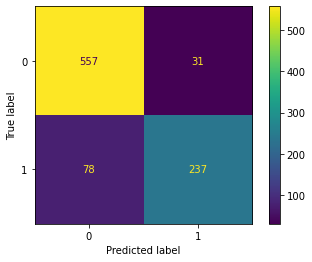

In [9]:
plot_confusion_matrix(cb, X_test, y_test) 

## Model 2: Support Vector Machines (SVM)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [11]:
svm = SVC(gamma=2, C=1)
svm.fit(X_train, y_train)

SVC(C=1, gamma=2)

In [12]:
pred = svm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       588
           1       0.89      0.51      0.65       315

    accuracy                           0.81       903
   macro avg       0.84      0.74      0.76       903
weighted avg       0.82      0.81      0.79       903



C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


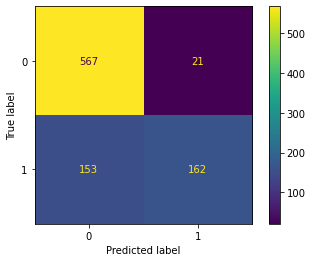

In [13]:
plot_confusion_matrix(svm, X_test, y_test) 

## Model 3: Decision Tree

In [14]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [15]:
pred = dt.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       588
           1       0.79      0.63      0.70       315

    accuracy                           0.81       903
   macro avg       0.81      0.77      0.78       903
weighted avg       0.81      0.81      0.81       903



C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


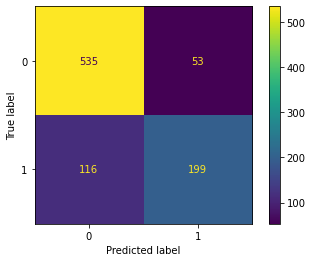

In [16]:
plot_confusion_matrix(dt, X_test, y_test) 

## Model 4: k-Nearest Neighbors (kNN)

In [17]:
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       588
           1       0.77      0.68      0.72       315

    accuracy                           0.82       903
   macro avg       0.81      0.79      0.79       903
weighted avg       0.82      0.82      0.82       903



C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


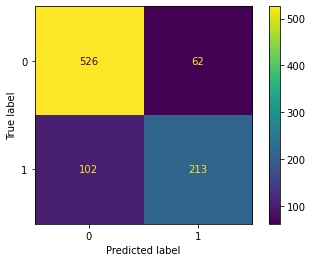

In [19]:
plot_confusion_matrix(knn, X_test, y_test) 

## Model 5: Naive Bayes

In [20]:
nn = GaussianNB()
nn.fit(X_train, y_train)

GaussianNB()

In [21]:
pred = nn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       588
           1       0.83      0.36      0.50       315

    accuracy                           0.75       903
   macro avg       0.78      0.66      0.67       903
weighted avg       0.77      0.75      0.72       903



C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


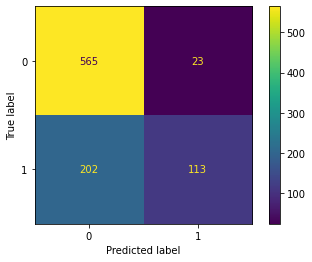

In [22]:
plot_confusion_matrix(nn, X_test, y_test) 

## Model 3: Decision Tree

# Feature importance

- For each feature, feature importance shows how much the prediction changes if the feature value changes. The bigger the value of the feature importance, the bigger is the change to the prediction value.

    - facial expressions: postive, neutral, and negative
    - eyeblink
    - head pose: rx, ry, rz
    - heart beat interval: interbeat_interval
    - wl_rating: workload rating
    - sa_correct: situation awarnesss
    - traffic density: number of aircraft

<BarContainer object of 11 artists>

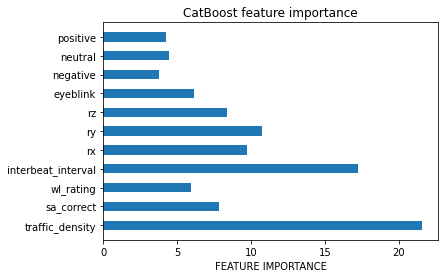

In [23]:
# calculate the feature importance of CatBoost
model = cb

fea_ = model.feature_importances_

fea_name = list(X.columns)
fea_name = [str(j) for j in fea_name]

# plt.figure(figsize=(12, 8))
plt.title('CatBoost feature importance')
plt.xlabel('FEATURE IMPORTANCE')
# plt.ylabel('FEATURE NAMES')
plt.barh(fea_name,fea_,height =0.5)